In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## What this notebook contains

The goal of this notebook is to set-up one of the key experiments contained in my paper. The overall idea is that even when the ground-truth data is generated as a linear regression, the alternating minimization-grad descent scheme is very suboptimal, even when you overparameterize the representation as a powerful neural network (compared to the ground truth representation, which is just a matrix in this case).

To put some math into this, we assume that our data is generated as:
\begin{align*}
    y^{(t)}_i = F^{(t)}_\star \Phi_\star x^{(t)}_i + w^{(t)}_i,\quad y^{(t)}_i \in \mathbb R^{d_y}, x^{(t)}_i \in \mathbb R^{d_x}, \Phi_\star \in \mathbb R^{r \times d_x}.
\end{align*}
where $t$ indexes distinct tasks $t = 1,\dots, T$. For normalization purposes, we assume $\Phi_\star$ has orthonormal rows. In this set of experiments, we simplify things and assume $x^{(t)}_i$ and $w^{(t)}_i$ are independent and identically distributed across all tasks:
\begin{align*}
    x_i^{(t)} \sim \mathcal N (0, \Sigma_x),\;\; w_i^{(t)} \sim \mathcal N(0, \sigma^2 \cdot \mathrm{Id}), \quad \text{for all }i,t.
\end{align*}
Notably, $\Sigma_x \succ 0$ is going to be generated as some covariance matrix that is *non-isotropic*, i.e. not Identity (or any constant scaling of it. We can take a peek at the data generation functions we imported: `from linreg_data import generate_parameters, generate_data`.

In [2]:
def generate_parameters(dx, dy, r, num_tasks):

    # randomly generate covariance of x
    U = 5*torch.eye(dx) + torch.randn(dx, dx)
    Sigma_x = 0.5*(U + U.T)                                # Make Sigma_x symmetric
    Sigma_x = (dx / torch.trace(Sigma_x)) * Sigma_x        # normalize to get Tr(Sigma_x) = dx

    # randomly generate representation Phi
    A = torch.randn(r, dx)
    _, _, Phi = torch.linalg.svd(A, full_matrices = False) # Generate Phi* as random matrix that is then orthonormalized.

    # randomly generate heads F0 (for validation), F1,...,FT (for training)
    F0 = torch.randn(dy, r)
    Fs = []
    Fs.append(F0)
    for i in range(num_tasks):
        gamma = 0.01
        B = torch.randn(dy, dy)
        rot = torch.linalg.matrix_exp(0.5*gamma*(B - B.T)) # Generate heads by randomly applying a rotation to F0
        F = rot @ F0
        Fs.append(F)

    return Fs, Phi, Sigma_x

As one can glean above, the `generate_parameters` is an exceedingly simple way to randomly generate the key parameters of the ground-truth data, which are the heads $F^{(1)},\dots, F^{(T)}$, the representation $\Phi_\star$ and the *non-isotropic* data covariance $\Sigma_x$.

The following function `generate_data` simply generates data $(x^{(t)}_i, y_i^{(t)})$ from said parameters.

In [3]:
# def generate_data(n_points, Fs, Phi, cov_x, mode = 'train'):

#     U, S, V = torch.linalg.svd(cov_x)
#     cov_x_sqrt = U @ torch.diag(torch.sqrt(S)) @ V
#     dy = Fs[0].shape[0]
#     dx = Phi.shape[-1]

#     if mode == 'train':
#         X = []
#         Y = []
#         for i in range(1, len(Fs)):                       # for each task 1,...,T
#             M = Fs[i] @ Phi
#             xs = cov_x_sqrt @ torch.randn(dx, n_points)
#             ws = 0.1*torch.randn(dy, n_points)
#             ys = M @ xs + ws

#             X.append(xs)
#             Y.append(ys)
#         return X, Y

#     elif mode == 'test':
#         M = Fs[0] @ Phi
#         xs = cov_x_sqrt @ torch.randn(dx, n_points)
#         ws = torch.randn(dy, n_points)
#         ys = M @ xs + ws

#         return xs, ys


def generate_data(n_points, Fs, Phi, cov_x):
    U, S, V = torch.linalg.svd(cov_x)
    cov_x_sqrt = U @ torch.diag(torch.sqrt(S)) @ V
    dy = Fs[0].shape[0]
    dx = Phi.shape[-1]

    X_train, Y_train, X_test, Y_test, Ws = [], [], [], [], []
    # adjust this
    for i in range(len(Fs)):
        M = Fs[i] @ Phi
        xs = cov_x_sqrt @ torch.randn(dx, n_points)
        ws = 0.1 * torch.randn(dy, n_points)
        ys = M @ xs + ws

        train_split = int(0.5 * n_points)
        X_train.append(xs[:, :train_split])
        Y_train.append(ys[:, :train_split])
        X_test.append(xs[:, train_split:])
        Y_test.append(ys[:, train_split:])
        Ws.append(ws)

    return X_train, Y_train, X_test, Y_test, Ws

The only trick we used here is a property of Gaussian random vectors: $x \sim \mathcal N(0, \Sigma_x)$ is equivalent to $x = \Sigma_x^{1/2} v$, $v \sim \mathcal N(0, \mathrm{Id})$.

<!-- With parameter generation and data generation in hand, let us describe the experiment. For each batch of data, we run 4 algorithms/models, all falling under the alternating minimization-descent paradigm. By this we mean, for each update iteration:

1. **(Minimization)** Hold current rep. $\hat\Phi(\cdot)$ fixed. For each task compute the (rep-conditioned) least-squares head:
\begin{align*}
\hat F^{(t)} = \argmin_F \sum_{i=1}^{\texttt{n\_points}} \|y_i^{(t)} - F \hat\Phi (x_i^{(t)}) \|^2.
\end{align*}
2. **(Descent)** Hold the least-squares heads $\hat F^{(1)}, \dots, \hat F^{(T)}$ fixed. Perform a descent step (whatever that may look like depending on the algorithm) on the representation. We usually assume this update can be computed locally for each task and averaged to yield the final update (this is certainly true for grad descent, since $\nabla $ is a linear operator).
\begin{align*}
d^{(t)} &= \mathrm{DescentStep}(\hat\Phi; (x_i^{(t)}, y_i^{(t)})_{i=1}^{\texttt{n\_points}},\; \hat F^{(t)} ), \quad \text{for }t = 1,\dots, T \\
\hat\Phi^{(t)}_{\mathrm{next}} &= \hat\Phi - \eta d^{(t)} \\
\hat\Phi_{\mathrm{next}} &= \frac{1}{T}\sum_{t=1}^T \hat\Phi^{(t)}_{\mathrm{next}} \\
\text{(For certain methods) }\hat\Phi_{\mathrm{next}} &= \mathrm{Postprocess}(\hat\Phi_{\mathrm{next}}).
\end{align*} -->

In [4]:
#Phi is parameterized by a 2 layer nn
class PhiNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super(PhiNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

In [5]:
def least_squares_head(X, Y, Phi):
    with torch.no_grad():
        Phi_X = Phi(X)
    l = Y.T @ Phi_X
    r = torch.linalg.inv(Phi_X.T @ Phi_X + 1e-5 * torch.eye(Phi_X.shape[1], device=device))
    return l @ r


In [6]:
import pdb

def excess_risk(X, Y, F, Phi, W):
    with torch.no_grad():
        pred = F @ Phi(X).T
        pred_risk = torch.mean((Y - pred.T) ** 2)

        # used closed form instead
        # true_risk = (W ** 2).mean()
        # pdb.set_trace()
        # true_risk = Y.shape[1] * .01
        # print(f"Pred Risk: {pred_risk.item()}, True Risk: {true_risk}")

    return pred_risk



In [44]:
def experiment(dx, dy, r, T, n, lr, num_steps):
    # Generate parameters and data
    F_star, Phi_star, Sigma_x = generate_parameters(dx, dy, r, T + 1)
    X_train, Y_train, X_test, Y_test, Ws = generate_data(n, F_star, Phi_star, Sigma_x)

    # Separate hold-out task
    X_holdout_train, Y_holdout_train = X_train[0], Y_train[0]
    X_holdout_test, Y_holdout_test = X_test[0], Y_test[0]

    # Move all data and models to device
    F_star = [f.to(device) for f in F_star]
    Phi_star = Phi_star.to(device)
    X_train = [x.to(device) for x in X_train]  # Exclude the held-out task
    Y_train = [y.to(device) for y in Y_train]
    X_test = [x.to(device) for x in X_test]
    Y_test = [y.to(device) for y in Y_test]

    X_holdout_train, Y_holdout_train = X_holdout_train.to(device), Y_holdout_train.to(device)
    X_holdout_test, Y_holdout_test = X_holdout_test.to(device), Y_holdout_test.to(device)

    # Initialize model
    Phi = PhiNet(input_dim=dx, output_dim=r).to(device)
    optimizer = optim.SGD(Phi.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Train on training tasks
    for step in range(num_steps):
        total_loss = 0.0
        for t in range(1, T + 1):
            x = X_train[t].T
            y = Y_train[t].T

            optimizer.zero_grad()
            embeddings = Phi(x)
            F_t = least_squares_head(x, y, Phi)
            preds = F_t @ embeddings.T
            loss = criterion(preds.T, y)

            total_loss += loss
        total_loss.backward()
        optimizer.step()


    # Compute excess risks
    train_excess_risks = []
    for t in range(1, T + 1):
        x = X_test[t].T
        y = Y_test[t].T
        F_t = least_squares_head(x, y, Phi)
        train_excess_risks.append(excess_risk(x, y, F_t, Phi, Ws[t]))
    avg_train_excess_risk = torch.tensor(train_excess_risks, device=device).mean().item()

    # Held-out task evaluation
    F_heldout = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi)
    test_excess_risk = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_heldout, Phi, Ws[0]).item()
    transfer_coefficient = avg_train_excess_risk / test_excess_risk
    print(f"Avg Train Excess Risk: {avg_train_excess_risk}, Test Excess Risk: {test_excess_risk}")
    
    return transfer_coefficient

In [45]:
from tqdm.notebook import tqdm

dx, dy, r = 50, 15, 5
num_tasks = 10
num_trials = 100
n = 100


lr = 0.01
num_steps = 1000

all_transfer_coefficients = []

# Run multiple trials
for trial in tqdm(range(num_trials), desc="Running Experiments"):
    transfer_coefficient = experiment(dx, dy, r, num_tasks, n, lr, num_steps)
    all_transfer_coefficients.append(transfer_coefficient)




Running Experiments:   0%|          | 0/100 [00:00<?, ?it/s]

Avg Train Excess Risk: 0.12921401858329773, Test Excess Risk: 0.154835507273674
Avg Train Excess Risk: 0.14660629630088806, Test Excess Risk: 0.1653749644756317
Avg Train Excess Risk: 0.15482018887996674, Test Excess Risk: 0.18567875027656555
Avg Train Excess Risk: 0.14997883141040802, Test Excess Risk: 0.15694858133792877
Avg Train Excess Risk: 0.15908004343509674, Test Excess Risk: 0.20058836042881012
Avg Train Excess Risk: 0.15949484705924988, Test Excess Risk: 0.23414961993694305
Avg Train Excess Risk: 0.15866532921791077, Test Excess Risk: 0.23547838628292084
Avg Train Excess Risk: 0.12194199860095978, Test Excess Risk: 0.14533628523349762
Avg Train Excess Risk: 0.12839652597904205, Test Excess Risk: 0.17576617002487183
Avg Train Excess Risk: 0.14717093110084534, Test Excess Risk: 0.16339515149593353
Avg Train Excess Risk: 0.13163037598133087, Test Excess Risk: 0.13626646995544434
Avg Train Excess Risk: 0.1718866229057312, Test Excess Risk: 0.2066805064678192
Avg Train Excess Risk

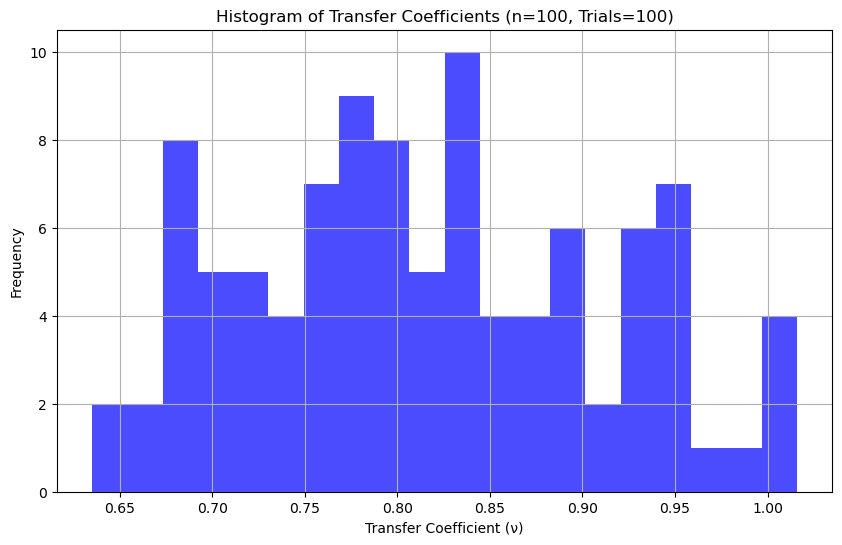

In [46]:
all_transfer_coefficients = torch.tensor(all_transfer_coefficients)

plt.figure(figsize=(10, 6))
plt.hist(all_transfer_coefficients.cpu().numpy(), bins=20, alpha=0.7, color="blue")
plt.xlabel("Transfer Coefficient (ν)")
plt.ylabel("Frequency")
plt.title(f"Histogram of Transfer Coefficients (n={n}, Trials={num_trials})")
plt.grid()
plt.show()

Experiments to run:
- Take bad matrix invertible matrix, multiply $\hat{\Phi}$, $Q$, 
compare validation loss of the shitty $\Phi$ and unmodified Phi on the same holdout task

- Plot the histogram transfer coefficients on these shitty Q

- Hope to see: Shitty representaiton \implies increase variance, histogram has fatter tails, validation loss is higher

- Run a fixed number of SGD steps

- Future Direction:
We'd like to establish some sort of connection between Differential privacy and task transferability:
Consider  $\hat{\Phi}_1$ and $\hat{\Phi}_2$. trained on different dataasets. We'd like to test which datset the two were
trained on for sufficiently high probability, then we saw that the transfer coefficient \nu is about the same for eahc $\phi

If not, then we can (presumably tell that $\hat{\Phi}_1$ and $\hat{\Phi}_2$ using the target task). 


#### Testing to ERM sufficient to enforce transfer

In [ ]:
def generate_ill_conditioned_matrix(dim, min_eigenvalue=1e-4, max_eigenvalue=1e4):
    # Generate logarithmically spaced eigenvalues
    eigenvalues = torch.logspace(start=torch.log10(torch.tensor(min_eigenvalue)),
                                 end=torch.log10(torch.tensor(max_eigenvalue)),
                                 steps=dim)

    Q, _ = torch.linalg.qr(torch.randn(dim, dim)) 
    D = torch.diag(eigenvalues)
    D_inv = torch.diag(1 / (eigenvalues + 1e-10))
    ill_conditioned_matrix = Q @ D @ Q.T
    inv = Q.T @ D_inv @ Q
    return ill_conditioned_matrix.to(device), inv.to(device)

In [ ]:
def optimize_head_with_sgd(X, Y, Phi, num_steps=100, lr=0.01):
    dy, r = Y.shape[0], Phi(X.T).shape[1] 
    F = torch.nn.Parameter(torch.randn(dy, r, device=device)) 
    optimizer = optim.SGD([F], lr=lr)
    criterion = nn.MSELoss()

    for step in range(num_steps):
        optimizer.zero_grad()
        embeddings = Phi(X.T)
        preds = F @ embeddings.T
        loss = criterion(preds.T, Y.T)
        loss.backward()
        optimizer.step()

    return F

In [ ]:
def experiment_with_bad_representation(dx, dy, r, T, n, lr, num_steps, opt="LS"):
    F_star, Phi_star, Sigma_x = generate_parameters(dx, dy, r, T + 1)
    X_train, Y_train, X_test, Y_test, Ws = generate_data(n, F_star, Phi_star, Sigma_x)

    # Separate hold-out task
    X_holdout_train, Y_holdout_train = X_train[0], Y_train[0]
    X_holdout_test, Y_holdout_test = X_test[0], Y_test[0]

    # Move all data and models to device
    F_star = [f.to(device) for f in F_star]
    Phi_star = Phi_star.to(device)
    X_train = [x.to(device) for x in X_train]
    Y_train = [y.to(device) for y in Y_train]
    X_test = [x.to(device) for x in X_test]
    Y_test = [y.to(device) for y in Y_test]

    X_holdout_train, Y_holdout_train = X_holdout_train.to(device), Y_holdout_train.to(device)
    X_holdout_test, Y_holdout_test = X_holdout_test.to(device), Y_holdout_test.to(device)

    # Initialize model
    Phi = PhiNet(input_dim=dx, output_dim=r).to(device)
    optimizer = optim.SGD(Phi.parameters(), lr=lr)
    criterion = nn.MSELoss()


    
    # Train on training tasks
    for step in range(num_steps):
        total_loss = 0.0
        for t in range(1, T + 1):
            x = X_train[t].T
            y = Y_train[t].T

            optimizer.zero_grad()
            embeddings = Phi(x)
            F_t = least_squares_head(x, y, Phi)
            preds = embeddings @ F_t.T
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    # Evaluate "good" representation
    train_excess_risks_good = []
    for t in range(1, T + 1):
        x = X_test[t].T
        y = Y_test[t].T
        F_t = least_squares_head(x, y, Phi)
        train_excess_risks_good.append(excess_risk(x, y, F_t, Phi, Ws[t]))
        
    avg_train_excess_risk = torch.tensor(train_excess_risks_good, device=device).mean().item()

    F_heldout_good = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi)
        

    test_excess_risk_good = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_heldout_good, Phi, Ws[0]).item()
    transfer_coefficient_good = avg_train_excess_risk / test_excess_risk_good

    # Create a "bad" representation
    Q, Q_inv = generate_ill_conditioned_matrix(r)
    Phi_bad = lambda x: (Q @ Phi(x).T).T

    # Phi_{bad} will satsify ERM with F Q^{-1}, and achieve the same average train ER, so no need to compute it again

    F_heldout_bad = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi_bad)
    test_excess_risk_bad = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_heldout_bad, Phi_bad, Ws[0]).item()

    transfer_coefficient_bad = avg_train_excess_risk / test_excess_risk_bad

    # Output results
    print(f"Bad Representation  - Avg Train ER: {avg_train_excess_risk}, Test ER: {test_excess_risk_bad}, Transfer Coefficient: {transfer_coefficient_bad}")

    print(f"Good Representation - Avg Train ER: {avg_train_excess_risk}, Test ER: {test_excess_risk_good}, Transfer Coefficient: {transfer_coefficient_good}")

    # transfer_coefficient_bad = 0
    return transfer_coefficient_good, transfer_coefficient_bad



from tqdm import tqdm

dx, dy, r = 50, 15, 5
num_tasks = 10
num_trials = 100
n = 100


lr = 0.01
num_steps = 1000


transfer_coefficients_good = []
transfer_coefficients_bad = []

for trial in tqdm(range(num_trials), desc="Running Experiments with ERM"):
    tc_good, tc_bad = experiment_with_bad_representation(dx, dy, r, num_tasks, n, lr, num_steps)
    transfer_coefficients_good.append(tc_good)
    transfer_coefficients_bad.append(tc_bad)

Running Experiments with ERM:   0%|          | 0/100 [00:02<?, ?it/s]


KeyboardInterrupt: 

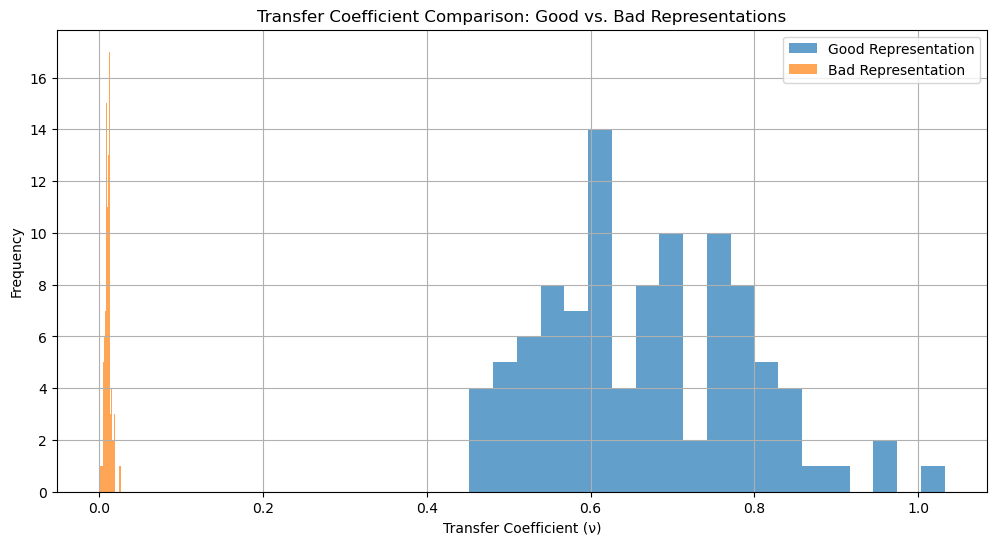

In [ ]:
plt.figure(figsize=(12, 6))

plt.hist(torch.tensor(transfer_coefficients_good).cpu().numpy(), bins=20, alpha=0.7, label="Good Representation")
plt.hist(torch.tensor(transfer_coefficients_bad).cpu().numpy(), bins=20, alpha=0.7, label="Bad Representation")

plt.xlabel("Transfer Coefficient (ν)")
plt.ylabel("Frequency")
plt.title("Transfer Coefficient Comparison: Good vs. Bad Representations")
plt.legend()
plt.grid()
plt.show()

In [ ]:
def experiment_with_bad_representation(dx, dy, r, T, n, lr, num_steps, opt="LS"):
    F_star, Phi_star, Sigma_x = generate_parameters(dx, dy, r, T + 1)
    X_train, Y_train, X_test, Y_test, Ws = generate_data(n, F_star, Phi_star, Sigma_x)

    # Separate hold-out task
    X_holdout_train, Y_holdout_train = X_train[0], Y_train[0]
    X_holdout_test, Y_holdout_test = X_test[0], Y_test[0]

    # Move all data and models to device
    F_star = [f.to(device) for f in F_star]
    Phi_star = Phi_star.to(device)
    X_train = [x.to(device) for x in X_train]
    Y_train = [y.to(device) for y in Y_train]
    X_test = [x.to(device) for x in X_test]
    Y_test = [y.to(device) for y in Y_test]

    X_holdout_train, Y_holdout_train = X_holdout_train.to(device), Y_holdout_train.to(device)
    X_holdout_test, Y_holdout_test = X_holdout_test.to(device), Y_holdout_test.to(device)

    # Initialize model (Phi is fixed after training)
    Phi = PhiNet(input_dim=dx, output_dim=r).to(device)
    optimizer = optim.Adam(Phi.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Train representation Phi on training tasks
    for step in range(num_steps):
        for t in range(1, T + 1):
            x = X_train[t].T
            y = Y_train[t].T

            optimizer.zero_grad()
            embeddings = Phi(x)
            F_t = least_squares_head(x, y, Phi)
            preds = embeddings @ F_t.T
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
    
    train_excess_risks_good = []
    for t in range(1, T + 1):
        x = X_test[t].T
        y = Y_test[t].T
        F_t = least_squares_head(x, y, Phi)
        train_excess_risks_good.append(excess_risk(x, y, F_t, Phi, Ws[t]))
        
    avg_train_excess_risk = torch.tensor(train_excess_risks_good, device=device).mean().item()

    # Evaluate "good" representation on holdout task
    F_heldout_good = None
    if opt == "LS":
        F_heldout_good = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi)
    elif opt == "GD":
        F_heldout_good = torch.nn.Parameter(torch.randn(dy, r, device=device) * .1)  # Random initialization
        optimizer_head_good = optim.Adam([F_heldout_good], lr=0.01)
        for step in range(1000):  
            optimizer_head_good.zero_grad()
            embeddings_good = Phi(X_holdout_train.T)
            preds_good = F_heldout_good @ embeddings_good.T
            loss_good = criterion(preds_good.T, Y_holdout_train.T)
            loss_good.backward()
            print(f"Loss: {loss_good.item()}")
            torch.nn.utils.clip_grad_norm_(F_heldout_good, max_norm=100.0)

            optimizer_head_good.step()

    test_excess_risk_good = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_heldout_good, Phi, Ws[0]).item()
    avg_train_excess_risk = torch.tensor(train_excess_risks_good, device=device).mean().item()
    transfer_coefficient_good = avg_train_excess_risk / test_excess_risk_good

    # Create a "bad" representation
    Q, Q_inv = generate_ill_conditioned_matrix(r)
    Phi_bad = lambda x: (Q @ Phi(x).T).T

    # Evaluate "bad" representation on holdout task
    F_heldout_bad = None
    if opt == "LS":
        F_heldout_bad = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi_bad)
    elif opt == "GD":
        F_heldout_bad = torch.nn.Parameter(least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi_bad) @ Q_inv)  # Random initialization
        optimizer_head_bad = optim.Adam([F_heldout_bad], lr=0.001)
        for step in range(1000):  # Fixed number of SGD steps
            optimizer_head_bad.zero_grad()
            embeddings_bad = Phi_bad(X_holdout_train.T)
            preds_bad = F_heldout_bad @ embeddings_bad.T
            loss_bad = criterion(preds_bad.T, Y_holdout_train.T)
            loss_bad.backward()
            torch.nn.utils.clip_grad_norm_(F_heldout_bad, max_norm=1.0)
            print(f"Loss: {loss_bad.item()}")
            optimizer_head_bad.step()

    test_excess_risk_bad = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_heldout_bad, Phi_bad, Ws[0]).item()
    
    transfer_coefficient_bad = avg_train_excess_risk / test_excess_risk_bad

    # Output results
    print(f"Bad Representation  - Avg Train ER: {avg_train_excess_risk}, Test ER: {test_excess_risk_bad}, Transfer Coefficient: {transfer_coefficient_bad}")

    print(f"Good Representation - Avg Train ER: {avg_train_excess_risk}, Test ER: {test_excess_risk_good}, Transfer Coefficient: {transfer_coefficient_good}")

    return transfer_coefficient_good, transfer_coefficient_bad



from tqdm import tqdm

dx, dy, r = 50, 15, 5
num_tasks = 10
num_trials = 100
n = 100


lr = 0.01
num_steps = 1000


transfer_coefficients_good = []
transfer_coefficients_bad = []

for trial in tqdm(range(num_trials), desc="Running Experiments with ERM"):
    tc_good, tc_bad = experiment_with_bad_representation(dx, dy, r, num_tasks, n, lr, num_steps, opt="GD")
    transfer_coefficients_good.append(tc_good)
    transfer_coefficients_bad.append(tc_bad)

### Evolution of transfer coeff while updating representation

In [ ]:
def experiment(dx, dy, r, T, n, lr, num_steps):
    # Generate parameters and data
    F_star, Phi_star, Sigma_x = generate_parameters(dx, dy, r, T + 1)
    X_train, Y_train, X_test, Y_test, Ws = generate_data(n, F_star, Phi_star, Sigma_x)

    # Separate hold-out task
    X_holdout_train, Y_holdout_train = X_train[0], Y_train[0]
    X_holdout_test, Y_holdout_test = X_test[0], Y_test[0]

    # Move all data and models to device
    F_star = [f.to(device) for f in F_star]
    Phi_star = Phi_star.to(device)
    X_train = [x.to(device) for x in X_train]  # Exclude the held-out task
    Y_train = [y.to(device) for y in Y_train]
    X_test = [x.to(device) for x in X_test]
    Y_test = [y.to(device) for y in Y_test]

    X_holdout_train, Y_holdout_train = X_holdout_train.to(device), Y_holdout_train.to(device)
    X_holdout_test, Y_holdout_test = X_holdout_test.to(device), Y_holdout_test.to(device)

    # Initialize model
    Phi = PhiNet(input_dim=dx, output_dim=r).to(device)
    optimizer = optim.SGD(Phi.parameters(), lr=lr)
    criterion = nn.MSELoss()
    transfer_coeff_over_time = []



    # Train on training tasks
    for step in range(num_steps):
        total_loss = 0.0
        optimizer.zero_grad()
        for t in range(1, T + 1):
            x = X_train[t].T
            y = Y_train[t].T
            embeddings = Phi(x)
            F_t = least_squares_head(x, y, Phi)
            preds = F_t @ embeddings.T
            loss = criterion(preds.T, y)
            

            total_loss += loss / T

        total_loss.backward()
        optimizer.step()



        # Compute excess risks
        if step % 5 == 0:
          train_excess_risks = []
          for t in range(1, T + 1):
              x = X_test[t].T
              y = Y_test[t].T
              F_t = least_squares_head(x, y, Phi)
              train_excess_risks.append(excess_risk(x, y, F_t, Phi, Ws[t]))
          avg_train_excess_risk = torch.tensor(train_excess_risks, device=device).mean().item()

          # Held-out task evaluation
          F_heldout = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi)
          test_excess_risk = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_heldout, Phi, Ws[0]).item()
          transfer_coefficient = avg_train_excess_risk / test_excess_risk
        #   print(f"Avg Train Excess Risk: {avg_train_excess_risk}, Test Excess Risk: {test_excess_risk}")
          transfer_coeff_over_time.append(transfer_coefficient)
        
    return transfer_coeff_over_time

In [ ]:
from tqdm import tqdm

dx, dy, r = 50, 15, 5
num_tasks = 10
num_trials = 100
n = 100


lr = 0.01
num_steps = 1000

all_transfer_coefficients_over_time = []

# Run multiple trials
for trial in tqdm(range(num_trials), desc="Running Experiments"):
    transfer_coefficient = experiment(dx, dy, r, num_tasks, n, lr, num_steps)
    all_transfer_coefficients_over_time.append(transfer_coefficient)


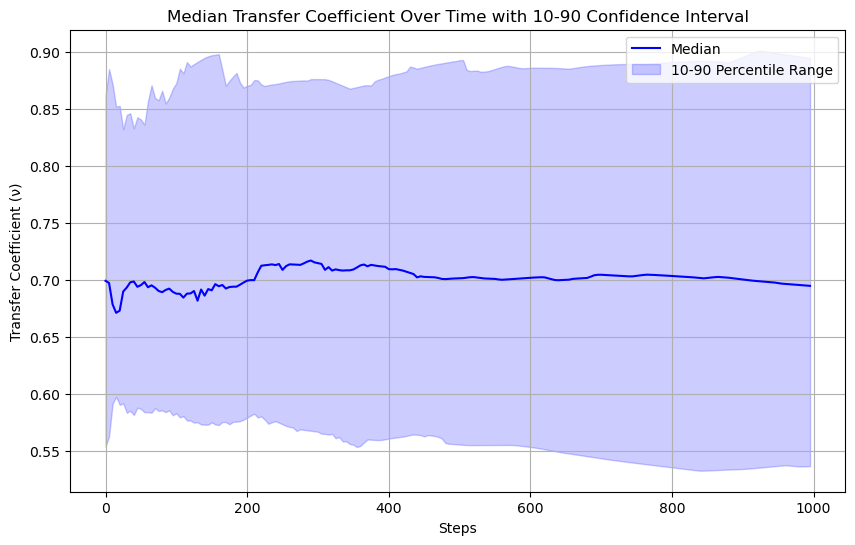

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


all_transfer_coefficients_over_time = np.array(all_transfer_coefficients_over_time)
updates = np.array(range(0, num_steps, 5))

# Compute statistics
median_coefficients = np.median(all_transfer_coefficients_over_time, axis=0)  
percentile_10 = np.percentile(all_transfer_coefficients_over_time, 10, axis=0) 
percentile_90 = np.percentile(all_transfer_coefficients_over_time, 90, axis=0)

# Plotting
plt.figure(figsize=(10, 6))
steps = np.arange(all_transfer_coefficients_over_time.shape[1]) 

plt.plot(updates, median_coefficients, label="Median", color="blue")
plt.fill_between(updates, percentile_10, percentile_90, color="blue", alpha=0.2, label="10-90 Percentile Range")

plt.xlabel("Steps")
plt.ylabel("Transfer Coefficient (ν)")
plt.title("Median Transfer Coefficient Over Time with 10-90 Confidence Interval")
plt.legend()
plt.grid()
plt.show()


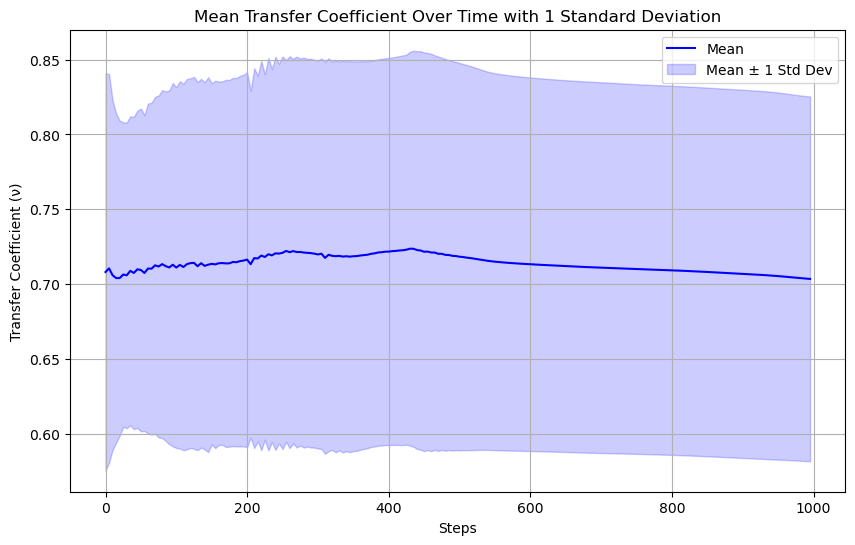

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming all_transfer_coefficients_over_time is a list of arrays of shape (num_trials, num_steps)
all_transfer_coefficients_over_time = np.array(all_transfer_coefficients_over_time)  # Shape: (num_trials, num_steps)
updates = np.array(range(0, num_steps, 5))

# Compute statistics
mean_coefficients = np.mean(all_transfer_coefficients_over_time, axis=0)  # Mean over trials
std_coefficients = np.std(all_transfer_coefficients_over_time, axis=0)    # Standard deviation over trials

# Plotting
plt.figure(figsize=(10, 6))
steps = np.arange(all_transfer_coefficients_over_time.shape[1])  # Steps along the x-axis

plt.plot(updates, mean_coefficients, label="Mean", color="blue")
plt.fill_between(updates, 
                 mean_coefficients - std_coefficients, 
                 mean_coefficients + std_coefficients, 
                 color="blue", alpha=0.2, label="Mean ± 1 Std Dev")

plt.xlabel("Steps")
plt.ylabel("Transfer Coefficient (ν)")
plt.title("Mean Transfer Coefficient Over Time with 1 Standard Deviation")
plt.legend()
plt.grid()
plt.show()


## SGD/DP-SGD

In [ ]:
def experiment(dx, dy, r, T, n, lr, num_steps):
    # Generate parameters and data
    F_star, Phi_star, Sigma_x = generate_parameters(dx, dy, r, T + 1)
    X_train, Y_train, X_test, Y_test, Ws = generate_data(n, F_star, Phi_star, Sigma_x)

    # Separate hold-out task
    X_holdout_train, Y_holdout_train = X_train[0], Y_train[0]
    X_holdout_test, Y_holdout_test = X_test[0], Y_test[0]

    # Move all data and models to device
    F_star = [f.to(device) for f in F_star]
    Phi_star = Phi_star.to(device)
    X_train = [x.to(device) for x in X_train]  # Exclude the held-out task
    Y_train = [y.to(device) for y in Y_train]
    X_test = [x.to(device) for x in X_test]
    Y_test = [y.to(device) for y in Y_test]

    X_holdout_train, Y_holdout_train = X_holdout_train.to(device), Y_holdout_train.to(device)
    X_holdout_test, Y_holdout_test = X_holdout_test.to(device), Y_holdout_test.to(device)

    # Initialize model
    Phi = PhiNet(input_dim=dx, output_dim=r).to(device)
    optimizer = optim.SGD(Phi.parameters(), lr=lr)
    criterion = nn.MSELoss()
    transfer_coeff_over_time = []

    # Train on training tasks using DP-SGD
    for step in range(num_steps):
        total_loss = 0.0
        optimizer.zero_grad()
        for t in range(1, T + 1):
            x = X_train[t].T
            y = Y_train[t].T
            embeddings = Phi(x)
            F_t = least_squares_head(x, y, Phi)
            preds = F_t @ embeddings.T
            loss = criterion(preds.T, y)
            total_loss += loss / T

        # Apply DP-SGD steps
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(Phi.parameters(), max_norm=1.0)
        for param in Phi.parameters():
            param.grad += 0.5 * torch.randn_like(param.grad)
        optimizer.step()

        # Compute excess risks
        if step % 5 == 0:
            train_excess_risks = []
            for t in range(1, T + 1):
                x = X_test[t].T
                y = Y_test[t].T
                F_t = least_squares_head(x, y, Phi)
                train_excess_risks.append(excess_risk(x, y, F_t, Phi, Ws[t]))
            avg_train_excess_risk = torch.tensor(train_excess_risks, device=device).mean().item()

            # Held-out task evaluation
            F_heldout = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi)
            test_excess_risk = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_heldout, Phi, Ws[0]).item()
            transfer_coefficient = avg_train_excess_risk / test_excess_risk
            transfer_coeff_over_time.append(transfer_coefficient)
        
    return transfer_coeff_over_time


In [ ]:
from tqdm import tqdm

dx, dy, r = 50, 15, 5
num_tasks = 10
num_trials = 100
n = 100


lr = 0.01
num_steps = 1000

all_transfer_coefficients_over_time = []

# Run multiple trials
for trial in tqdm(range(num_trials), desc="Running Experiments"):
    transfer_coefficient = experiment(dx, dy, r, num_tasks, n, lr, num_steps)
    all_transfer_coefficients_over_time.append(transfer_coefficient)


Running Experiments: 100%|██████████| 100/100 [05:28<00:00,  3.29s/it]


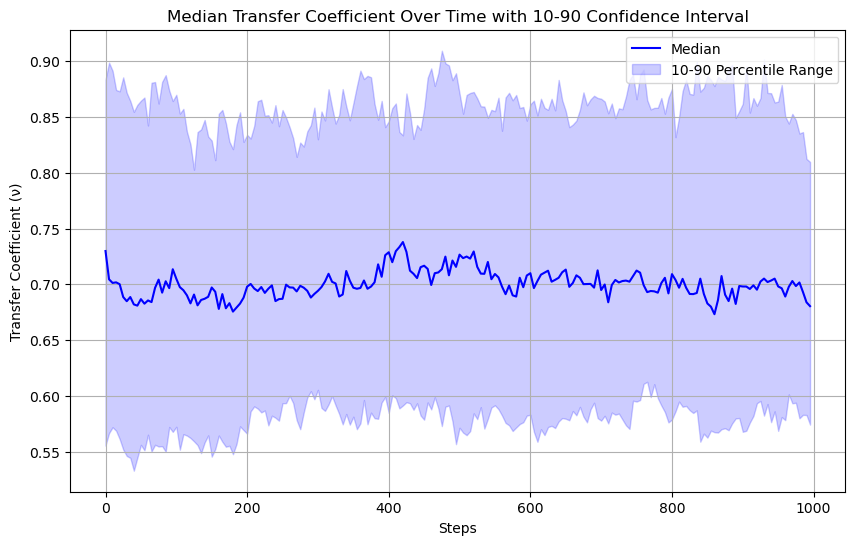

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


all_transfer_coefficients_over_time = np.array(all_transfer_coefficients_over_time)
updates = np.array(range(0, num_steps, 5))

# Compute statistics
median_coefficients = np.median(all_transfer_coefficients_over_time, axis=0)  
percentile_10 = np.percentile(all_transfer_coefficients_over_time, 10, axis=0) 
percentile_90 = np.percentile(all_transfer_coefficients_over_time, 90, axis=0)

# Plotting
plt.figure(figsize=(10, 6))
steps = np.arange(all_transfer_coefficients_over_time.shape[1]) 

plt.plot(updates, median_coefficients, label="Median", color="blue")
plt.fill_between(updates, percentile_10, percentile_90, color="blue", alpha=0.2, label="10-90 Percentile Range")

plt.xlabel("Steps")
plt.ylabel("Transfer Coefficient (ν)")
plt.title("Median Transfer Coefficient Over Time with 10-90 Confidence Interval")
plt.legend()
plt.grid()
plt.show()


Epsilon Values: 100%|██████████| 10/10 [11:14<00:00, 67.44s/it]


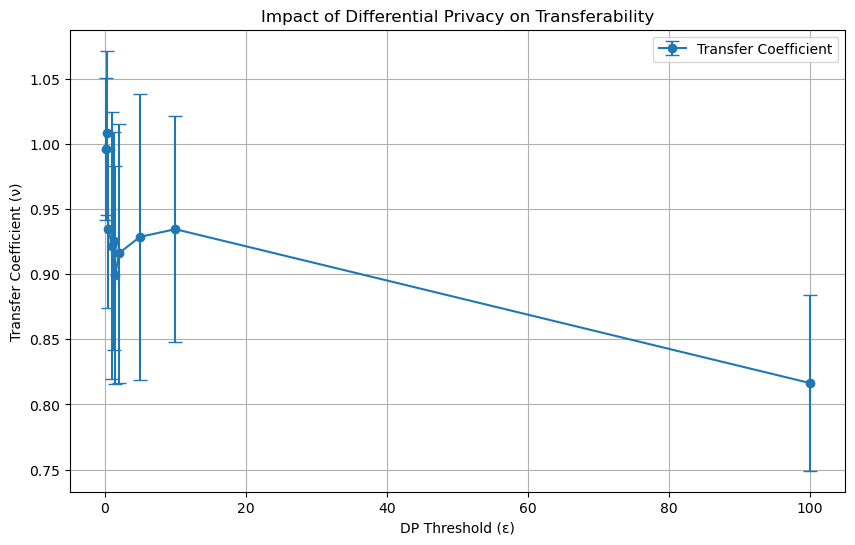

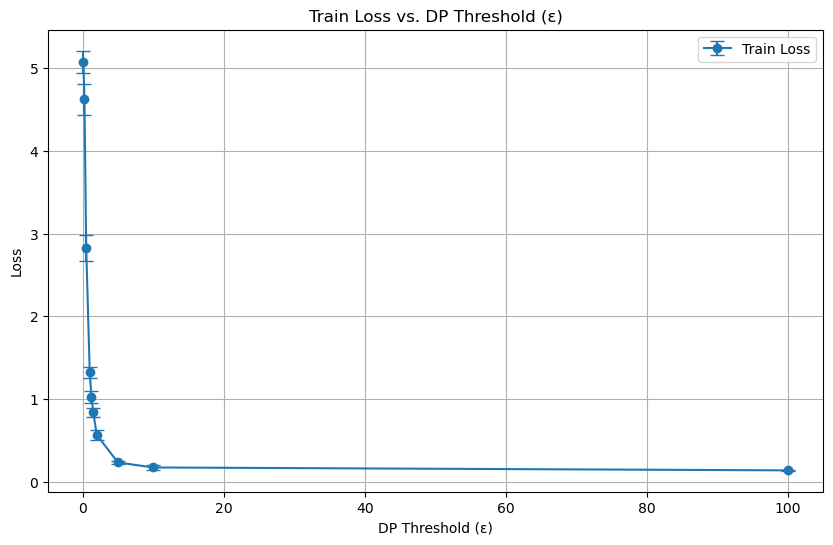

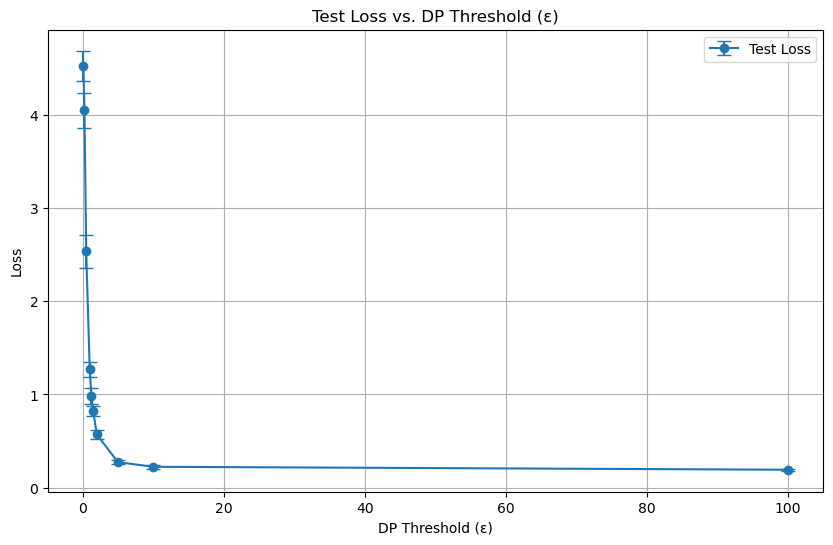

In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


def dp_noise(grad, sensitivity, epsilon):
    """
    Add Gaussian noise to gradients for Differential Privacy.
    """
    sigma = sensitivity / epsilon  # Noise scale
    noise = torch.normal(mean=0, std=sigma, size=grad.size(), device=grad.device)
    return grad + noise


def dp_training_experiment(dx, dy, r, T, n, lr, num_steps, epsilons, sensitivity=1.0):
    """
    Train models with Differential Privacy, track losses, and measure transfer coefficients.
    """
    # Generate parameters and data once for all trials
    F_star, Phi_star, Sigma_x = generate_parameters(dx, dy, r, T + 1)
    X_train, Y_train, X_test, Y_test, Ws = generate_data(n, F_star, Phi_star, Sigma_x)

    # Separate hold-out task
    X_holdout_train, Y_holdout_train = X_train[0], Y_train[0]
    X_holdout_test, Y_holdout_test = X_test[0], Y_test[0]

    transfer_coefficients = []
    train_losses = []
    test_losses = []

    for epsilon in tqdm(epsilons, desc="Epsilon Values", leave=True):
        transfer_coeff_eps = []
        train_losses_eps = []
        test_losses_eps = []

        for trial in tqdm(range(10), desc=f"Trials for ε={epsilon:.1f}", leave=False):
            # Initialize model
            Phi = PhiNet(input_dim=dx, output_dim=r).to(device)
            optimizer = optim.SGD(Phi.parameters(), lr=lr)
            criterion = nn.MSELoss()

            # Train with DP
            for step in range(num_steps):
                optimizer.zero_grad()
                total_loss = 0.0

                for t in range(1, T + 1):
                    x = X_train[t].T
                    y = Y_train[t].T
                    embeddings = Phi(x)
                    F_t = least_squares_head(x, y, Phi)
                    preds = F_t @ embeddings.T
                    loss = criterion(preds.T, y)
                    total_loss += loss / T

                total_loss.backward()

                # Add DP noise to gradients
                for param in Phi.parameters():
                    param.grad = dp_noise(param.grad, sensitivity, epsilon)

                optimizer.step()

            # Compute train and test losses
            train_loss = 0.0
            for t in range(1, T + 1):
                x = X_train[t].T
                y = Y_train[t].T
                F_t = least_squares_head(x, y, Phi)
                preds = F_t @ Phi(x).T
                train_loss += criterion(preds.T, y).item() / T

            test_loss = 0.0
            for t in range(1, T + 1):
                x = X_test[t].T
                y = Y_test[t].T
                F_t = least_squares_head(x, y, Phi)
                preds = F_t @ Phi(x).T
                test_loss += criterion(preds.T, y).item() / T

            train_losses_eps.append(train_loss)
            test_losses_eps.append(test_loss)

            # Compute transfer coefficient
            F_heldout = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi)
            test_excess_risk = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_heldout, Phi, Ws[0]).item()
            train_excess_risks = []

            for t in range(1, T + 1):
                x = X_test[t].T
                y = Y_test[t].T
                F_t = least_squares_head(x, y, Phi)
                train_excess_risks.append(excess_risk(x, y, F_t, Phi, Ws[t]))

            avg_train_excess_risk = torch.tensor(train_excess_risks, device=device).mean().item()
            transfer_coeff_eps.append(avg_train_excess_risk / test_excess_risk)

        transfer_coefficients.append(transfer_coeff_eps)
        train_losses.append(train_losses_eps)
        test_losses.append(test_losses_eps)

    return transfer_coefficients, train_losses, test_losses


# Experiment parameters
epsilons = [0.1, 0.25, 0.5, 1.0, 1.25, 1.5, 2.0, 5, 10, 100]  # Privacy thresholds
dx, dy, r = 50, 15, 5
num_tasks = 10
n = 200
lr = 0.01
num_steps = 500

# Run DP training experiment
transfer_coefficients_dp, train_losses, test_losses = dp_training_experiment(
    dx, dy, r, num_tasks, n, lr, num_steps, epsilons
)

# Convert results to numpy arrays
transfer_coefficients_dp = np.array(transfer_coefficients_dp)  # Shape: (len(epsilons), num_trials)
train_losses = np.array(train_losses)  # Shape: (len(epsilons), num_trials)
test_losses = np.array(test_losses)  # Shape: (len(epsilons), num_trials)

# Compute statistics for transfer coefficients
mean_transfer_coeffs = np.mean(transfer_coefficients_dp, axis=1)
std_transfer_coeffs = np.std(transfer_coefficients_dp, axis=1)

# Compute statistics for train and test losses
mean_train_losses = np.mean(train_losses, axis=1)
std_train_losses = np.std(train_losses, axis=1)
mean_test_losses = np.mean(test_losses, axis=1)
std_test_losses = np.std(test_losses, axis=1)

# Plot transfer coefficients
plt.figure(figsize=(10, 6))
plt.errorbar(epsilons, mean_transfer_coeffs, yerr=std_transfer_coeffs, fmt='-o', capsize=5, label="Transfer Coefficient")
plt.xlabel("DP Threshold (ε)")
plt.ylabel("Transfer Coefficient (ν)")
plt.title("Impact of Differential Privacy on Transferability")
plt.grid()
plt.legend()
plt.show()

# Plot train losses
plt.figure(figsize=(10, 6))
plt.errorbar(epsilons, mean_train_losses, yerr=std_train_losses, fmt='-o', capsize=5, label="Train Loss")
plt.xlabel("DP Threshold (ε)")
plt.ylabel("Loss")
plt.title("Train Loss vs. DP Threshold (ε)")
plt.grid()
plt.legend()
plt.show()

# Plot test losses
plt.figure(figsize=(10, 6))
plt.errorbar(epsilons, mean_test_losses, yerr=std_test_losses, fmt='-o', capsize=5, label="Test Loss")
plt.xlabel("DP Threshold (ε)")
plt.ylabel("Loss")
plt.title("Test Loss vs. DP Threshold (ε)")
plt.grid()
plt.legend()
plt.show()


T-Statistic: 2.5470492930551427, P-Value: 0.01503506459717253


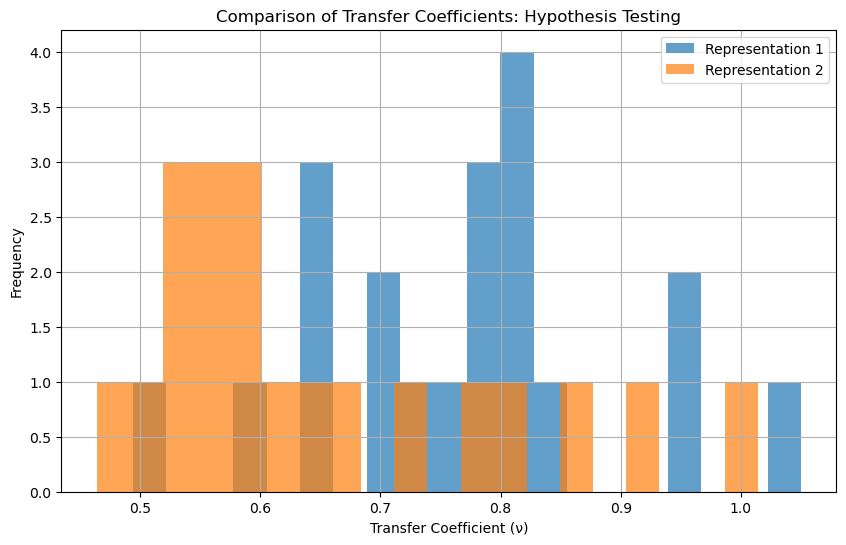

In [ ]:
from scipy.stats import ttest_ind

def hypothesis_testing_experiment(dx, dy, r, T, n, lr, num_steps, num_trials=20):
    """
    Hypothesis testing experiment to evaluate if two learned representations
    have significantly different transfer coefficients.
    """
    transfer_coeffs_rep1, transfer_coeffs_rep2 = [], []
    # Generate parameters and data for representation 1
    F_star_1, Phi_star_1, Sigma_x_1 = generate_parameters(dx, dy, r, T + 1)
    X_train_1, Y_train_1, X_test_1, Y_test_1, Ws_1 = generate_data(n, F_star_1, Phi_star_1, Sigma_x_1)
    
    # Generate parameters and data for representation 2 (different dataset)
    F_star_2, Phi_star_2, Sigma_x_2 = generate_parameters(dx, dy, r, T + 1)
    X_train_2, Y_train_2, X_test_2, Y_test_2, Ws_2 = generate_data(n, F_star_2, Phi_star_2, Sigma_x_2)

    for trial in range(num_trials):
        
        # Train representation 1
        Phi_1 = PhiNet(input_dim=dx, output_dim=r).to(device)
        optimizer_1 = optim.SGD(Phi_1.parameters(), lr=lr)
        criterion = nn.MSELoss()
        for step in range(num_steps):
            optimizer_1.zero_grad()
            total_loss = 0.0
            for t in range(1, T + 1):
                x = X_train_1[t].T
                y = Y_train_1[t].T
                embeddings = Phi_1(x)
                F_t = least_squares_head(x, y, Phi_1)
                preds = F_t @ embeddings.T
                loss = criterion(preds.T, y)
                total_loss += loss / T
            total_loss.backward()
            optimizer_1.step()

        # Train representation 2
        Phi_2 = PhiNet(input_dim=dx, output_dim=r).to(device)
        optimizer_2 = optim.SGD(Phi_2.parameters(), lr=lr)
        for step in range(num_steps):
            optimizer_2.zero_grad()
            total_loss = 0.0
            for t in range(1, T + 1):
                x = X_train_2[t].T
                y = Y_train_2[t].T
                embeddings = Phi_2(x)
                F_t = least_squares_head(x, y, Phi_2)
                preds = F_t @ embeddings.T
                loss = criterion(preds.T, y)
                total_loss += loss / T
            total_loss.backward()
            optimizer_2.step()

        # Evaluate transfer coefficients for representation 1
        F_heldout_1 = least_squares_head(X_train_1[0].T, Y_train_1[0].T, Phi_1)
        test_excess_risk_1 = excess_risk(X_test_1[0].T, Y_test_1[0].T, F_heldout_1, Phi_1, Ws_1[0]).item()
        train_excess_risks_1 = []
        for t in range(1, T + 1):
            x = X_test_1[t].T
            y = Y_test_1[t].T
            F_t = least_squares_head(x, y, Phi_1)
            train_excess_risks_1.append(excess_risk(x, y, F_t, Phi_1, Ws_1[t]))
        avg_train_excess_risk_1 = torch.tensor(train_excess_risks_1, device=device).mean().item()
        transfer_coeff_1 = avg_train_excess_risk_1 / test_excess_risk_1
        transfer_coeffs_rep1.append(transfer_coeff_1)

        # Evaluate transfer coefficients for representation 2
        F_heldout_2 = least_squares_head(X_train_2[0].T, Y_train_2[0].T, Phi_2)
        test_excess_risk_2 = excess_risk(X_test_2[0].T, Y_test_2[0].T, F_heldout_2, Phi_2, Ws_2[0]).item()
        train_excess_risks_2 = []
        for t in range(1, T + 1):
            x = X_test_2[t].T
            y = Y_test_2[t].T
            F_t = least_squares_head(x, y, Phi_2)
            train_excess_risks_2.append(excess_risk(x, y, F_t, Phi_2, Ws_2[t]))
        avg_train_excess_risk_2 = torch.tensor(train_excess_risks_2, device=device).mean().item()
        transfer_coeff_2 = avg_train_excess_risk_2 / test_excess_risk_2
        transfer_coeffs_rep2.append(transfer_coeff_2)

    # Perform t-test for hypothesis testing
    t_stat, p_value = ttest_ind(transfer_coeffs_rep1, transfer_coeffs_rep2)
    return transfer_coeffs_rep1, transfer_coeffs_rep2, t_stat, p_value


# %%
transfer_coeffs_rep1, transfer_coeffs_rep2, t_stat, p_value = hypothesis_testing_experiment(
    dx=50, dy=15, r=5, T=10, n=100, lr=0.01, num_steps=500, num_trials=20
)

print(f"T-Statistic: {t_stat}, P-Value: {p_value}")



# %%
plt.figure(figsize=(10, 6))
plt.hist(transfer_coeffs_rep1, bins=20, alpha=0.7, label="Representation 1")
plt.hist(transfer_coeffs_rep2, bins=20, alpha=0.7, label="Representation 2")
plt.xlabel("Transfer Coefficient (ν)")
plt.ylabel("Frequency")
plt.title("Comparison of Transfer Coefficients: Hypothesis Testing")
plt.legend()
plt.grid()
plt.show()


## Using predictor of $\nu$ to take regularized sgd step before fitting holdout task

In [16]:
import pdb

class GNet(nn.Module):
    def __init__(self, embedding_dim, output_dim, hidden_dim=64):
        super(GNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, flattened_input):
        # Forward pass with precomputed flattened input
        return self.layers(flattened_input)


def experiment(dx, dy, r, T, n, lr_phi, lr_g, num_steps, split_ratio=0.8, reg_param=1):
    # Generate parameters and data
    F_star, Phi_star, Sigma_x = generate_parameters(dx, dy, r, T)
    X_train, Y_train, X_test, Y_test, Ws = generate_data(n, F_star, Phi_star, Sigma_x)

    # Partition X_train and Y_train for \(\Phi\) training, excess risk computation, and validation
    X_phi_train, Y_phi_train, X_risk, Y_risk, X_g_val, Y_g_val = [], [], [], [], [], []
    for t in range(T):
        split_idx = int(split_ratio * X_train[t].shape[1])
        val_idx = split_idx  # Validation size equal to split size

        # Training and risk data
        X_phi_train.append(X_train[t][:, :split_idx].to(device))  # Training subset for \(\Phi\)
        Y_phi_train.append(Y_train[t][:, :split_idx].to(device))
        X_risk.append(X_train[t][:, split_idx:].to(device))       # Excess risk subset
        Y_risk.append(Y_train[t][:, split_idx:].to(device))

        # Validation data (same size as training subset)
        X_g_val.append(X_test[t][:, :val_idx].to(device))
        Y_g_val.append(Y_test[t][:, :val_idx].to(device))

    # Separate hold-out task
    X_holdout_train, Y_holdout_train = X_train[-1][:, :split_idx].to(device), Y_train[-1][:, :split_idx].to(device)
    X_holdout_test, Y_holdout_test = X_test[-1].to(device), Y_test[-1].to(device)
    Ws = [w.to(device) for w in Ws]

    # Initialize models and optimizers
    n_train_per_task = X_phi_train[0].shape[1]
    Phi = PhiNet(input_dim=dx, output_dim=r).to(device)
    G_model = GNet(4339, 1).to(device)  # Adjust input size to handle flattened embeddings
    optimizer_phi = optim.SGD(Phi.parameters(), lr=lr_phi)
    optimizer_g = optim.SGD(G_model.parameters(), lr=lr_g)
    criterion = nn.MSELoss()
    g_criterion = nn.MSELoss()
    g_train_losses = []

    # Training loop with progress bar
    for step in tqdm(range(num_steps), desc="Training Steps", leave=True):
        # Step 1: Train \( \Phi \)
        optimizer_phi.zero_grad()
        total_loss = 0.0
        embeddings = []
        F_ts = []
        for t in range(T):
            x = X_phi_train[t].T
            y = Y_phi_train[t].T
            embedding = Phi(x)  # Shape: (n_train, r)
            embeddings.append(embedding)
            F_t = least_squares_head(x, y, Phi)
            F_ts.append(F_t)
            preds = F_t @ embedding.T
            total_loss += criterion(preds.T, y)
        total_loss.backward()
        optimizer_phi.step()

        heads = [least_squares_head(X_risk[t].T, Y_risk[t].T, Phi) for t in range(T)]
        flattened_heads = [h.flatten() for h in heads]
        flattened_Phi = torch.cat([p.flatten() for p in Phi.parameters()], dim=0)
        excess_risks = torch.tensor(
            [excess_risk(X_risk[t].T, Y_risk[t].T, heads[t], Phi, Ws[t])
             for t in range(T)], device=device)

        # Step 2: Train \( G \) and Compute Validation Loss
        optimizer_g.zero_grad()
        masks = ~torch.eye(T, dtype=torch.bool, device=device)  # Exclude each task one at a time
        remaining_excess_risks = torch.sum(excess_risks.unsqueeze(0) * masks, dim=1)
        avg_remaining_excess_risks = remaining_excess_risks / masks.sum(dim=1)
        transfer_coeffs = avg_remaining_excess_risks / excess_risks  # Compute transfer coefficients

        # Compute G training loss
        g_train_loss = 0.0
        for t in range(T):
            flattened_input = torch.cat(
                [flattened_Phi, torch.cat(flattened_heads[:t] + flattened_heads[t + 1:], dim=0), flattened_heads[t]],
                dim=0
            )
            g_preds = G_model(flattened_input.unsqueeze(0)) 
            g_train_loss += g_criterion(g_preds.squeeze(), transfer_coeffs[t].detach())
        g_train_loss.backward()
        optimizer_g.step()
        g_train_losses.append(g_train_loss.item())

    # Evaluate Transfer Coefficients BEFORE Holdout Update
    F_holdout = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi)
    test_excess_risk_before = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_holdout, Phi, Ws[-1])
    avg_train_excess_risk_before = torch.mean(
        torch.tensor([excess_risk(X_risk[t].T, Y_risk[t].T,
                                  least_squares_head(X_risk[t].T, Y_risk[t].T, Phi),
                                  Phi, Ws[t])
                      for t in range(T - 1)], device=device)).item()
    transfer_coeff_before = avg_train_excess_risk_before / test_excess_risk_before.item()

    # Single Update on \( \Phi \) Using \( G \) with Leave-One-Out Averaging
    optimizer_phi.zero_grad()
    regularizations = []

    for leave_out_t in range(T):
        flattened_input = torch.cat(
            [
                flattened_Phi,
                torch.cat(flattened_heads[:leave_out_t] + flattened_heads[leave_out_t + 1:], dim=0),
                flattened_heads[leave_out_t]
            ],
            dim=0
        )
        regularization = G_model(flattened_input.unsqueeze(0)).item()
        regularizations.append(regularization)

    avg_regularization = sum(regularizations) / T
    std_regularization = torch.std(torch.tensor(regularizations, device=device)).item()

    # Logging for debugging
    print(f"Regularizations Mean: {avg_regularization:.6f}, Standard Deviation: {std_regularization:.6f}")

    preds = F_holdout @ Phi(X_holdout_train.T).T
    loss = criterion(preds.T, Y_holdout_train.T) + reg_param * avg_regularization
    loss.backward()
    optimizer_phi.step()

    # Evaluate Transfer Coefficients AFTER Holdout Update
    F_holdout_updated = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi)
    test_excess_risk_after = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_holdout_updated, Phi, Ws[-1])
    avg_train_excess_risk_after = torch.mean(
        torch.tensor([excess_risk(X_risk[t].T, Y_risk[t].T,
                                  least_squares_head(X_risk[t].T, Y_risk[t].T, Phi),
                                  Phi, Ws[t])
                      for t in range(T - 1)], device=device)).item()
    transfer_coeff_after = avg_train_excess_risk_after / test_excess_risk_after.item()

    print(f"Final G Train Loss: {g_train_losses[-1]}")
    print(f"Transfer Coefficient BEFORE: {transfer_coeff_before}; AFTER: {transfer_coeff_after}")
    print(f"Avg Train Excess Risks BEFORE: {avg_train_excess_risk_before}; Avg Train Excess Risk AFTER: {avg_train_excess_risk_after}")
    print(f"Test Excess Risks BEFORE: {test_excess_risk_before.item()}; Test Excess Risk AFTER: {test_excess_risk_after.item()}")

    return g_train_losses, [], transfer_coeff_before, transfer_coeff_after, avg_train_excess_risk_before, avg_train_excess_risk_after, test_excess_risk_before.item(), test_excess_risk_after.item()


# Experiment parameters
dx, dy, r = 50, 15, 5
T = 10
n = 320
lr_phi = 0.01
lr_g = 0.001
num_steps = 100

g_losses = experiment(dx, dy, r, T, n, lr_phi, lr_g, num_steps, reg_param=0)
g_losses = experiment(dx, dy, r, T, n, lr_phi, lr_g, num_steps, reg_param=10)


Training Steps: 100%|██████████| 100/100 [00:09<00:00, 11.04it/s]


Regularizations Mean: 0.872324, Standard Deviation: 0.000000
Final G Train Loss: 0.42346519231796265
Transfer Coefficient BEFORE: 0.7806765774031359; AFTER: 0.7818482181044937
Avg Train Excess Risks BEFORE: 0.24899551272392273; Avg Train Excess Risk AFTER: 0.24858815968036652
Test Excess Risks BEFORE: 0.318948358297348; Test Excess Risk AFTER: 0.3179493844509125


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.45it/s]

Regularizations Mean: 0.924133, Standard Deviation: 0.000000
Final G Train Loss: 0.26323258876800537
Transfer Coefficient BEFORE: 0.7831122184061176; AFTER: 0.7848823370502221
Avg Train Excess Risks BEFORE: 0.22873800992965698; Avg Train Excess Risk AFTER: 0.2286778837442398
Test Excess Risks BEFORE: 0.29208841919898987; Test Excess Risk AFTER: 0.2913530766963959


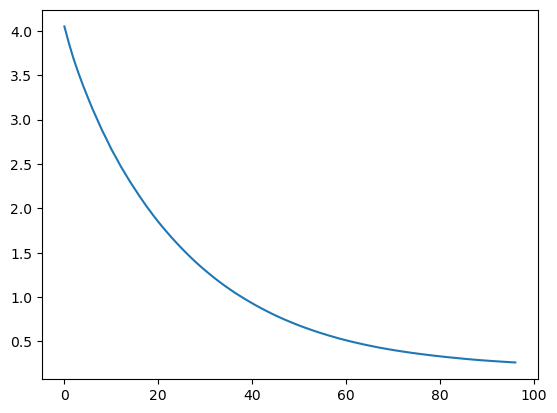

In [25]:
plt.plot(g_losses[0][3:])

Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.92it/s]


Regularizations Mean: 1.011642, Standard Deviation: 0.003064
Final G Train Loss: 0.18430888652801514
Transfer Coefficient BEFORE: 0.8385500686143567; AFTER: 0.841551612227046
Avg Train Excess Risks BEFORE: 0.1301996409893036; Avg Train Excess Risk AFTER: 0.12269946187734604
Test Excess Risks BEFORE: 0.15526758134365082; Test Excess Risk AFTER: 0.14580146968364716


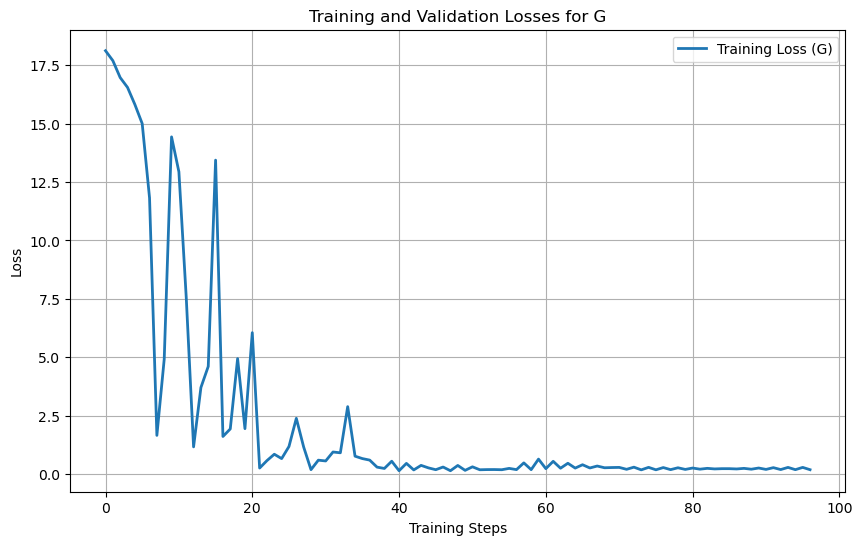

In [28]:
import matplotlib.pyplot as plt

def experiment_and_visualize(dx, dy, r, T, n, lr_phi, lr_g, num_steps, split_ratio=0.8):
    # Run the experiment
    g_train_losses, g_val_losses, transfer_coeff_before, transfer_coeff_after, _, _, _, _ = experiment(
        dx, dy, r, T, n, lr_phi, lr_g, num_steps, split_ratio
    )

    # Plot Training and Validation Losses for G
    plt.figure(figsize=(10, 6))
    plt.plot(g_train_losses[3:], label='Training Loss (G)', linewidth=2)
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses for G')
    plt.legend()
    plt.grid()
    plt.show()

    return g_train_losses, g_val_losses, transfer_coeff_before, transfer_coeff_after


# Run Experiment and Produce Figures
dx, dy, r = 50, 15, 5
T = 10
n = 320
lr_phi = 0.01
lr_g = 0.001
num_steps = 100

g_train_losses, g_val_losses, transfer_coeff_before, transfer_coeff_after = experiment_and_visualize(
    dx, dy, r, T, n, lr_phi, lr_g, num_steps
)



Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.25it/s]


Regularizations Mean: 1.017212, Standard Deviation: 0.001821
Final G Train Loss: 0.16969479620456696
Transfer Coefficient BEFORE: 0.8235992277011246; AFTER: 0.8317188748948283
Avg Train Excess Risks BEFORE: 0.17021144926548004; Avg Train Excess Risk AFTER: 0.16624478995800018
Test Excess Risks BEFORE: 0.20666781067848206; Test Excess Risk AFTER: 0.19988098740577698

Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.83it/s]


Regularizations Mean: 0.818142, Standard Deviation: 0.010514
Final G Train Loss: 0.4340123236179352
Transfer Coefficient BEFORE: 0.6566961524371795; AFTER: 0.6566637212693871
Avg Train Excess Risks BEFORE: 0.23202136158943176; Avg Train Excess Risk AFTER: 0.2316424548625946
Test Excess Risks BEFORE: 0.35331615805625916; Test Excess Risk AFTER: 0.3527565896511078

Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.58it/s]


Regularizations Mean: 1.172283, Standard Deviation: 0.010051
Final G Train Loss: 0.6758061647415161
Transfer Coefficient BEFORE: 0.7259114730027695; AFTER: 0.7251618867519078
Avg Train Excess Risks BEFORE: 0.262114942073822; Avg Train Excess Risk AFTER: 0.2616855204105377
Test Excess Risks BEFORE: 0.36108389496803284; Test Excess Risk AFTER: 0.3608649671077728

Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.89it/s]


Regularizations Mean: 1.211379, Standard Deviation: 0.010916
Final G Train Loss: 0.7887413501739502
Transfer Coefficient BEFORE: 0.9812776711516189; AFTER: 0.9835145312794232
Avg Train Excess Risks BEFORE: 0.26957690715789795; Avg Train Excess Risk AFTER: 0.2695932388305664
Test Excess Risks BEFORE: 0.27472031116485596; Test Excess Risk AFTER: 0.27411210536956787


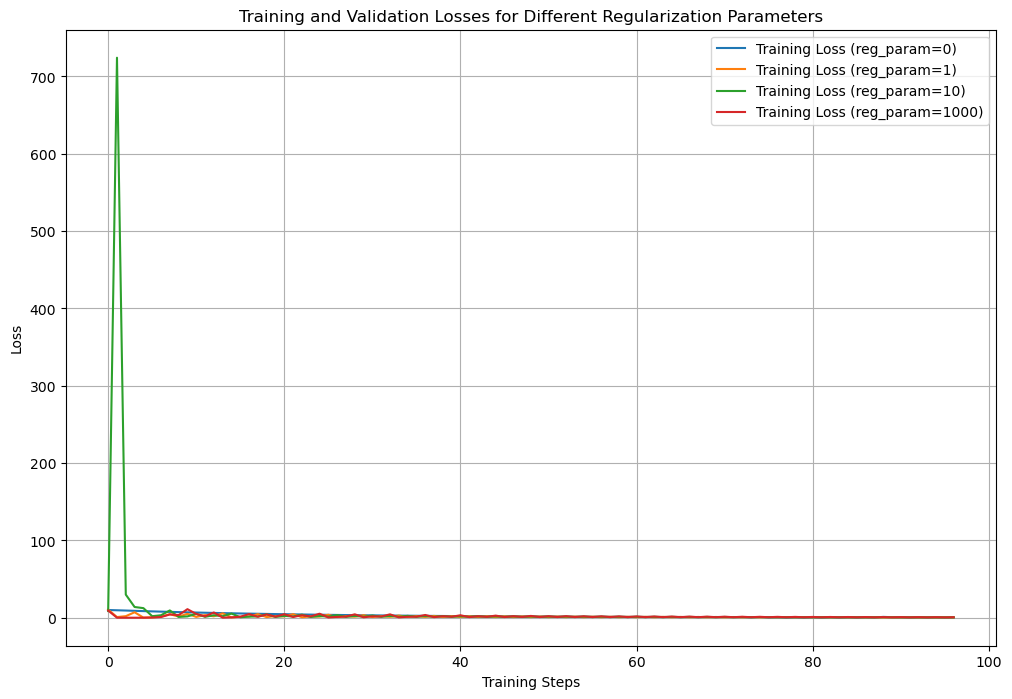

In [29]:
import matplotlib.pyplot as plt

# Run experiments for different regularization parameters
results = {}
for reg_param in [0, 1, 10, 1000]:
    print(f"\nRunning experiment with reg_param={reg_param}...")
    g_train_losses, g_val_losses, transfer_coeff_before, transfer_coeff_after, _, _, _, _ = experiment(
        dx, dy, r, T, n, lr_phi, lr_g, num_steps, reg_param=reg_param
    )
    results[reg_param] = (g_train_losses, g_val_losses, transfer_coeff_before, transfer_coeff_after)

# Plot training and validation losses for each regularization setting
plt.figure(figsize=(12, 8))
for reg_param, (g_train_losses, g_val_losses, _, _) in results.items():
    plt.plot(g_train_losses[3:], label=f'Training Loss (reg_param={reg_param})')

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for Different Regularization Parameters')
plt.legend()
plt.grid()
plt.show()




Running trials for reg_param=0...
Trial 1/5


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.61it/s]


Regularizations Mean: 0.871933, Standard Deviation: 0.000000
Final G Train Loss: 0.4259434640407562
Transfer Coefficient BEFORE: 0.8485300445906245; AFTER: 0.8495789984411993
Avg Train Excess Risks BEFORE: 0.1902540624141693; Avg Train Excess Risk AFTER: 0.18984688818454742
Test Excess Risks BEFORE: 0.2242160588502884; Test Excess Risk AFTER: 0.22345995903015137
Trial 2/5


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.20it/s]


Regularizations Mean: 1.037584, Standard Deviation: 0.001354
Final G Train Loss: 0.48879310488700867
Transfer Coefficient BEFORE: 0.8136256061492205; AFTER: 0.8139643774176157
Avg Train Excess Risks BEFORE: 0.5611154437065125; Avg Train Excess Risk AFTER: 0.5610811710357666
Test Excess Risks BEFORE: 0.6896482110023499; Test Excess Risk AFTER: 0.6893190741539001
Trial 3/5


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 11.19it/s]


Regularizations Mean: 0.857938, Standard Deviation: 0.000000
Final G Train Loss: 0.45279639959335327
Transfer Coefficient BEFORE: 0.8015657895180345; AFTER: 0.7988647551861978
Avg Train Excess Risks BEFORE: 0.3543635308742523; Avg Train Excess Risk AFTER: 0.3535788357257843
Test Excess Risks BEFORE: 0.44208914041519165; Test Excess Risk AFTER: 0.44260162115097046
Trial 4/5


Training Steps: 100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


Regularizations Mean: 1.155648, Standard Deviation: 0.025271
Final G Train Loss: 0.5407363176345825
Transfer Coefficient BEFORE: 0.813705542930744; AFTER: 0.8143726355881162
Avg Train Excess Risks BEFORE: 0.30363234877586365; Avg Train Excess Risk AFTER: 0.30371594429016113
Test Excess Risks BEFORE: 0.3731476962566376; Test Excess Risk AFTER: 0.3729446828365326
Trial 5/5


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 12.44it/s]


Regularizations Mean: 0.909869, Standard Deviation: 0.026868
Final G Train Loss: 0.4897056519985199
Transfer Coefficient BEFORE: 0.7810236751111065; AFTER: 0.7811060997131491
Avg Train Excess Risks BEFORE: 0.6395270228385925; Avg Train Excess Risk AFTER: 0.6391438841819763
Test Excess Risks BEFORE: 0.8188318014144897; Test Excess Risk AFTER: 0.8182548880577087
Running trials for reg_param=1...
Trial 1/5


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 11.89it/s]


Regularizations Mean: 1.032600, Standard Deviation: 0.003361
Final G Train Loss: 0.7042646408081055
Transfer Coefficient BEFORE: 0.9787547754101193; AFTER: 0.9563827411022424
Avg Train Excess Risks BEFORE: 0.4194425344467163; Avg Train Excess Risk AFTER: 0.3928968608379364
Test Excess Risks BEFORE: 0.42854711413383484; Test Excess Risk AFTER: 0.4108155071735382
Trial 2/5


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.57it/s]


Regularizations Mean: 1.009565, Standard Deviation: 0.007100
Final G Train Loss: 0.11104358732700348
Transfer Coefficient BEFORE: 0.7687855649426831; AFTER: 0.7739654071636631
Avg Train Excess Risks BEFORE: 0.13108840584754944; Avg Train Excess Risk AFTER: 0.12671905755996704
Test Excess Risks BEFORE: 0.17051361501216888; Test Excess Risk AFTER: 0.1637270301580429
Trial 3/5


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.59it/s]


Regularizations Mean: 1.012853, Standard Deviation: 0.004094
Final G Train Loss: 0.11023733764886856
Transfer Coefficient BEFORE: 0.8294544560245968; AFTER: 0.8364251285808246
Avg Train Excess Risks BEFORE: 0.12508979439735413; Avg Train Excess Risk AFTER: 0.11983808130025864
Test Excess Risks BEFORE: 0.15080972015857697; Test Excess Risk AFTER: 0.14327412843704224
Trial 4/5


Training Steps: 100%|██████████| 100/100 [00:09<00:00, 10.99it/s]


Regularizations Mean: 1.010605, Standard Deviation: 0.008214
Final G Train Loss: 0.13849182426929474
Transfer Coefficient BEFORE: 0.8204032755452373; AFTER: 0.818363628846197
Avg Train Excess Risks BEFORE: 0.1757548600435257; Avg Train Excess Risk AFTER: 0.1751944124698639
Test Excess Risks BEFORE: 0.21422983705997467; Test Excess Risk AFTER: 0.21407893300056458
Trial 5/5


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.51it/s]


Regularizations Mean: 1.037772, Standard Deviation: 0.003378
Final G Train Loss: 0.4850800931453705
Transfer Coefficient BEFORE: 0.7875731502425423; AFTER: 0.7775617093050075
Avg Train Excess Risks BEFORE: 0.179112046957016; Avg Train Excess Risk AFTER: 0.15533241629600525
Test Excess Risks BEFORE: 0.22742274403572083; Test Excess Risk AFTER: 0.19976860284805298
Running trials for reg_param=10...
Trial 1/5


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.67it/s]


Regularizations Mean: 1.012781, Standard Deviation: 0.008967
Final G Train Loss: 0.11999647319316864
Transfer Coefficient BEFORE: 0.9407182519962419; AFTER: 0.9332211268734472
Avg Train Excess Risks BEFORE: 0.40376678109169006; Avg Train Excess Risk AFTER: 0.393858939409256
Test Excess Risks BEFORE: 0.42921116948127747; Test Excess Risk AFTER: 0.42204245924949646
Trial 2/5


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.52it/s]


Regularizations Mean: 0.834635, Standard Deviation: 0.000000
Final G Train Loss: 0.5619820952415466
Transfer Coefficient BEFORE: 0.8771722391053421; AFTER: 0.8785729367462788
Avg Train Excess Risks BEFORE: 0.241790771484375; Avg Train Excess Risk AFTER: 0.2413187325000763
Test Excess Risks BEFORE: 0.27564799785614014; Test Excess Risk AFTER: 0.2746712565422058
Trial 3/5


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


Regularizations Mean: 1.203440, Standard Deviation: 0.016436
Final G Train Loss: 0.7757210731506348
Transfer Coefficient BEFORE: 0.7010723052280136; AFTER: 0.700944153145247
Avg Train Excess Risks BEFORE: 0.34788045287132263; Avg Train Excess Risk AFTER: 0.34760990738868713
Test Excess Risks BEFORE: 0.4962119460105896; Test Excess Risk AFTER: 0.4959166944026947
Trial 4/5


Training Steps: 100%|██████████| 100/100 [00:09<00:00, 11.11it/s]


Regularizations Mean: 1.010613, Standard Deviation: 0.006196
Final G Train Loss: 0.14196079969406128
Transfer Coefficient BEFORE: 0.7302659668111405; AFTER: 0.7373665931851421
Avg Train Excess Risks BEFORE: 0.2305554300546646; Avg Train Excess Risk AFTER: 0.2014753669500351
Test Excess Risks BEFORE: 0.3157143294811249; Test Excess Risk AFTER: 0.27323636412620544
Trial 5/5


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 11.44it/s]


Regularizations Mean: 0.896529, Standard Deviation: 0.007265
Final G Train Loss: 0.6263397932052612
Transfer Coefficient BEFORE: 0.7411362819476649; AFTER: 0.7418357218350489
Avg Train Excess Risks BEFORE: 0.25189030170440674; Avg Train Excess Risk AFTER: 0.25166502594947815
Test Excess Risks BEFORE: 0.339870423078537; Test Excess Risk AFTER: 0.33924630284309387
Running trials for reg_param=100...
Trial 1/5


Training Steps: 100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


Regularizations Mean: 1.100256, Standard Deviation: 0.055677
Final G Train Loss: 1.0881028175354004
Transfer Coefficient BEFORE: 0.8979487779351031; AFTER: 0.8968868017423136
Avg Train Excess Risks BEFORE: 0.4436006546020508; Avg Train Excess Risk AFTER: 0.44300687313079834
Test Excess Risks BEFORE: 0.49401554465293884; Test Excess Risk AFTER: 0.4939384460449219
Trial 2/5


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.49it/s]


Regularizations Mean: 0.994889, Standard Deviation: 0.006953
Final G Train Loss: 0.2017170786857605
Transfer Coefficient BEFORE: 0.999497134256758; AFTER: 1.0042599962960812
Avg Train Excess Risks BEFORE: 0.15611428022384644; Avg Train Excess Risk AFTER: 0.152801051735878
Test Excess Risks BEFORE: 0.1561928242444992; Test Excess Risk AFTER: 0.152152881026268
Trial 3/5


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.14it/s]


Regularizations Mean: 1.052174, Standard Deviation: 0.013043
Final G Train Loss: 0.35338419675827026
Transfer Coefficient BEFORE: 0.7810765140728816; AFTER: 0.7801129615830569
Avg Train Excess Risks BEFORE: 0.3391963243484497; Avg Train Excess Risk AFTER: 0.3388083875179291
Test Excess Risks BEFORE: 0.43426772952079773; Test Excess Risk AFTER: 0.4343068301677704
Trial 4/5


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.12it/s]


Regularizations Mean: 1.238868, Standard Deviation: 0.005646
Final G Train Loss: 1.0730054378509521
Transfer Coefficient BEFORE: 0.7465221958613405; AFTER: 0.7466758336566282
Avg Train Excess Risks BEFORE: 0.22443342208862305; Avg Train Excess Risk AFTER: 0.22433140873908997
Test Excess Risks BEFORE: 0.3006386458873749; Test Excess Risk AFTER: 0.3004401624202728
Trial 5/5


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 16.79it/s]


Regularizations Mean: 1.003161, Standard Deviation: 0.001647
Final G Train Loss: 0.05926433950662613
Transfer Coefficient BEFORE: 0.7943498652926659; AFTER: 0.7841358527936145
Avg Train Excess Risks BEFORE: 0.1791142374277115; Avg Train Excess Risk AFTER: 0.15112020075321198
Test Excess Risks BEFORE: 0.22548532485961914; Test Excess Risk AFTER: 0.19272196292877197
Running trials for reg_param=1000...
Trial 1/5


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.06it/s]


Regularizations Mean: 1.036694, Standard Deviation: 0.006486
Final G Train Loss: 0.21307314932346344
Transfer Coefficient BEFORE: 0.7571029928956152; AFTER: 0.7694884998762302
Avg Train Excess Risks BEFORE: 0.18845190107822418; Avg Train Excess Risk AFTER: 0.1710171103477478
Test Excess Risks BEFORE: 0.24891184270381927; Test Excess Risk AFTER: 0.22224777936935425
Trial 2/5


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 20.07it/s]


Regularizations Mean: 1.020096, Standard Deviation: 0.007299
Final G Train Loss: 0.22111006081104279
Transfer Coefficient BEFORE: 0.7574099409292872; AFTER: 0.7616152734373773
Avg Train Excess Risks BEFORE: 0.12323246896266937; Avg Train Excess Risk AFTER: 0.1192205473780632
Test Excess Risks BEFORE: 0.16270247101783752; Test Excess Risk AFTER: 0.15653644502162933
Trial 3/5


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.31it/s]


Regularizations Mean: 1.017752, Standard Deviation: 0.004214
Final G Train Loss: 0.1873558759689331
Transfer Coefficient BEFORE: 0.732904414493619; AFTER: 0.7331884216236711
Avg Train Excess Risks BEFORE: 0.11255642026662827; Avg Train Excess Risk AFTER: 0.11145126819610596
Test Excess Risks BEFORE: 0.1535758525133133; Test Excess Risk AFTER: 0.1520090401172638
Trial 4/5


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 16.26it/s]


Regularizations Mean: 0.850171, Standard Deviation: 0.000000
Final G Train Loss: 0.39017820358276367
Transfer Coefficient BEFORE: 0.781054482875925; AFTER: 0.78354599204371
Avg Train Excess Risks BEFORE: 0.11755537986755371; Avg Train Excess Risk AFTER: 0.11422618478536606
Test Excess Risks BEFORE: 0.1505085527896881; Test Excess Risk AFTER: 0.14578108489513397
Trial 5/5


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.27it/s]


Regularizations Mean: 0.940861, Standard Deviation: 0.009601
Final G Train Loss: 0.49376583099365234
Transfer Coefficient BEFORE: 0.8421802856350051; AFTER: 0.8410286250384567
Avg Train Excess Risks BEFORE: 0.2429552674293518; Avg Train Excess Risk AFTER: 0.24221089482307434
Test Excess Risks BEFORE: 0.2884836792945862; Test Excess Risk AFTER: 0.2879936397075653


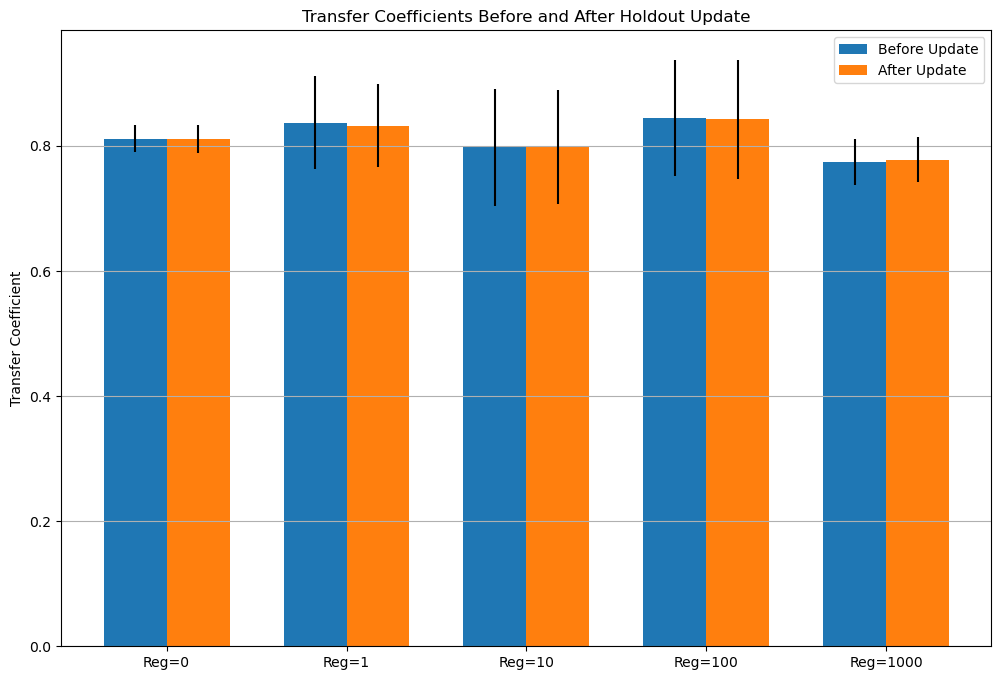

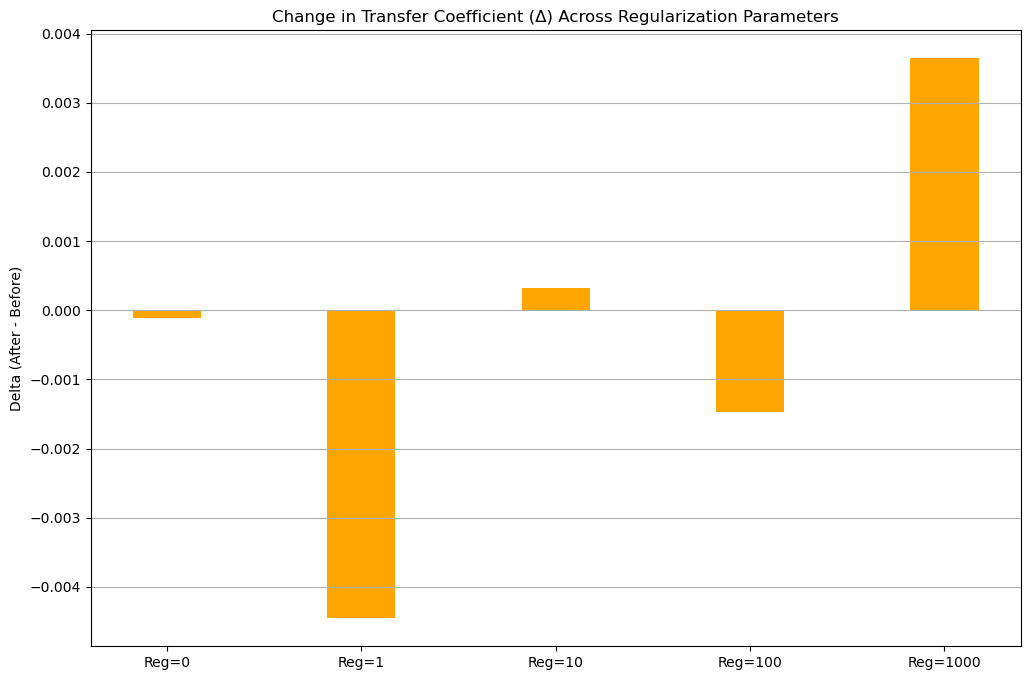

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Run multiple trials for different regularization parameters
def run_trials_and_plot(dx, dy, r, T, n, lr_phi, lr_g, num_steps, num_trials=5, reg_params=[0, 1, 10, 100, 1000]):
    trial_results = {reg_param: {"before": [], "after": []} for reg_param in reg_params}

    for reg_param in reg_params:
        print(f"Running trials for reg_param={reg_param}...")
        for trial in range(num_trials):
            print(f"Trial {trial + 1}/{num_trials}")
            _, _, transfer_coeff_before, transfer_coeff_after, _, _, _, _ = experiment(
                dx, dy, r, T, n, lr_phi, lr_g, num_steps, reg_param=reg_param
            )
            trial_results[reg_param]["before"].append(transfer_coeff_before)
            trial_results[reg_param]["after"].append(transfer_coeff_after)

    # Compute deltas and plot
    reg_param_means = []
    reg_param_stds = []
    deltas = []

    for reg_param in reg_params:
        before_mean = np.mean(trial_results[reg_param]["before"])
        after_mean = np.mean(trial_results[reg_param]["after"])
        delta = after_mean - before_mean
        reg_param_means.append((before_mean, after_mean))
        deltas.append(delta)
        reg_param_stds.append(
            (
                np.std(trial_results[reg_param]["before"]),
                np.std(trial_results[reg_param]["after"]),
            )
        )

    # Bar plot for before and after transfer coefficients
    x = np.arange(len(reg_params))
    bar_width = 0.35
    before_means = [mean[0] for mean in reg_param_means]
    after_means = [mean[1] for mean in reg_param_means]

    plt.figure(figsize=(12, 8))
    plt.bar(x - bar_width / 2, before_means, bar_width, label="Before Update", yerr=[std[0] for std in reg_param_stds])
    plt.bar(x + bar_width / 2, after_means, bar_width, label="After Update", yerr=[std[1] for std in reg_param_stds])
    plt.xticks(x, [f"Reg={param}" for param in reg_params])
    plt.ylabel("Transfer Coefficient")
    plt.title("Transfer Coefficients Before and After Holdout Update")
    plt.legend()
    plt.grid(axis="y")
    plt.show()

    # Plot deltas for each regularization parameter
    plt.figure(figsize=(12, 8))
    plt.bar(x, deltas, color="orange", width=bar_width)
    plt.xticks(x, [f"Reg={param}" for param in reg_params])
    plt.ylabel("Delta (After - Before)")
    plt.title("Change in Transfer Coefficient (Δ) Across Regularization Parameters")
    plt.grid(axis="y")
    plt.show()

# Run the function
dx, dy, r = 50, 15, 5
T = 10
n = 320
lr_phi = 0.01
lr_g = 0.001
num_steps = 100

run_trials_and_plot(dx, dy, r, T, n, lr_phi, lr_g, num_steps, num_trials=5, reg_params=[0, 1, 10, 100, 1000])


Running trials for reg_param=0...
  Trial 1/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.26it/s]


Regularizations Mean: 1.064161, Standard Deviation: 0.025271
Final G Train Loss: 0.6672239303588867
Transfer Coefficient BEFORE: 0.88239001823666; AFTER: 0.8819910482226928
Avg Train Excess Risks BEFORE: 0.3280118405818939; Avg Train Excess Risk AFTER: 0.3275536000728607
Test Excess Risks BEFORE: 0.37173113226890564; Test Excess Risk AFTER: 0.3713797330856323
  Trial 2/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.51it/s]


Regularizations Mean: 1.015470, Standard Deviation: 0.002768
Final G Train Loss: 0.13659442961215973
Transfer Coefficient BEFORE: 0.8223953932903737; AFTER: 0.8246018306439995
Avg Train Excess Risks BEFORE: 0.1695147603750229; Avg Train Excess Risk AFTER: 0.1476414054632187
Test Excess Risks BEFORE: 0.20612318813800812; Test Excess Risk AFTER: 0.1790456920862198
  Trial 3/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.48it/s]


Regularizations Mean: 1.024638, Standard Deviation: 0.031785
Final G Train Loss: 0.19520655274391174
Transfer Coefficient BEFORE: 0.9389423469573509; AFTER: 0.9386339497313303
Avg Train Excess Risks BEFORE: 0.45500659942626953; Avg Train Excess Risk AFTER: 0.4543207883834839
Test Excess Risks BEFORE: 0.48459482192993164; Test Excess Risk AFTER: 0.48402339220046997
  Trial 4/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.02it/s]


Regularizations Mean: 0.737018, Standard Deviation: 0.004343
Final G Train Loss: 0.9141466021537781
Transfer Coefficient BEFORE: 0.9026878642716527; AFTER: 0.9029480852146164
Avg Train Excess Risks BEFORE: 0.30193933844566345; Avg Train Excess Risk AFTER: 0.3013170063495636
Test Excess Risks BEFORE: 0.33448919653892517; Test Excess Risk AFTER: 0.33370357751846313
  Trial 5/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 16.78it/s]


Regularizations Mean: 1.004578, Standard Deviation: 0.003749
Final G Train Loss: 0.07507660984992981
Transfer Coefficient BEFORE: 0.8452972316342906; AFTER: 0.8366971905202076
Avg Train Excess Risks BEFORE: 0.12189801782369614; Avg Train Excess Risk AFTER: 0.11841106414794922
Test Excess Risks BEFORE: 0.14420728385448456; Test Excess Risk AFTER: 0.14152200520038605
  Trial 6/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.65it/s]


Regularizations Mean: 1.035811, Standard Deviation: 0.011503
Final G Train Loss: 0.4341581463813782
Transfer Coefficient BEFORE: 0.8357150438617003; AFTER: 0.8295640888615612
Avg Train Excess Risks BEFORE: 0.2508443593978882; Avg Train Excess Risk AFTER: 0.20522291958332062
Test Excess Risks BEFORE: 0.300155371427536; Test Excess Risk AFTER: 0.24738645553588867
  Trial 7/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.17it/s]


Regularizations Mean: 0.883896, Standard Deviation: 0.000000
Final G Train Loss: 0.7924380898475647
Transfer Coefficient BEFORE: 0.9164182748237711; AFTER: 0.9166607019375944
Avg Train Excess Risks BEFORE: 0.44077351689338684; Avg Train Excess Risk AFTER: 0.4400642216205597
Test Excess Risks BEFORE: 0.4809741675853729; Test Excess Risk AFTER: 0.4800731837749481
  Trial 8/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 16.56it/s]


Regularizations Mean: 0.925720, Standard Deviation: 0.000000
Final G Train Loss: 0.353861540555954
Transfer Coefficient BEFORE: 0.7986114437292104; AFTER: 0.7980477839209064
Avg Train Excess Risks BEFORE: 0.30212095379829407; Avg Train Excess Risk AFTER: 0.23768983781337738
Test Excess Risks BEFORE: 0.3783078193664551; Test Excess Risk AFTER: 0.29783910512924194
  Trial 9/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.69it/s]


Regularizations Mean: 0.846614, Standard Deviation: 0.000000
Final G Train Loss: 0.6854932308197021
Transfer Coefficient BEFORE: 0.731145328558958; AFTER: 0.7306998908874782
Avg Train Excess Risks BEFORE: 0.306250661611557; Avg Train Excess Risk AFTER: 0.3059743642807007
Test Excess Risks BEFORE: 0.41886427998542786; Test Excess Risk AFTER: 0.41874149441719055
  Trial 10/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.70it/s]


Regularizations Mean: 0.821088, Standard Deviation: 0.017435
Final G Train Loss: 0.9295783042907715
Transfer Coefficient BEFORE: 0.751719858516922; AFTER: 0.750609008775775
Avg Train Excess Risks BEFORE: 0.38082367181777954; Avg Train Excess Risk AFTER: 0.3801908493041992
Test Excess Risks BEFORE: 0.5066031813621521; Test Excess Risk AFTER: 0.5065098404884338
  Trial 11/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.68it/s]


Regularizations Mean: 1.023363, Standard Deviation: 0.028816
Final G Train Loss: 0.3869371712207794
Transfer Coefficient BEFORE: 0.8363344791973503; AFTER: 0.835763412252295
Avg Train Excess Risks BEFORE: 0.38787972927093506; Avg Train Excess Risk AFTER: 0.3873020112514496
Test Excess Risks BEFORE: 0.46378540992736816; Test Excess Risk AFTER: 0.4634110629558563
  Trial 12/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 16.43it/s]


Regularizations Mean: 1.001508, Standard Deviation: 0.008264
Final G Train Loss: 0.3170333802700043
Transfer Coefficient BEFORE: 0.824639752928847; AFTER: 0.8194066858396677
Avg Train Excess Risks BEFORE: 0.1448761373758316; Avg Train Excess Risk AFTER: 0.1373661309480667
Test Excess Risks BEFORE: 0.1756841540336609; Test Excess Risk AFTER: 0.16764096915721893
  Trial 13/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 16.68it/s]


Regularizations Mean: 0.943981, Standard Deviation: 0.006606
Final G Train Loss: 0.17201745510101318
Transfer Coefficient BEFORE: 0.7927299751399033; AFTER: 0.7919447187046085
Avg Train Excess Risks BEFORE: 0.2577854096889496; Avg Train Excess Risk AFTER: 0.2569256126880646
Test Excess Risks BEFORE: 0.32518690824508667; Test Excess Risk AFTER: 0.3244236707687378
  Trial 14/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.82it/s]


Regularizations Mean: 0.887872, Standard Deviation: 0.000000
Final G Train Loss: 0.7524605393409729
Transfer Coefficient BEFORE: 0.7806267667842479; AFTER: 0.7798774649874317
Avg Train Excess Risks BEFORE: 0.20110374689102173; Avg Train Excess Risk AFTER: 0.20066383481025696
Test Excess Risks BEFORE: 0.2576183080673218; Test Excess Risk AFTER: 0.2573017477989197
  Trial 15/20


Training Steps: 100%|██████████| 100/100 [00:12<00:00,  7.98it/s]


Regularizations Mean: 0.846188, Standard Deviation: 0.000000
Final G Train Loss: 0.4739556908607483
Transfer Coefficient BEFORE: 0.7832674622930332; AFTER: 0.7835365251966943
Avg Train Excess Risks BEFORE: 0.279727578163147; Avg Train Excess Risk AFTER: 0.27923738956451416
Test Excess Risks BEFORE: 0.3571290671825409; Test Excess Risk AFTER: 0.356380820274353
  Trial 16/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.12it/s]


Regularizations Mean: 0.847517, Standard Deviation: 0.000000
Final G Train Loss: 0.7413104772567749
Transfer Coefficient BEFORE: 1.0015990749710466; AFTER: 1.0031063378794844
Avg Train Excess Risks BEFORE: 0.3876955211162567; Avg Train Excess Risk AFTER: 0.38697460293769836
Test Excess Risks BEFORE: 0.38707655668258667; Test Excess Risk AFTER: 0.38577625155448914
  Trial 17/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.77it/s]


Regularizations Mean: 1.041936, Standard Deviation: 0.014677
Final G Train Loss: 0.42157214879989624
Transfer Coefficient BEFORE: 0.8445523687090021; AFTER: 0.8438588461669159
Avg Train Excess Risks BEFORE: 0.37935885787010193; Avg Train Excess Risk AFTER: 0.378922700881958
Test Excess Risks BEFORE: 0.4491833448410034; Test Excess Risk AFTER: 0.44903564453125
  Trial 18/20


Training Steps: 100%|██████████| 100/100 [00:11<00:00,  9.02it/s]


Regularizations Mean: 1.011383, Standard Deviation: 0.027905
Final G Train Loss: 0.4522671103477478
Transfer Coefficient BEFORE: 0.6998533094676634; AFTER: 0.6994663145531544
Avg Train Excess Risks BEFORE: 0.363397479057312; Avg Train Excess Risk AFTER: 0.36285120248794556
Test Excess Risks BEFORE: 0.5192480683326721; Test Excess Risk AFTER: 0.5187543630599976
  Trial 19/20


Training Steps: 100%|██████████| 100/100 [00:09<00:00, 10.00it/s]


Regularizations Mean: 1.008461, Standard Deviation: 0.002226
Final G Train Loss: 0.12340987473726273
Transfer Coefficient BEFORE: 0.79771112810975; AFTER: 0.7965600927974447
Avg Train Excess Risks BEFORE: 0.19436898827552795; Avg Train Excess Risk AFTER: 0.1699865460395813
Test Excess Risks BEFORE: 0.24365836381912231; Test Excess Risk AFTER: 0.21340078115463257
  Trial 20/20


Training Steps: 100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


Regularizations Mean: 0.895710, Standard Deviation: 0.000000
Final G Train Loss: 0.33780020475387573
Transfer Coefficient BEFORE: 0.8206447047354603; AFTER: 0.8151475220179399
Avg Train Excess Risks BEFORE: 0.4051187336444855; Avg Train Excess Risk AFTER: 0.3670538663864136
Test Excess Risks BEFORE: 0.493659108877182; Test Excess Risk AFTER: 0.45029133558273315
Running trials for reg_param=1...
  Trial 1/20


Training Steps: 100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


Regularizations Mean: 0.964026, Standard Deviation: 0.015151
Final G Train Loss: 0.5109825730323792
Transfer Coefficient BEFORE: 0.8454575643068158; AFTER: 0.8457419781030237
Avg Train Excess Risks BEFORE: 0.4461539089679718; Avg Train Excess Risk AFTER: 0.4456504285335541
Test Excess Risks BEFORE: 0.527707040309906; Test Excess Risk AFTER: 0.5269342660903931
  Trial 2/20


Training Steps: 100%|██████████| 100/100 [00:09<00:00, 10.47it/s]


Regularizations Mean: 0.839164, Standard Deviation: 0.000000
Final G Train Loss: 0.7658611536026001
Transfer Coefficient BEFORE: 0.767966645587063; AFTER: 0.7681463653140667
Avg Train Excess Risks BEFORE: 0.28327229619026184; Avg Train Excess Risk AFTER: 0.2829388380050659
Test Excess Risks BEFORE: 0.3688601553440094; Test Excess Risk AFTER: 0.36833974719047546
  Trial 3/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 16.66it/s]


Regularizations Mean: 0.864718, Standard Deviation: 0.000041
Final G Train Loss: 0.6609570384025574
Transfer Coefficient BEFORE: 0.7409622518430933; AFTER: 0.7408666091286937
Avg Train Excess Risks BEFORE: 0.25907161831855774; Avg Train Excess Risk AFTER: 0.2510162591934204
Test Excess Risks BEFORE: 0.3496421277523041; Test Excess Risk AFTER: 0.338814377784729
  Trial 4/20


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 20.17it/s]


Regularizations Mean: 1.015491, Standard Deviation: 0.002606
Final G Train Loss: 0.16249142587184906
Transfer Coefficient BEFORE: 0.8137641497943098; AFTER: 0.820852932217351
Avg Train Excess Risks BEFORE: 0.18517103791236877; Avg Train Excess Risk AFTER: 0.16286927461624146
Test Excess Risks BEFORE: 0.2275487780570984; Test Excess Risk AFTER: 0.19841468334197998
  Trial 5/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 16.06it/s]


Regularizations Mean: 0.882346, Standard Deviation: 0.000000
Final G Train Loss: 0.6827588081359863
Transfer Coefficient BEFORE: 0.9436623425196727; AFTER: 0.9443299028247794
Avg Train Excess Risks BEFORE: 0.6283134818077087; Avg Train Excess Risk AFTER: 0.6275801658630371
Test Excess Risks BEFORE: 0.6658244729042053; Test Excess Risk AFTER: 0.6645772457122803
  Trial 6/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.39it/s]


Regularizations Mean: 0.852827, Standard Deviation: 0.000000
Final G Train Loss: 0.853771448135376
Transfer Coefficient BEFORE: 0.8462535560155927; AFTER: 0.8465531665200242
Avg Train Excess Risks BEFORE: 0.32140520215034485; Avg Train Excess Risk AFTER: 0.3206652104854584
Test Excess Risks BEFORE: 0.3797977566719055; Test Excess Risk AFTER: 0.3787892162799835
  Trial 7/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.55it/s]


Regularizations Mean: 1.135353, Standard Deviation: 0.025266
Final G Train Loss: 0.41877445578575134
Transfer Coefficient BEFORE: 0.8267408403611659; AFTER: 0.825872149342812
Avg Train Excess Risks BEFORE: 0.2885112464427948; Avg Train Excess Risk AFTER: 0.2880028486251831
Test Excess Risks BEFORE: 0.34897422790527344; Test Excess Risk AFTER: 0.34872570633888245
  Trial 8/20


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 20.97it/s]


Regularizations Mean: 1.012623, Standard Deviation: 0.003825
Final G Train Loss: 0.11416930705308914
Transfer Coefficient BEFORE: 0.7669911686268107; AFTER: 0.7780906012116676
Avg Train Excess Risks BEFORE: 0.19767515361309052; Avg Train Excess Risk AFTER: 0.16841831803321838
Test Excess Risks BEFORE: 0.25772807002067566; Test Excess Risk AFTER: 0.2164507806301117
  Trial 9/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.73it/s]


Regularizations Mean: 1.066588, Standard Deviation: 0.010896
Final G Train Loss: 0.8828281760215759
Transfer Coefficient BEFORE: 0.8903789600597017; AFTER: 0.8878152887712907
Avg Train Excess Risks BEFORE: 0.40773463249206543; Avg Train Excess Risk AFTER: 0.3543113172054291
Test Excess Risks BEFORE: 0.45793381333351135; Test Excess Risk AFTER: 0.3990822434425354
  Trial 10/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.78it/s]


Regularizations Mean: 1.016505, Standard Deviation: 0.002158
Final G Train Loss: 0.18756885826587677
Transfer Coefficient BEFORE: 0.7276746047328556; AFTER: 0.7202875984839969
Avg Train Excess Risks BEFORE: 0.13525015115737915; Avg Train Excess Risk AFTER: 0.12536770105361938
Test Excess Risks BEFORE: 0.18586625158786774; Test Excess Risk AFTER: 0.17405228316783905
  Trial 11/20


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 20.22it/s]


Regularizations Mean: 0.899672, Standard Deviation: 0.000000
Final G Train Loss: 0.6130571961402893
Transfer Coefficient BEFORE: 0.8110424721858402; AFTER: 0.8112427297021143
Avg Train Excess Risks BEFORE: 0.24649855494499207; Avg Train Excess Risk AFTER: 0.2460823357105255
Test Excess Risks BEFORE: 0.30392804741859436; Test Excess Risk AFTER: 0.30333995819091797
  Trial 12/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.24it/s]


Regularizations Mean: 1.020742, Standard Deviation: 0.015418
Final G Train Loss: 0.23748452961444855
Transfer Coefficient BEFORE: 0.9447004808484126; AFTER: 0.9454112001331129
Avg Train Excess Risks BEFORE: 0.22359545528888702; Avg Train Excess Risk AFTER: 0.2235192209482193
Test Excess Risks BEFORE: 0.23668396472930908; Test Excess Risk AFTER: 0.23642539978027344
  Trial 13/20


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 20.93it/s]


Regularizations Mean: 1.020186, Standard Deviation: 0.003258
Final G Train Loss: 0.25268760323524475
Transfer Coefficient BEFORE: 0.7535154431854587; AFTER: 0.7497481984078422
Avg Train Excess Risks BEFORE: 0.11888153105974197; Avg Train Excess Risk AFTER: 0.11349523067474365
Test Excess Risks BEFORE: 0.15776920318603516; Test Excess Risk AFTER: 0.15137779712677002
  Trial 14/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 16.82it/s]


Regularizations Mean: 0.903098, Standard Deviation: 0.000002
Final G Train Loss: 0.37945541739463806
Transfer Coefficient BEFORE: 0.780324747669833; AFTER: 0.7859825050924785
Avg Train Excess Risks BEFORE: 0.32053348422050476; Avg Train Excess Risk AFTER: 0.25847119092941284
Test Excess Risks BEFORE: 0.41076934337615967; Test Excess Risk AFTER: 0.3288510739803314
  Trial 15/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.04it/s]


Regularizations Mean: 1.038626, Standard Deviation: 0.002923
Final G Train Loss: 0.3758564591407776
Transfer Coefficient BEFORE: 0.8821944432822992; AFTER: 0.8838730787678065
Avg Train Excess Risks BEFORE: 0.1432802677154541; Avg Train Excess Risk AFTER: 0.13955281674861908
Test Excess Risks BEFORE: 0.16241347789764404; Test Excess Risk AFTER: 0.15788784623146057
  Trial 16/20


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 21.81it/s]


Regularizations Mean: 1.041077, Standard Deviation: 0.005927
Final G Train Loss: 0.4794203042984009
Transfer Coefficient BEFORE: 0.6424706614414243; AFTER: 0.6448204739382181
Avg Train Excess Risks BEFORE: 0.32610762119293213; Avg Train Excess Risk AFTER: 0.3253360092639923
Test Excess Risks BEFORE: 0.5075836777687073; Test Excess Risk AFTER: 0.5045373439788818
  Trial 17/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.36it/s]


Regularizations Mean: 0.801902, Standard Deviation: 0.006169
Final G Train Loss: 0.5859107971191406
Transfer Coefficient BEFORE: 0.7074057602864325; AFTER: 0.7082178585006659
Avg Train Excess Risks BEFORE: 0.3168114721775055; Avg Train Excess Risk AFTER: 0.3167203664779663
Test Excess Risks BEFORE: 0.44784972071647644; Test Excess Risk AFTER: 0.4472075402736664
  Trial 18/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 16.82it/s]


Regularizations Mean: 1.009720, Standard Deviation: 0.006489
Final G Train Loss: 0.16651786863803864
Transfer Coefficient BEFORE: 0.7723633113681134; AFTER: 0.7770899754398204
Avg Train Excess Risks BEFORE: 0.13814985752105713; Avg Train Excess Risk AFTER: 0.12854330241680145
Test Excess Risks BEFORE: 0.1788664162158966; Test Excess Risk AFTER: 0.16541624069213867
  Trial 19/20


Training Steps: 100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


Regularizations Mean: 1.157191, Standard Deviation: 0.038669
Final G Train Loss: 0.5360944271087646
Transfer Coefficient BEFORE: 0.6930727442283726; AFTER: 0.6922565522205727
Avg Train Excess Risks BEFORE: 0.2060953974723816; Avg Train Excess Risk AFTER: 0.20589855313301086
Test Excess Risks BEFORE: 0.297364741563797; Test Excess Risk AFTER: 0.29743099212646484
  Trial 20/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 16.89it/s]


Regularizations Mean: 1.177482, Standard Deviation: 0.008277
Final G Train Loss: 0.521120548248291
Transfer Coefficient BEFORE: 0.8276149467299452; AFTER: 0.8278754269570047
Avg Train Excess Risks BEFORE: 0.3105836808681488; Avg Train Excess Risk AFTER: 0.3102806508541107
Test Excess Risks BEFORE: 0.375275582075119; Test Excess Risk AFTER: 0.3747914731502533
Running trials for reg_param=2...
  Trial 1/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.59it/s]


Regularizations Mean: 1.080065, Standard Deviation: 0.009616
Final G Train Loss: 0.3494514524936676
Transfer Coefficient BEFORE: 0.6513125007746109; AFTER: 0.6524684992426928
Avg Train Excess Risks BEFORE: 0.41346603631973267; Avg Train Excess Risk AFTER: 0.4127257168292999
Test Excess Risks BEFORE: 0.634819746017456; Test Excess Risk AFTER: 0.6325603723526001
  Trial 2/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.65it/s]


Regularizations Mean: 1.086590, Standard Deviation: 0.016962
Final G Train Loss: 0.8208005428314209
Transfer Coefficient BEFORE: 0.7626941079248749; AFTER: 0.7620632633572125
Avg Train Excess Risks BEFORE: 0.35063865780830383; Avg Train Excess Risk AFTER: 0.35009878873825073
Test Excess Risks BEFORE: 0.4597369432449341; Test Excess Risk AFTER: 0.45940908789634705
  Trial 3/20


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 20.78it/s]


Regularizations Mean: 1.200904, Standard Deviation: 0.009604
Final G Train Loss: 0.7954345345497131
Transfer Coefficient BEFORE: 0.7972761282858097; AFTER: 0.7969400105908162
Avg Train Excess Risks BEFORE: 0.4237922132015228; Avg Train Excess Risk AFTER: 0.42321810126304626
Test Excess Risks BEFORE: 0.5315501093864441; Test Excess Risk AFTER: 0.531053900718689
  Trial 4/20


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.83it/s]


Regularizations Mean: 1.001736, Standard Deviation: 0.003447
Final G Train Loss: 0.0445774681866169
Transfer Coefficient BEFORE: 0.7186844851406023; AFTER: 0.719580233070507
Avg Train Excess Risks BEFORE: 0.10132130980491638; Avg Train Excess Risk AFTER: 0.1004277691245079
Test Excess Risks BEFORE: 0.14098162949085236; Test Excess Risk AFTER: 0.1395643800497055
  Trial 5/20


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.17it/s]


Regularizations Mean: 1.246806, Standard Deviation: 0.015731
Final G Train Loss: 1.261171817779541
Transfer Coefficient BEFORE: 0.8733195386222857; AFTER: 0.8721877256687665
Avg Train Excess Risks BEFORE: 0.3553600609302521; Avg Train Excess Risk AFTER: 0.3550877869129181
Test Excess Risks BEFORE: 0.40690726041793823; Test Excess Risk AFTER: 0.4071231186389923
  Trial 6/20


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 21.37it/s]


Regularizations Mean: 1.049705, Standard Deviation: 0.010401
Final G Train Loss: 0.5848482847213745
Transfer Coefficient BEFORE: 0.8249818441497575; AFTER: 0.8207344527324218
Avg Train Excess Risks BEFORE: 0.12175813317298889; Avg Train Excess Risk AFTER: 0.11906441301107407
Test Excess Risks BEFORE: 0.14758886396884918; Test Excess Risk AFTER: 0.14507056772708893
  Trial 7/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 16.71it/s]


Regularizations Mean: 1.008090, Standard Deviation: 0.003738
Final G Train Loss: 0.13080281019210815
Transfer Coefficient BEFORE: 0.7491598324604578; AFTER: 0.7431779528511679
Avg Train Excess Risks BEFORE: 0.1376306265592575; Avg Train Excess Risk AFTER: 0.12851527333259583
Test Excess Risks BEFORE: 0.18371330201625824; Test Excess Risk AFTER: 0.1729266494512558
  Trial 8/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.79it/s]


Regularizations Mean: 0.997128, Standard Deviation: 0.021132
Final G Train Loss: 0.19725105166435242
Transfer Coefficient BEFORE: 0.7355350530647028; AFTER: 0.734498203463049
Avg Train Excess Risks BEFORE: 0.21833406388759613; Avg Train Excess Risk AFTER: 0.21777814626693726
Test Excess Risks BEFORE: 0.29683706164360046; Test Excess Risk AFTER: 0.29649922251701355
  Trial 9/20


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 21.95it/s]


Regularizations Mean: 1.042990, Standard Deviation: 0.023583
Final G Train Loss: 0.38317161798477173
Transfer Coefficient BEFORE: 0.8069085558956711; AFTER: 0.8072454486815377
Avg Train Excess Risks BEFORE: 0.3126088082790375; Avg Train Excess Risk AFTER: 0.31236332654953003
Test Excess Risks BEFORE: 0.38741540908813477; Test Excess Risk AFTER: 0.3869496285915375
  Trial 10/20


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 21.00it/s]


Regularizations Mean: 0.996378, Standard Deviation: 0.003363
Final G Train Loss: 0.3348994553089142
Transfer Coefficient BEFORE: 0.6822355470343923; AFTER: 0.6782956141591261
Avg Train Excess Risks BEFORE: 0.2642401456832886; Avg Train Excess Risk AFTER: 0.2548938989639282
Test Excess Risks BEFORE: 0.38731512427330017; Test Excess Risk AFTER: 0.37578585743904114
  Trial 11/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.70it/s]


Regularizations Mean: 1.020075, Standard Deviation: 0.006064
Final G Train Loss: 0.23526409268379211
Transfer Coefficient BEFORE: 0.8244281421948464; AFTER: 0.8251844907909264
Avg Train Excess Risks BEFORE: 0.1348644644021988; Avg Train Excess Risk AFTER: 0.1323757767677307
Test Excess Risks BEFORE: 0.16358546912670135; Test Excess Risk AFTER: 0.16041961312294006
  Trial 12/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.36it/s]


Regularizations Mean: 1.256649, Standard Deviation: 0.031242
Final G Train Loss: 1.306443214416504
Transfer Coefficient BEFORE: 0.795199560344823; AFTER: 0.7953050244285154
Avg Train Excess Risks BEFORE: 0.5335116982460022; Avg Train Excess Risk AFTER: 0.5332726240158081
Test Excess Risks BEFORE: 0.6709154844284058; Test Excess Risk AFTER: 0.6705259084701538
  Trial 13/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.38it/s]


Regularizations Mean: 1.015226, Standard Deviation: 0.003545
Final G Train Loss: 0.17005303502082825
Transfer Coefficient BEFORE: 0.8528842993970889; AFTER: 0.86203171348006
Avg Train Excess Risks BEFORE: 0.12661513686180115; Avg Train Excess Risk AFTER: 0.12382035702466965
Test Excess Risks BEFORE: 0.14845523238182068; Test Excess Risk AFTER: 0.14363782107830048
  Trial 14/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 14.22it/s]


Regularizations Mean: 1.012909, Standard Deviation: 0.002459
Final G Train Loss: 0.11855892837047577
Transfer Coefficient BEFORE: 0.7859599144999663; AFTER: 0.7881381563799268
Avg Train Excess Risks BEFORE: 0.12333595752716064; Avg Train Excess Risk AFTER: 0.11532441526651382
Test Excess Risks BEFORE: 0.15692397952079773; Test Excess Risk AFTER: 0.14632512629032135
  Trial 15/20


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 11.52it/s]


Regularizations Mean: 0.994121, Standard Deviation: 0.006277
Final G Train Loss: 0.07337954640388489
Transfer Coefficient BEFORE: 0.7481522990534213; AFTER: 0.7459307353195663
Avg Train Excess Risks BEFORE: 0.14087311923503876; Avg Train Excess Risk AFTER: 0.13148051500320435
Test Excess Risks BEFORE: 0.18829470872879028; Test Excess Risk AFTER: 0.1762637048959732
  Trial 16/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.52it/s]


Regularizations Mean: 0.859647, Standard Deviation: 0.000000
Final G Train Loss: 0.45879197120666504
Transfer Coefficient BEFORE: 0.8441025061047239; AFTER: 0.8431992490442695
Avg Train Excess Risks BEFORE: 0.3287557065486908; Avg Train Excess Risk AFTER: 0.328205943107605
Test Excess Risks BEFORE: 0.38947367668151855; Test Excess Risk AFTER: 0.3892388939857483
  Trial 17/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.60it/s]


Regularizations Mean: 0.739128, Standard Deviation: 0.000000
Final G Train Loss: 1.629961609840393
Transfer Coefficient BEFORE: 0.7571418143413593; AFTER: 0.7572191381580998
Avg Train Excess Risks BEFORE: 0.31159335374832153; Avg Train Excess Risk AFTER: 0.3113492727279663
Test Excess Risks BEFORE: 0.4115389585494995; Test Excess Risk AFTER: 0.41117459535598755
  Trial 18/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.54it/s]


Regularizations Mean: 1.074197, Standard Deviation: 0.006203
Final G Train Loss: 0.4754621386528015
Transfer Coefficient BEFORE: 0.7888131477126794; AFTER: 0.7887460149976943
Avg Train Excess Risks BEFORE: 0.25871461629867554; Avg Train Excess Risk AFTER: 0.2583349943161011
Test Excess Risks BEFORE: 0.32797959446907043; Test Excess Risk AFTER: 0.3275262117385864
  Trial 19/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 16.61it/s]


Regularizations Mean: 1.014216, Standard Deviation: 0.001608
Final G Train Loss: 0.15784312784671783
Transfer Coefficient BEFORE: 0.8459666745229466; AFTER: 0.8350898540578717
Avg Train Excess Risks BEFORE: 0.14034566283226013; Avg Train Excess Risk AFTER: 0.1303272545337677
Test Excess Risks BEFORE: 0.16589975357055664; Test Excess Risk AFTER: 0.1560637503862381
  Trial 20/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 16.64it/s]


Regularizations Mean: 0.848398, Standard Deviation: 0.006913
Final G Train Loss: 0.591972291469574
Transfer Coefficient BEFORE: 0.7581542878889295; AFTER: 0.7544507309986507
Avg Train Excess Risks BEFORE: 0.18809042870998383; Avg Train Excess Risk AFTER: 0.16331274807453156
Test Excess Risks BEFORE: 0.24808990955352783; Test Excess Risk AFTER: 0.2164657562971115
Running trials for reg_param=4...
  Trial 1/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 16.03it/s]


Regularizations Mean: 1.049141, Standard Deviation: 0.031740
Final G Train Loss: 0.5450536608695984
Transfer Coefficient BEFORE: 0.824024355298528; AFTER: 0.8237610466466018
Avg Train Excess Risks BEFORE: 0.392339825630188; Avg Train Excess Risk AFTER: 0.39148011803627014
Test Excess Risks BEFORE: 0.476126492023468; Test Excess Risk AFTER: 0.4752350449562073
  Trial 2/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.49it/s]


Regularizations Mean: 1.008470, Standard Deviation: 0.004502
Final G Train Loss: 0.14040318131446838
Transfer Coefficient BEFORE: 0.8303497165219832; AFTER: 0.8083156736676257
Avg Train Excess Risks BEFORE: 0.25283390283584595; Avg Train Excess Risk AFTER: 0.20066022872924805
Test Excess Risks BEFORE: 0.304490864276886; Test Excess Risk AFTER: 0.24824488162994385
  Trial 3/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.17it/s]


Regularizations Mean: 0.943836, Standard Deviation: 0.001822
Final G Train Loss: 0.5700808763504028
Transfer Coefficient BEFORE: 0.7663753590754686; AFTER: 0.7668896956447879
Avg Train Excess Risks BEFORE: 0.19036823511123657; Avg Train Excess Risk AFTER: 0.18989978730678558
Test Excess Risks BEFORE: 0.24840077757835388; Test Excess Risk AFTER: 0.24762333929538727
  Trial 4/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.55it/s]


Regularizations Mean: 1.149486, Standard Deviation: 0.008331
Final G Train Loss: 0.5542539954185486
Transfer Coefficient BEFORE: 0.7618487377059101; AFTER: 0.761780659776931
Avg Train Excess Risks BEFORE: 0.22811810672283173; Avg Train Excess Risk AFTER: 0.2278476506471634
Test Excess Risks BEFORE: 0.2994270324707031; Test Excess Risk AFTER: 0.29909875988960266
  Trial 5/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.45it/s]


Regularizations Mean: 1.045399, Standard Deviation: 0.013042
Final G Train Loss: 0.4622277617454529
Transfer Coefficient BEFORE: 0.920539769100752; AFTER: 0.9202615500786989
Avg Train Excess Risks BEFORE: 0.3821128010749817; Avg Train Excess Risk AFTER: 0.38161617517471313
Test Excess Risks BEFORE: 0.4150964617729187; Test Excess Risk AFTER: 0.4146822988986969
  Trial 6/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.61it/s]


Regularizations Mean: 0.792683, Standard Deviation: 0.017307
Final G Train Loss: 0.6899117231369019
Transfer Coefficient BEFORE: 0.8107163156484584; AFTER: 0.8106369767581173
Avg Train Excess Risks BEFORE: 0.31201472878456116; Avg Train Excess Risk AFTER: 0.31134137511253357
Test Excess Risks BEFORE: 0.384863018989563; Test Excess Risk AFTER: 0.3840700387954712
  Trial 7/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.83it/s]


Regularizations Mean: 1.030514, Standard Deviation: 0.003685
Final G Train Loss: 0.3236517608165741
Transfer Coefficient BEFORE: 0.7948052859040156; AFTER: 0.7904117874191443
Avg Train Excess Risks BEFORE: 0.3349801301956177; Avg Train Excess Risk AFTER: 0.27574872970581055
Test Excess Risks BEFORE: 0.42146188020706177; Test Excess Risk AFTER: 0.34886717796325684
  Trial 8/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.42it/s]


Regularizations Mean: 0.872525, Standard Deviation: 0.000000
Final G Train Loss: 0.4839116036891937
Transfer Coefficient BEFORE: 0.7267108389359128; AFTER: 0.7277117866844447
Avg Train Excess Risks BEFORE: 0.4435974359512329; Avg Train Excess Risk AFTER: 0.3924506902694702
Test Excess Risks BEFORE: 0.6104180812835693; Test Excess Risk AFTER: 0.5392941236495972
  Trial 9/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.20it/s]


Regularizations Mean: 1.017491, Standard Deviation: 0.029184
Final G Train Loss: 0.17764131724834442
Transfer Coefficient BEFORE: 0.8210995410295597; AFTER: 0.8215319109807248
Avg Train Excess Risks BEFORE: 0.4229380488395691; Avg Train Excess Risk AFTER: 0.4228236675262451
Test Excess Risks BEFORE: 0.5150874257087708; Test Excess Risk AFTER: 0.514677107334137
  Trial 10/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.82it/s]


Regularizations Mean: 1.021874, Standard Deviation: 0.002270
Final G Train Loss: 0.32290399074554443
Transfer Coefficient BEFORE: 0.8008232382740299; AFTER: 0.7992846800866902
Avg Train Excess Risks BEFORE: 0.18492405116558075; Avg Train Excess Risk AFTER: 0.17092834413051605
Test Excess Risks BEFORE: 0.23091743886470795; Test Excess Risk AFTER: 0.21385164558887482
  Trial 11/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.89it/s]


Regularizations Mean: 0.815512, Standard Deviation: 0.011507
Final G Train Loss: 0.5927807688713074
Transfer Coefficient BEFORE: 0.9468710217461082; AFTER: 0.9464664173297751
Avg Train Excess Risks BEFORE: 0.27298128604888916; Avg Train Excess Risk AFTER: 0.27296948432922363
Test Excess Risks BEFORE: 0.28829827904701233; Test Excess Risk AFTER: 0.2884090542793274
  Trial 12/20


Training Steps: 100%|██████████| 100/100 [00:24<00:00,  4.04it/s]


Regularizations Mean: 0.832430, Standard Deviation: 0.000000
Final G Train Loss: 0.4616299867630005
Transfer Coefficient BEFORE: 0.6882402823027242; AFTER: 0.6872591036192749
Avg Train Excess Risks BEFORE: 0.2915855050086975; Avg Train Excess Risk AFTER: 0.2909778952598572
Test Excess Risks BEFORE: 0.42366817593574524; Test Excess Risk AFTER: 0.42338892817497253
  Trial 13/20


Training Steps: 100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


Regularizations Mean: 1.012587, Standard Deviation: 0.003720
Final G Train Loss: 0.22240909934043884
Transfer Coefficient BEFORE: 0.7596377275741314; AFTER: 0.7644028810543695
Avg Train Excess Risks BEFORE: 0.16051706671714783; Avg Train Excess Risk AFTER: 0.1453116089105606
Test Excess Risks BEFORE: 0.21130739152431488; Test Excess Risk AFTER: 0.19009819626808167
  Trial 14/20


Training Steps: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


Regularizations Mean: 1.068180, Standard Deviation: 0.006464
Final G Train Loss: 0.24543586373329163
Transfer Coefficient BEFORE: 0.8444061567954748; AFTER: 0.8455395946496754
Avg Train Excess Risks BEFORE: 0.2465779185295105; Avg Train Excess Risk AFTER: 0.2461801916360855
Test Excess Risks BEFORE: 0.29201340675354004; Test Excess Risk AFTER: 0.29115158319473267
  Trial 15/20


Training Steps: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Regularizations Mean: 1.008474, Standard Deviation: 0.001506
Final G Train Loss: 0.07945665717124939
Transfer Coefficient BEFORE: 0.7334199166686238; AFTER: 0.7291762736623119
Avg Train Excess Risks BEFORE: 0.11912506073713303; Avg Train Excess Risk AFTER: 0.11573965102434158
Test Excess Risks BEFORE: 0.16242408752441406; Test Excess Risk AFTER: 0.15872657299041748
  Trial 16/20


Training Steps: 100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


Regularizations Mean: 0.834570, Standard Deviation: 0.016372
Final G Train Loss: 0.789199948310852
Transfer Coefficient BEFORE: 0.7872016769965038; AFTER: 0.7892022748621965
Avg Train Excess Risks BEFORE: 0.3528054356575012; Avg Train Excess Risk AFTER: 0.35263824462890625
Test Excess Risks BEFORE: 0.44817668199539185; Test Excess Risk AFTER: 0.4468287229537964
  Trial 17/20


Training Steps: 100%|██████████| 100/100 [00:10<00:00,  9.63it/s]


Regularizations Mean: 1.056145, Standard Deviation: 0.005543
Final G Train Loss: 0.6246337294578552
Transfer Coefficient BEFORE: 0.8348271811567509; AFTER: 0.8349840945062482
Avg Train Excess Risks BEFORE: 0.273400217294693; Avg Train Excess Risk AFTER: 0.27276626229286194
Test Excess Risks BEFORE: 0.32749319076538086; Test Excess Risk AFTER: 0.32667240500450134
  Trial 18/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 16.37it/s]


Regularizations Mean: 1.063159, Standard Deviation: 0.037327
Final G Train Loss: 0.5526283979415894
Transfer Coefficient BEFORE: 0.8941104261537934; AFTER: 0.8931019224665748
Avg Train Excess Risks BEFORE: 0.4327516555786133; Avg Train Excess Risk AFTER: 0.4318941533565521
Test Excess Risks BEFORE: 0.4840024709701538; Test Excess Risk AFTER: 0.4835888743400574
  Trial 19/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.56it/s]


Regularizations Mean: 1.031957, Standard Deviation: 0.007673
Final G Train Loss: 0.34356051683425903
Transfer Coefficient BEFORE: 0.8355262234265726; AFTER: 0.8356212787739579
Avg Train Excess Risks BEFORE: 0.4327717125415802; Avg Train Excess Risk AFTER: 0.43231236934661865
Test Excess Risks BEFORE: 0.5179630517959595; Test Excess Risk AFTER: 0.517354428768158
  Trial 20/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.45it/s]


Regularizations Mean: 0.883715, Standard Deviation: 0.000000
Final G Train Loss: 0.3927304148674011
Transfer Coefficient BEFORE: 0.7838213578094975; AFTER: 0.7835126950303827
Avg Train Excess Risks BEFORE: 0.37883251905441284; Avg Train Excess Risk AFTER: 0.3782790005207062
Test Excess Risks BEFORE: 0.4833148717880249; Test Excess Risk AFTER: 0.48279881477355957
Running trials for reg_param=6...
  Trial 1/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.51it/s]


Regularizations Mean: 0.888391, Standard Deviation: 0.000000
Final G Train Loss: 0.6492116451263428
Transfer Coefficient BEFORE: 0.9647735567642942; AFTER: 0.9640528933240283
Avg Train Excess Risks BEFORE: 0.5006409883499146; Avg Train Excess Risk AFTER: 0.5000414252281189
Test Excess Risks BEFORE: 0.5189207196235657; Test Excess Risk AFTER: 0.5186867117881775
  Trial 2/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 16.28it/s]


Regularizations Mean: 1.044471, Standard Deviation: 0.002718
Final G Train Loss: 0.34350037574768066
Transfer Coefficient BEFORE: 0.7865951932500306; AFTER: 0.7797210780402181
Avg Train Excess Risks BEFORE: 0.20819969475269318; Avg Train Excess Risk AFTER: 0.18981267511844635
Test Excess Risks BEFORE: 0.26468467712402344; Test Excess Risk AFTER: 0.24343663454055786
  Trial 3/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.08it/s]


Regularizations Mean: 1.068013, Standard Deviation: 0.011791
Final G Train Loss: 0.5497965812683105
Transfer Coefficient BEFORE: 0.8857435114407299; AFTER: 0.8726240282166796
Avg Train Excess Risks BEFORE: 0.31733933091163635; Avg Train Excess Risk AFTER: 0.2621942162513733
Test Excess Risks BEFORE: 0.35827451944351196; Test Excess Risk AFTER: 0.3004664182662964
  Trial 4/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.08it/s]


Regularizations Mean: 1.322109, Standard Deviation: 0.007430
Final G Train Loss: 2.073143720626831
Transfer Coefficient BEFORE: 0.7300223748755973; AFTER: 0.7289591413006871
Avg Train Excess Risks BEFORE: 0.256186842918396; Avg Train Excess Risk AFTER: 0.25028303265571594
Test Excess Risks BEFORE: 0.3509301245212555; Test Excess Risk AFTER: 0.34334301948547363
  Trial 5/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.24it/s]


Regularizations Mean: 1.018767, Standard Deviation: 0.004632
Final G Train Loss: 0.23463724553585052
Transfer Coefficient BEFORE: 0.8801103025770823; AFTER: 0.8791914072466213
Avg Train Excess Risks BEFORE: 0.43773186206817627; Avg Train Excess Risk AFTER: 0.4199335277080536
Test Excess Risks BEFORE: 0.4973602294921875; Test Excess Risk AFTER: 0.47763606905937195
  Trial 6/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.91it/s]


Regularizations Mean: 0.897379, Standard Deviation: 0.000000
Final G Train Loss: 0.8007152676582336
Transfer Coefficient BEFORE: 0.9549394771593865; AFTER: 0.9510959238546418
Avg Train Excess Risks BEFORE: 0.3397500514984131; Avg Train Excess Risk AFTER: 0.3142865002155304
Test Excess Risks BEFORE: 0.35578176379203796; Test Excess Risk AFTER: 0.33044669032096863
  Trial 7/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 16.26it/s]


Regularizations Mean: 0.857568, Standard Deviation: 0.000000
Final G Train Loss: 0.3179922103881836
Transfer Coefficient BEFORE: 0.8011644953353504; AFTER: 0.8296722719133803
Avg Train Excess Risks BEFORE: 0.2538655698299408; Avg Train Excess Risk AFTER: 0.21173572540283203
Test Excess Risks BEFORE: 0.31687071919441223; Test Excess Risk AFTER: 0.25520405173301697
  Trial 8/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.32it/s]


Regularizations Mean: 0.849331, Standard Deviation: 0.000000
Final G Train Loss: 0.35291969776153564
Transfer Coefficient BEFORE: 0.870952128107641; AFTER: 0.8714945972034592
Avg Train Excess Risks BEFORE: 0.2742420434951782; Avg Train Excess Risk AFTER: 0.2736956477165222
Test Excess Risks BEFORE: 0.31487613916397095; Test Excess Risk AFTER: 0.31405317783355713
  Trial 9/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.45it/s]


Regularizations Mean: 1.048219, Standard Deviation: 0.003197
Final G Train Loss: 0.6614404320716858
Transfer Coefficient BEFORE: 0.722127897721572; AFTER: 0.7211907366427132
Avg Train Excess Risks BEFORE: 0.33697980642318726; Avg Train Excess Risk AFTER: 0.33604323863983154
Test Excess Risks BEFORE: 0.4666483700275421; Test Excess Risk AFTER: 0.4659561216831207
  Trial 10/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.66it/s]


Regularizations Mean: 1.004820, Standard Deviation: 0.007002
Final G Train Loss: 0.15409502387046814
Transfer Coefficient BEFORE: 0.6783790125063762; AFTER: 0.6791159062186078
Avg Train Excess Risks BEFORE: 0.15889300405979156; Avg Train Excess Risk AFTER: 0.1404384970664978
Test Excess Risks BEFORE: 0.23422452807426453; Test Excess Risk AFTER: 0.2067960649728775
  Trial 11/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.81it/s]


Regularizations Mean: 0.974583, Standard Deviation: 0.015803
Final G Train Loss: 0.3362962603569031
Transfer Coefficient BEFORE: 0.8338743849020271; AFTER: 0.8339941468096334
Avg Train Excess Risks BEFORE: 0.21887964010238647; Avg Train Excess Risk AFTER: 0.21836665272712708
Test Excess Risks BEFORE: 0.262485146522522; Test Excess Risk AFTER: 0.2618323564529419
  Trial 12/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.58it/s]


Regularizations Mean: 1.018995, Standard Deviation: 0.011830
Final G Train Loss: 0.21799668669700623
Transfer Coefficient BEFORE: 0.8945342368383912; AFTER: 0.8940223067795473
Avg Train Excess Risks BEFORE: 0.3743852972984314; Avg Train Excess Risk AFTER: 0.3738406300544739
Test Excess Risks BEFORE: 0.4185253977775574; Test Excess Risk AFTER: 0.41815581917762756
  Trial 13/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.61it/s]


Regularizations Mean: 0.898516, Standard Deviation: 0.010158
Final G Train Loss: 0.4082796275615692
Transfer Coefficient BEFORE: 0.9661489374128689; AFTER: 0.9739834714661776
Avg Train Excess Risks BEFORE: 0.45355838537216187; Avg Train Excess Risk AFTER: 0.330634742975235
Test Excess Risks BEFORE: 0.4694497585296631; Test Excess Risk AFTER: 0.33946648240089417
  Trial 14/20


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 12.18it/s]


Regularizations Mean: 1.129588, Standard Deviation: 0.013542
Final G Train Loss: 0.5962864756584167
Transfer Coefficient BEFORE: 0.775059291248638; AFTER: 0.7751672227710629
Avg Train Excess Risks BEFORE: 0.3502306342124939; Avg Train Excess Risk AFTER: 0.34966737031936646
Test Excess Risks BEFORE: 0.4518759250640869; Test Excess Risk AFTER: 0.4510863721370697
  Trial 15/20


Training Steps: 100%|██████████| 100/100 [00:12<00:00,  7.99it/s]


Regularizations Mean: 1.022815, Standard Deviation: 0.002960
Final G Train Loss: 0.30914783477783203
Transfer Coefficient BEFORE: 0.8151004545386885; AFTER: 0.8159447754188723
Avg Train Excess Risks BEFORE: 0.17951485514640808; Avg Train Excess Risk AFTER: 0.16218945384025574
Test Excess Risks BEFORE: 0.22023648023605347; Test Excess Risk AFTER: 0.1987750381231308
  Trial 16/20


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 11.62it/s]


Regularizations Mean: 1.223333, Standard Deviation: 0.029127
Final G Train Loss: 0.851783037185669
Transfer Coefficient BEFORE: 0.7563783597187209; AFTER: 0.7559650660729189
Avg Train Excess Risks BEFORE: 0.24585485458374023; Avg Train Excess Risk AFTER: 0.24546606838703156
Test Excess Risks BEFORE: 0.32504215836524963; Test Excess Risk AFTER: 0.324705570936203
  Trial 17/20


Training Steps: 100%|██████████| 100/100 [00:10<00:00,  9.15it/s]


Regularizations Mean: 1.021837, Standard Deviation: 0.011589
Final G Train Loss: 0.2093859612941742
Transfer Coefficient BEFORE: 0.6908957136364162; AFTER: 0.6896411389792457
Avg Train Excess Risks BEFORE: 0.28318479657173157; Avg Train Excess Risk AFTER: 0.2824089527130127
Test Excess Risks BEFORE: 0.409880667924881; Test Excess Risk AFTER: 0.409501314163208
  Trial 18/20


Training Steps: 100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


Regularizations Mean: 0.869191, Standard Deviation: 0.000000
Final G Train Loss: 0.41954073309898376
Transfer Coefficient BEFORE: 0.7660555133054407; AFTER: 0.7653156175504254
Avg Train Excess Risks BEFORE: 0.2524977922439575; Avg Train Excess Risk AFTER: 0.25219598412513733
Test Excess Risks BEFORE: 0.32960769534111023; Test Excess Risk AFTER: 0.3295319974422455
  Trial 19/20


Training Steps: 100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


Regularizations Mean: 1.035387, Standard Deviation: 0.007321
Final G Train Loss: 0.48157408833503723
Transfer Coefficient BEFORE: 0.7472167432033339; AFTER: 0.7481537281708172
Avg Train Excess Risks BEFORE: 0.3253420293331146; Avg Train Excess Risk AFTER: 0.3249334692955017
Test Excess Risks BEFORE: 0.4354051649570465; Test Excess Risk AFTER: 0.4343137741088867
  Trial 20/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.57it/s]


Regularizations Mean: 1.019713, Standard Deviation: 0.009184
Final G Train Loss: 0.2131432145833969
Transfer Coefficient BEFORE: 0.7753618118041684; AFTER: 0.7749789195735634
Avg Train Excess Risks BEFORE: 0.40884333848953247; Avg Train Excess Risk AFTER: 0.40833818912506104
Test Excess Risks BEFORE: 0.5272936224937439; Test Excess Risk AFTER: 0.5269023180007935
Running trials for reg_param=8...
  Trial 1/20


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 12.45it/s]


Regularizations Mean: 0.748135, Standard Deviation: 0.000000
Final G Train Loss: 0.7632125020027161
Transfer Coefficient BEFORE: 0.8377189989297759; AFTER: 0.8382651197595501
Avg Train Excess Risks BEFORE: 0.23376785218715668; Avg Train Excess Risk AFTER: 0.2334960252046585
Test Excess Risks BEFORE: 0.27905282378196716; Test Excess Risk AFTER: 0.2785467505455017
  Trial 2/20


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 12.47it/s]


Regularizations Mean: 1.050892, Standard Deviation: 0.010141
Final G Train Loss: 0.1340155452489853
Transfer Coefficient BEFORE: 0.7451722313144747; AFTER: 0.7406170671755712
Avg Train Excess Risks BEFORE: 0.18385270237922668; Avg Train Excess Risk AFTER: 0.16563403606414795
Test Excess Risks BEFORE: 0.24672511219978333; Test Excess Risk AFTER: 0.22364328801631927
  Trial 3/20


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 11.62it/s]


Regularizations Mean: 1.025810, Standard Deviation: 0.001961
Final G Train Loss: 0.2893414795398712
Transfer Coefficient BEFORE: 0.8598180332569614; AFTER: 0.8646691480657159
Avg Train Excess Risks BEFORE: 0.12291904538869858; Avg Train Excess Risk AFTER: 0.11814931780099869
Test Excess Risks BEFORE: 0.1429593712091446; Test Excess Risk AFTER: 0.13664107024669647
  Trial 4/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.29it/s]


Regularizations Mean: 1.150392, Standard Deviation: 0.026326
Final G Train Loss: 0.5609660148620605
Transfer Coefficient BEFORE: 0.9510744274601642; AFTER: 0.9507482445961614
Avg Train Excess Risks BEFORE: 0.3988126516342163; Avg Train Excess Risk AFTER: 0.39858123660087585
Test Excess Risks BEFORE: 0.4193285405635834; Test Excess Risk AFTER: 0.41922900080680847
  Trial 5/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.91it/s]


Regularizations Mean: 1.017015, Standard Deviation: 0.011346
Final G Train Loss: 0.16313964128494263
Transfer Coefficient BEFORE: 0.7629543131817046; AFTER: 0.7625973948762798
Avg Train Excess Risks BEFORE: 0.14495903253555298; Avg Train Excess Risk AFTER: 0.13456028699874878
Test Excess Risks BEFORE: 0.18999700248241425; Test Excess Risk AFTER: 0.1764499694108963
  Trial 6/20


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 12.43it/s]


Regularizations Mean: 0.977810, Standard Deviation: 0.005808
Final G Train Loss: 0.49523061513900757
Transfer Coefficient BEFORE: 0.8054843984661966; AFTER: 0.8067949331798924
Avg Train Excess Risks BEFORE: 0.41241830587387085; Avg Train Excess Risk AFTER: 0.4121863543987274
Test Excess Risks BEFORE: 0.512012779712677; Test Excess Risk AFTER: 0.5108935832977295
  Trial 7/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.03it/s]


Regularizations Mean: 1.027045, Standard Deviation: 0.003975
Final G Train Loss: 0.25369971990585327
Transfer Coefficient BEFORE: 0.7361655989876451; AFTER: 0.7485685906215312
Avg Train Excess Risks BEFORE: 0.16109003126621246; Avg Train Excess Risk AFTER: 0.14506886899471283
Test Excess Risks BEFORE: 0.21882309019565582; Test Excess Risk AFTER: 0.19379502534866333
  Trial 8/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.40it/s]


Regularizations Mean: 1.029514, Standard Deviation: 0.002274
Final G Train Loss: 0.6334311366081238
Transfer Coefficient BEFORE: 0.7191280462514237; AFTER: 0.7278360379719407
Avg Train Excess Risks BEFORE: 0.5793429613113403; Avg Train Excess Risk AFTER: 0.4640960693359375
Test Excess Risks BEFORE: 0.8056186437606812; Test Excess Risk AFTER: 0.6376382112503052
  Trial 9/20


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 12.44it/s]


Regularizations Mean: 1.026610, Standard Deviation: 0.010503
Final G Train Loss: 0.22987310588359833
Transfer Coefficient BEFORE: 0.7121398629264625; AFTER: 0.7318462963575131
Avg Train Excess Risks BEFORE: 0.5428299307823181; Avg Train Excess Risk AFTER: 0.4209457039833069
Test Excess Risks BEFORE: 0.7622518539428711; Test Excess Risk AFTER: 0.5751832127571106
  Trial 10/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.43it/s]


Regularizations Mean: 1.023609, Standard Deviation: 0.008974
Final G Train Loss: 0.17745675146579742
Transfer Coefficient BEFORE: 0.7866337069415664; AFTER: 0.7963320607829928
Avg Train Excess Risks BEFORE: 0.2005518078804016; Avg Train Excess Risk AFTER: 0.1672402173280716
Test Excess Risks BEFORE: 0.2549494206905365; Test Excess Risk AFTER: 0.21001316606998444
  Trial 11/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.27it/s]


Regularizations Mean: 1.057642, Standard Deviation: 0.021856
Final G Train Loss: 0.4215129315853119
Transfer Coefficient BEFORE: 0.9099172129155212; AFTER: 0.909758275141245
Avg Train Excess Risks BEFORE: 0.28003010153770447; Avg Train Excess Risk AFTER: 0.27978160977363586
Test Excess Risks BEFORE: 0.30775338411331177; Test Excess Risk AFTER: 0.30753400921821594
  Trial 12/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.61it/s]


Regularizations Mean: 1.019719, Standard Deviation: 0.001370
Final G Train Loss: 0.22909095883369446
Transfer Coefficient BEFORE: 0.7892214415638816; AFTER: 0.788277805536473
Avg Train Excess Risks BEFORE: 0.14582210779190063; Avg Train Excess Risk AFTER: 0.13482216000556946
Test Excess Risks BEFORE: 0.18476703763008118; Test Excess Risk AFTER: 0.1710338145494461
  Trial 13/20


Training Steps: 100%|██████████| 100/100 [00:09<00:00, 10.93it/s]


Regularizations Mean: 1.008619, Standard Deviation: 0.003053
Final G Train Loss: 0.10949243605136871
Transfer Coefficient BEFORE: 0.8660042177820582; AFTER: 0.8609644860554487
Avg Train Excess Risks BEFORE: 0.14231139421463013; Avg Train Excess Risk AFTER: 0.13455218076705933
Test Excess Risks BEFORE: 0.16433106362819672; Test Excess Risk AFTER: 0.1562807559967041
  Trial 14/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 14.25it/s]


Regularizations Mean: 0.716407, Standard Deviation: 0.000000
Final G Train Loss: 1.2027807235717773
Transfer Coefficient BEFORE: 0.6983229219741645; AFTER: 0.697398935231938
Avg Train Excess Risks BEFORE: 0.3723485469818115; Avg Train Excess Risk AFTER: 0.3718608617782593
Test Excess Risks BEFORE: 0.5332039594650269; Test Excess Risk AFTER: 0.5332111120223999
  Trial 15/20


Training Steps: 100%|██████████| 100/100 [00:09<00:00, 10.58it/s]


Regularizations Mean: 1.167404, Standard Deviation: 0.006733
Final G Train Loss: 0.6493152976036072
Transfer Coefficient BEFORE: 0.8403637938665668; AFTER: 0.8403119223423048
Avg Train Excess Risks BEFORE: 0.2643061876296997; Avg Train Excess Risk AFTER: 0.26385775208473206
Test Excess Risks BEFORE: 0.31451401114463806; Test Excess Risk AFTER: 0.3139997720718384
  Trial 16/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.74it/s]


Regularizations Mean: 1.033489, Standard Deviation: 0.034162
Final G Train Loss: 0.38141608238220215
Transfer Coefficient BEFORE: 0.7861086981334967; AFTER: 0.7856026690352328
Avg Train Excess Risks BEFORE: 0.38998258113861084; Avg Train Excess Risk AFTER: 0.3896453380584717
Test Excess Risks BEFORE: 0.49609243869781494; Test Excess Risk AFTER: 0.49598270654678345
  Trial 17/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.76it/s]


Regularizations Mean: 0.858465, Standard Deviation: 0.000000
Final G Train Loss: 0.7828320860862732
Transfer Coefficient BEFORE: 0.8957621263886036; AFTER: 0.8948364687182434
Avg Train Excess Risks BEFORE: 0.3302672803401947; Avg Train Excess Risk AFTER: 0.3291637599468231
Test Excess Risks BEFORE: 0.3686997592449188; Test Excess Risk AFTER: 0.3678479492664337
  Trial 18/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.44it/s]


Regularizations Mean: 0.941879, Standard Deviation: 0.002927
Final G Train Loss: 0.16491709649562836
Transfer Coefficient BEFORE: 0.8911490381173695; AFTER: 0.8922339888291643
Avg Train Excess Risks BEFORE: 0.2808414697647095; Avg Train Excess Risk AFTER: 0.2803305983543396
Test Excess Risks BEFORE: 0.315145343542099; Test Excess Risk AFTER: 0.3141895532608032
  Trial 19/20


Training Steps: 100%|██████████| 100/100 [00:09<00:00, 10.76it/s]


Regularizations Mean: 1.026512, Standard Deviation: 0.014558
Final G Train Loss: 0.24471807479858398
Transfer Coefficient BEFORE: 0.8101156711715757; AFTER: 0.8058965626310353
Avg Train Excess Risks BEFORE: 0.20672215521335602; Avg Train Excess Risk AFTER: 0.17696170508861542
Test Excess Risks BEFORE: 0.2551760971546173; Test Excess Risk AFTER: 0.2195836454629898
  Trial 20/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.81it/s]


Regularizations Mean: 0.870037, Standard Deviation: 0.000000
Final G Train Loss: 0.448542982339859
Transfer Coefficient BEFORE: 0.7480347399830669; AFTER: 0.7323587752829886
Avg Train Excess Risks BEFORE: 0.14191016554832458; Avg Train Excess Risk AFTER: 0.13601109385490417
Test Excess Risks BEFORE: 0.18971066176891327; Test Excess Risk AFTER: 0.18571648001670837
Running trials for reg_param=10...
  Trial 1/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.16it/s]


Regularizations Mean: 0.985332, Standard Deviation: 0.000000
Final G Train Loss: 0.43132489919662476
Transfer Coefficient BEFORE: 0.8633384101079048; AFTER: 0.8618772049815747
Avg Train Excess Risks BEFORE: 0.35354912281036377; Avg Train Excess Risk AFTER: 0.35317009687423706
Test Excess Risks BEFORE: 0.4095139503479004; Test Excess Risk AFTER: 0.4097684621810913
  Trial 2/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.59it/s]


Regularizations Mean: 1.028129, Standard Deviation: 0.025831
Final G Train Loss: 0.2373802810907364
Transfer Coefficient BEFORE: 0.7796849615902339; AFTER: 0.779562461907716
Avg Train Excess Risks BEFORE: 0.32038751244544983; Avg Train Excess Risk AFTER: 0.32001087069511414
Test Excess Risks BEFORE: 0.410919189453125; Test Excess Risk AFTER: 0.4105006158351898
  Trial 3/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 16.33it/s]


Regularizations Mean: 1.052724, Standard Deviation: 0.014283
Final G Train Loss: 0.5240211486816406
Transfer Coefficient BEFORE: 0.8000171397947315; AFTER: 0.8007199366877982
Avg Train Excess Risks BEFORE: 0.41258642077445984; Avg Train Excess Risk AFTER: 0.412314772605896
Test Excess Risks BEFORE: 0.5157219767570496; Test Excess Risk AFTER: 0.5149300694465637
  Trial 4/20


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 11.89it/s]


Regularizations Mean: 1.056270, Standard Deviation: 0.057565
Final G Train Loss: 0.3405515253543854
Transfer Coefficient BEFORE: 0.8270815275840097; AFTER: 0.8276168708772741
Avg Train Excess Risks BEFORE: 0.2976325750350952; Avg Train Excess Risk AFTER: 0.2974470853805542
Test Excess Risks BEFORE: 0.35985881090164185; Test Excess Risk AFTER: 0.3594019114971161
  Trial 5/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 14.02it/s]


Regularizations Mean: 1.031360, Standard Deviation: 0.018726
Final G Train Loss: 0.3152126967906952
Transfer Coefficient BEFORE: 0.827489823735037; AFTER: 0.8256177479864016
Avg Train Excess Risks BEFORE: 0.4255483150482178; Avg Train Excess Risk AFTER: 0.42501533031463623
Test Excess Risks BEFORE: 0.5142641067504883; Test Excess Risk AFTER: 0.5147846341133118
  Trial 6/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.65it/s]


Regularizations Mean: 1.279786, Standard Deviation: 0.008969
Final G Train Loss: 1.3821440935134888
Transfer Coefficient BEFORE: 0.6539905404985472; AFTER: 0.6538228142737331
Avg Train Excess Risks BEFORE: 0.25840818881988525; Avg Train Excess Risk AFTER: 0.2580060064792633
Test Excess Risks BEFORE: 0.39512526988983154; Test Excess Risk AFTER: 0.39461150765419006
  Trial 7/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.55it/s]


Regularizations Mean: 0.922814, Standard Deviation: 0.025722
Final G Train Loss: 0.476413756608963
Transfer Coefficient BEFORE: 0.6979950314051011; AFTER: 0.6983845975561865
Avg Train Excess Risks BEFORE: 0.33758804202079773; Avg Train Excess Risk AFTER: 0.33702871203422546
Test Excess Risks BEFORE: 0.4836539328098297; Test Excess Risk AFTER: 0.48258325457572937
  Trial 8/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.56it/s]


Regularizations Mean: 1.018278, Standard Deviation: 0.002653
Final G Train Loss: 0.20139040052890778
Transfer Coefficient BEFORE: 0.8413961799705405; AFTER: 0.8457934652780722
Avg Train Excess Risks BEFORE: 0.12403510510921478; Avg Train Excess Risk AFTER: 0.11832837015390396
Test Excess Risks BEFORE: 0.14741581678390503; Test Excess Risk AFTER: 0.13990220427513123
  Trial 9/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 14.27it/s]


Regularizations Mean: 0.864919, Standard Deviation: 0.000000
Final G Train Loss: 0.4818793535232544
Transfer Coefficient BEFORE: 0.8571205569663916; AFTER: 0.8575441654883015
Avg Train Excess Risks BEFORE: 0.4354422390460968; Avg Train Excess Risk AFTER: 0.43499618768692017
Test Excess Risks BEFORE: 0.5080291628837585; Test Excess Risk AFTER: 0.5072580575942993
  Trial 10/20


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 12.06it/s]


Regularizations Mean: 1.016831, Standard Deviation: 0.002730
Final G Train Loss: 0.26338624954223633
Transfer Coefficient BEFORE: 0.8544340254318792; AFTER: 0.8460656022306472
Avg Train Excess Risks BEFORE: 0.345655620098114; Avg Train Excess Risk AFTER: 0.28074944019317627
Test Excess Risks BEFORE: 0.40454337000846863; Test Excess Risk AFTER: 0.33182939887046814
  Trial 11/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 14.05it/s]


Regularizations Mean: 1.027760, Standard Deviation: 0.006683
Final G Train Loss: 0.2458595335483551
Transfer Coefficient BEFORE: 0.9164470170150188; AFTER: 0.9162883783537312
Avg Train Excess Risks BEFORE: 0.4101921319961548; Avg Train Excess Risk AFTER: 0.4096375107765198
Test Excess Risks BEFORE: 0.44758957624435425; Test Excess Risk AFTER: 0.44706177711486816
  Trial 12/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.58it/s]


Regularizations Mean: 0.901924, Standard Deviation: 0.000000
Final G Train Loss: 1.3771241903305054
Transfer Coefficient BEFORE: 0.8405410368796751; AFTER: 0.8400863100948176
Avg Train Excess Risks BEFORE: 0.29545220732688904; Avg Train Excess Risk AFTER: 0.2947872579097748
Test Excess Risks BEFORE: 0.3515024185180664; Test Excess Risk AFTER: 0.35090115666389465
  Trial 13/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 14.15it/s]


Regularizations Mean: 1.126278, Standard Deviation: 0.029989
Final G Train Loss: 0.43722668290138245
Transfer Coefficient BEFORE: 0.8761895651976366; AFTER: 0.8766304845396817
Avg Train Excess Risks BEFORE: 0.2183905839920044; Avg Train Excess Risk AFTER: 0.21787282824516296
Test Excess Risks BEFORE: 0.2492503821849823; Test Excess Risk AFTER: 0.2485343962907791
  Trial 14/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.61it/s]


Regularizations Mean: 0.794775, Standard Deviation: 0.009146
Final G Train Loss: 0.4370099902153015
Transfer Coefficient BEFORE: 0.7348891036824912; AFTER: 0.748840250086864
Avg Train Excess Risks BEFORE: 0.2127893567085266; Avg Train Excess Risk AFTER: 0.19744378328323364
Test Excess Risks BEFORE: 0.2895530164241791; Test Excess Risk AFTER: 0.2636660933494568
  Trial 15/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 14.21it/s]


Regularizations Mean: 0.869374, Standard Deviation: 0.000000
Final G Train Loss: 0.8689375519752502
Transfer Coefficient BEFORE: 0.6905512620827312; AFTER: 0.6905957312622016
Avg Train Excess Risks BEFORE: 0.5590993165969849; Avg Train Excess Risk AFTER: 0.558298647403717
Test Excess Risks BEFORE: 0.8096420168876648; Test Excess Risk AFTER: 0.8084304928779602
  Trial 16/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.87it/s]


Regularizations Mean: 1.021606, Standard Deviation: 0.003073
Final G Train Loss: 0.2450079470872879
Transfer Coefficient BEFORE: 0.7269585085064432; AFTER: 0.7269358622773959
Avg Train Excess Risks BEFORE: 0.3186820149421692; Avg Train Excess Risk AFTER: 0.31798651814460754
Test Excess Risks BEFORE: 0.43837717175483704; Test Excess Risk AFTER: 0.4374340772628784
  Trial 17/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.63it/s]


Regularizations Mean: 1.180674, Standard Deviation: 0.005681
Final G Train Loss: 0.6317017078399658
Transfer Coefficient BEFORE: 0.7246462508635105; AFTER: 0.7247484746152022
Avg Train Excess Risks BEFORE: 0.2697921693325043; Avg Train Excess Risk AFTER: 0.2693164050579071
Test Excess Risks BEFORE: 0.37230879068374634; Test Excess Risk AFTER: 0.37159982323646545
  Trial 18/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.50it/s]


Regularizations Mean: 1.008254, Standard Deviation: 0.003961
Final G Train Loss: 0.08283866941928864
Transfer Coefficient BEFORE: 0.8400620410448741; AFTER: 0.837267608345419
Avg Train Excess Risks BEFORE: 0.12197281420230865; Avg Train Excess Risk AFTER: 0.1179421991109848
Test Excess Risks BEFORE: 0.14519500732421875; Test Excess Risk AFTER: 0.14086559414863586
  Trial 19/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.58it/s]


Regularizations Mean: 0.876626, Standard Deviation: 0.000000
Final G Train Loss: 0.861452579498291
Transfer Coefficient BEFORE: 0.7406923105380432; AFTER: 0.7357127575811162
Avg Train Excess Risks BEFORE: 0.8377552628517151; Avg Train Excess Risk AFTER: 0.737497091293335
Test Excess Risks BEFORE: 1.131043553352356; Test Excess Risk AFTER: 1.0024253129959106
  Trial 20/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.49it/s]


Regularizations Mean: 0.842032, Standard Deviation: 0.000000
Final G Train Loss: 0.49438533186912537
Transfer Coefficient BEFORE: 0.7404491596005386; AFTER: 0.7396644915050123
Avg Train Excess Risks BEFORE: 0.2677896320819855; Avg Train Excess Risk AFTER: 0.26733919978141785
Test Excess Risks BEFORE: 0.36165836453437805; Test Excess Risk AFTER: 0.3614330589771271
Running trials for reg_param=15...
  Trial 1/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.92it/s]


Regularizations Mean: 0.988909, Standard Deviation: 0.010474
Final G Train Loss: 0.15983621776103973
Transfer Coefficient BEFORE: 0.7671594032414779; AFTER: 0.7665625156229521
Avg Train Excess Risks BEFORE: 0.19377544522285461; Avg Train Excess Risk AFTER: 0.19329693913459778
Test Excess Risks BEFORE: 0.2525882422924042; Test Excess Risk AFTER: 0.2521606981754303
  Trial 2/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.14it/s]


Regularizations Mean: 1.094082, Standard Deviation: 0.008896
Final G Train Loss: 0.2996596097946167
Transfer Coefficient BEFORE: 0.8459278240510307; AFTER: 0.8464727443087028
Avg Train Excess Risks BEFORE: 0.2278771996498108; Avg Train Excess Risk AFTER: 0.22755840420722961
Test Excess Risks BEFORE: 0.2693813741207123; Test Excess Risk AFTER: 0.268831342458725
  Trial 3/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.53it/s]


Regularizations Mean: 1.024304, Standard Deviation: 0.004804
Final G Train Loss: 0.1996726095676422
Transfer Coefficient BEFORE: 0.7982394175155524; AFTER: 0.8057986945640476
Avg Train Excess Risks BEFORE: 0.15455959737300873; Avg Train Excess Risk AFTER: 0.14324705302715302
Test Excess Risks BEFORE: 0.19362561404705048; Test Excess Risk AFTER: 0.17777027189731598
  Trial 4/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.60it/s]


Regularizations Mean: 1.047633, Standard Deviation: 0.034381
Final G Train Loss: 0.3856353461742401
Transfer Coefficient BEFORE: 0.710320948979682; AFTER: 0.7095744265554491
Avg Train Excess Risks BEFORE: 0.5033071637153625; Avg Train Excess Risk AFTER: 0.5027011036872864
Test Excess Risks BEFORE: 0.7085630297660828; Test Excess Risk AFTER: 0.7084543704986572
  Trial 5/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 16.71it/s]


Regularizations Mean: 0.875344, Standard Deviation: 0.000000
Final G Train Loss: 0.6448163986206055
Transfer Coefficient BEFORE: 0.761765095890461; AFTER: 0.7614856437522232
Avg Train Excess Risks BEFORE: 0.22376605868339539; Avg Train Excess Risk AFTER: 0.2232382595539093
Test Excess Risks BEFORE: 0.29374679923057556; Test Excess Risk AFTER: 0.2931614816188812
  Trial 6/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 14.15it/s]


Regularizations Mean: 0.858856, Standard Deviation: 0.000000
Final G Train Loss: 0.8151469826698303
Transfer Coefficient BEFORE: 0.8999544761820211; AFTER: 0.9001919920010335
Avg Train Excess Risks BEFORE: 0.4090525805950165; Avg Train Excess Risk AFTER: 0.4086940288543701
Test Excess Risks BEFORE: 0.4545258581638336; Test Excess Risk AFTER: 0.454007625579834
  Trial 7/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.79it/s]


Regularizations Mean: 0.861239, Standard Deviation: 0.000000
Final G Train Loss: 0.6305270791053772
Transfer Coefficient BEFORE: 0.8821128833287182; AFTER: 0.8818178486103567
Avg Train Excess Risks BEFORE: 0.2372494786977768; Avg Train Excess Risk AFTER: 0.23661106824874878
Test Excess Risks BEFORE: 0.26895591616630554; Test Excess Risk AFTER: 0.2683219313621521
  Trial 8/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.48it/s]


Regularizations Mean: 1.035834, Standard Deviation: 0.009653
Final G Train Loss: 0.4261779487133026
Transfer Coefficient BEFORE: 0.8534126242194461; AFTER: 0.8540793768741792
Avg Train Excess Risks BEFORE: 0.2828669846057892; Avg Train Excess Risk AFTER: 0.28256475925445557
Test Excess Risks BEFORE: 0.33145394921302795; Test Excess Risk AFTER: 0.3308413326740265
  Trial 9/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.12it/s]


Regularizations Mean: 1.004757, Standard Deviation: 0.003009
Final G Train Loss: 0.19844003021717072
Transfer Coefficient BEFORE: 0.7737138368479216; AFTER: 0.773421705413686
Avg Train Excess Risks BEFORE: 0.31832069158554077; Avg Train Excess Risk AFTER: 0.26793816685676575
Test Excess Risks BEFORE: 0.411419153213501; Test Excess Risk AFTER: 0.3464321792125702
  Trial 10/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.57it/s]


Regularizations Mean: 0.847594, Standard Deviation: 0.000000
Final G Train Loss: 0.6952815055847168
Transfer Coefficient BEFORE: 0.780364427279757; AFTER: 0.7802115166465915
Avg Train Excess Risks BEFORE: 0.2658401131629944; Avg Train Excess Risk AFTER: 0.2652401328086853
Test Excess Risks BEFORE: 0.34066149592399597; Test Excess Risk AFTER: 0.3399592638015747
  Trial 11/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.38it/s]


Regularizations Mean: 1.017321, Standard Deviation: 0.004259
Final G Train Loss: 0.1510895937681198
Transfer Coefficient BEFORE: 0.8322069050203499; AFTER: 0.8208533816473654
Avg Train Excess Risks BEFORE: 0.1537039875984192; Avg Train Excess Risk AFTER: 0.14305798709392548
Test Excess Risks BEFORE: 0.18469443917274475; Test Excess Risk AFTER: 0.17427958548069
  Trial 12/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.49it/s]


Regularizations Mean: 1.022155, Standard Deviation: 0.008485
Final G Train Loss: 0.27705469727516174
Transfer Coefficient BEFORE: 0.7867934720512515; AFTER: 0.787770212041364
Avg Train Excess Risks BEFORE: 0.3031158447265625; Avg Train Excess Risk AFTER: 0.3027747869491577
Test Excess Risks BEFORE: 0.3852546513080597; Test Excess Risk AFTER: 0.38434404134750366
  Trial 13/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.11it/s]


Regularizations Mean: 1.020642, Standard Deviation: 0.003126
Final G Train Loss: 0.4298378825187683
Transfer Coefficient BEFORE: 0.765800804196078; AFTER: 0.7753836469804012
Avg Train Excess Risks BEFORE: 0.1486685872077942; Avg Train Excess Risk AFTER: 0.13568401336669922
Test Excess Risks BEFORE: 0.19413480162620544; Test Excess Risk AFTER: 0.1749895215034485
  Trial 14/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.49it/s]


Regularizations Mean: 1.007149, Standard Deviation: 0.011361
Final G Train Loss: 0.06004970520734787
Transfer Coefficient BEFORE: 0.8646738571375749; AFTER: 0.8645316053893168
Avg Train Excess Risks BEFORE: 0.25577181577682495; Avg Train Excess Risk AFTER: 0.2554878294467926
Test Excess Risks BEFORE: 0.2958014905452728; Test Excess Risk AFTER: 0.29552167654037476
  Trial 15/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.62it/s]


Regularizations Mean: 1.013579, Standard Deviation: 0.003128
Final G Train Loss: 0.21917030215263367
Transfer Coefficient BEFORE: 0.8272288320657388; AFTER: 0.8255850691433607
Avg Train Excess Risks BEFORE: 0.12496253103017807; Avg Train Excess Risk AFTER: 0.11903209239244461
Test Excess Risks BEFORE: 0.15106162428855896; Test Excess Risk AFTER: 0.1441790759563446
  Trial 16/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.11it/s]


Regularizations Mean: 1.005829, Standard Deviation: 0.001709
Final G Train Loss: 0.023898381739854813
Transfer Coefficient BEFORE: 0.7208773173363076; AFTER: 0.7284031410479225
Avg Train Excess Risks BEFORE: 0.20610393583774567; Avg Train Excess Risk AFTER: 0.18136392533779144
Test Excess Risks BEFORE: 0.2859070897102356; Test Excess Risk AFTER: 0.24898838996887207
  Trial 17/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.60it/s]


Regularizations Mean: 1.011508, Standard Deviation: 0.004028
Final G Train Loss: 0.14244045317173004
Transfer Coefficient BEFORE: 0.7769892905522036; AFTER: 0.7776221431447278
Avg Train Excess Risks BEFORE: 0.15420672297477722; Avg Train Excess Risk AFTER: 0.14528271555900574
Test Excess Risks BEFORE: 0.19846698641777039; Test Excess Risk AFTER: 0.18682944774627686
  Trial 18/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 16.86it/s]


Regularizations Mean: 0.893650, Standard Deviation: 0.000000
Final G Train Loss: 0.9435964822769165
Transfer Coefficient BEFORE: 0.8159134573312038; AFTER: 0.816945226271913
Avg Train Excess Risks BEFORE: 0.3815068006515503; Avg Train Excess Risk AFTER: 0.3815201222896576
Test Excess Risks BEFORE: 0.46758243441581726; Test Excess Risk AFTER: 0.46700820326805115
  Trial 19/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.64it/s]


Regularizations Mean: 1.130441, Standard Deviation: 0.006675
Final G Train Loss: 0.3889031410217285
Transfer Coefficient BEFORE: 0.7334117189530542; AFTER: 0.7323934020385029
Avg Train Excess Risks BEFORE: 0.271798700094223; Avg Train Excess Risk AFTER: 0.27134212851524353
Test Excess Risks BEFORE: 0.37059497833251953; Test Excess Risk AFTER: 0.370486855506897
  Trial 20/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.76it/s]


Regularizations Mean: 0.944616, Standard Deviation: 0.000000
Final G Train Loss: 0.15871162712574005
Transfer Coefficient BEFORE: 0.8689697221992321; AFTER: 0.8684974768924116
Avg Train Excess Risks BEFORE: 0.3573353588581085; Avg Train Excess Risk AFTER: 0.35195809602737427
Test Excess Risks BEFORE: 0.41121727228164673; Test Excess Risk AFTER: 0.4052494168281555
Running trials for reg_param=20...
  Trial 1/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.90it/s]


Regularizations Mean: 1.094316, Standard Deviation: 0.014060
Final G Train Loss: 0.3774440884590149
Transfer Coefficient BEFORE: 0.7168073321993257; AFTER: 0.72364246261787
Avg Train Excess Risks BEFORE: 0.25323399901390076; Avg Train Excess Risk AFTER: 0.21827636659145355
Test Excess Risks BEFORE: 0.3532804250717163; Test Excess Risk AFTER: 0.30163565278053284
  Trial 2/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.94it/s]


Regularizations Mean: 0.903728, Standard Deviation: 0.000000
Final G Train Loss: 0.898323655128479
Transfer Coefficient BEFORE: 0.7836963933087303; AFTER: 0.7814499303361041
Avg Train Excess Risks BEFORE: 0.5474494695663452; Avg Train Excess Risk AFTER: 0.5470240712165833
Test Excess Risks BEFORE: 0.698547899723053; Test Excess Risk AFTER: 0.700011670589447
  Trial 3/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.75it/s]


Regularizations Mean: 0.851129, Standard Deviation: 0.000000
Final G Train Loss: 0.5620116591453552
Transfer Coefficient BEFORE: 1.119244170677308; AFTER: 1.1255308878573986
Avg Train Excess Risks BEFORE: 0.2511008679866791; Avg Train Excess Risk AFTER: 0.24728107452392578
Test Excess Risks BEFORE: 0.22434860467910767; Test Excess Risk AFTER: 0.21970172226428986
  Trial 4/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 14.02it/s]


Regularizations Mean: 1.048079, Standard Deviation: 0.013985
Final G Train Loss: 0.11786288022994995
Transfer Coefficient BEFORE: 0.7655232349622515; AFTER: 0.7663238206654409
Avg Train Excess Risks BEFORE: 0.37880900502204895; Avg Train Excess Risk AFTER: 0.37841448187828064
Test Excess Risks BEFORE: 0.4948367178440094; Test Excess Risk AFTER: 0.493804931640625
  Trial 5/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.83it/s]


Regularizations Mean: 0.885233, Standard Deviation: 0.000000
Final G Train Loss: 0.4015052914619446
Transfer Coefficient BEFORE: 0.8706798401110704; AFTER: 0.869053961823826
Avg Train Excess Risks BEFORE: 0.24771207571029663; Avg Train Excess Risk AFTER: 0.2470431625843048
Test Excess Risks BEFORE: 0.2845042049884796; Test Excess Risk AFTER: 0.28426676988601685
  Trial 6/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.09it/s]


Regularizations Mean: 0.768463, Standard Deviation: 0.012876
Final G Train Loss: 0.9362423419952393
Transfer Coefficient BEFORE: 0.7197908443211324; AFTER: 0.7049884671621381
Avg Train Excess Risks BEFORE: 0.43318524956703186; Avg Train Excess Risk AFTER: 0.3259984254837036
Test Excess Risks BEFORE: 0.6018210053443909; Test Excess Risk AFTER: 0.4624166786670685
  Trial 7/20


Training Steps: 100%|██████████| 100/100 [00:09<00:00, 10.56it/s]


Regularizations Mean: 1.027454, Standard Deviation: 0.004302
Final G Train Loss: 0.3159896433353424
Transfer Coefficient BEFORE: 0.8611593787405555; AFTER: 0.8540865175590968
Avg Train Excess Risks BEFORE: 0.12470158189535141; Avg Train Excess Risk AFTER: 0.11840775609016418
Test Excess Risks BEFORE: 0.1448066234588623; Test Excess Risk AFTER: 0.1386367231607437
  Trial 8/20


Training Steps: 100%|██████████| 100/100 [00:09<00:00, 10.02it/s]


Regularizations Mean: 0.697308, Standard Deviation: 0.017975
Final G Train Loss: 0.7650179266929626
Transfer Coefficient BEFORE: 0.7606238704751523; AFTER: 0.7591037938059828
Avg Train Excess Risks BEFORE: 0.2204446792602539; Avg Train Excess Risk AFTER: 0.2183743417263031
Test Excess Risks BEFORE: 0.2898208796977997; Test Excess Risk AFTER: 0.2876738905906677
  Trial 9/20


Training Steps: 100%|██████████| 100/100 [00:09<00:00, 10.07it/s]


Regularizations Mean: 0.846053, Standard Deviation: 0.000160
Final G Train Loss: 0.3473360240459442
Transfer Coefficient BEFORE: 0.808511875097052; AFTER: 0.7999792835390992
Avg Train Excess Risks BEFORE: 0.20746438205242157; Avg Train Excess Risk AFTER: 0.20312248170375824
Test Excess Risks BEFORE: 0.2566002905368805; Test Excess Risk AFTER: 0.2539096772670746
  Trial 10/20


Training Steps: 100%|██████████| 100/100 [00:11<00:00,  8.61it/s]


Regularizations Mean: 1.315112, Standard Deviation: 0.036295
Final G Train Loss: 1.8180553913116455
Transfer Coefficient BEFORE: 0.8191805285972014; AFTER: 0.8200973267665534
Avg Train Excess Risks BEFORE: 0.442234605550766; Avg Train Excess Risk AFTER: 0.4418325126171112
Test Excess Risks BEFORE: 0.5398499965667725; Test Excess Risk AFTER: 0.5387561917304993
  Trial 11/20


Training Steps: 100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Regularizations Mean: 0.892503, Standard Deviation: 0.004872
Final G Train Loss: 0.7996482849121094
Transfer Coefficient BEFORE: 0.9031256366105355; AFTER: 0.915229344039519
Avg Train Excess Risks BEFORE: 1.1388899087905884; Avg Train Excess Risk AFTER: 1.006871223449707
Test Excess Risks BEFORE: 1.2610536813735962; Test Excess Risk AFTER: 1.1001299619674683
  Trial 12/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.57it/s]


Regularizations Mean: 1.019366, Standard Deviation: 0.003652
Final G Train Loss: 0.22658313810825348
Transfer Coefficient BEFORE: 0.8783976154807095; AFTER: 0.8744466303695286
Avg Train Excess Risks BEFORE: 0.1952229142189026; Avg Train Excess Risk AFTER: 0.17752480506896973
Test Excess Risks BEFORE: 0.22224891185760498; Test Excess Risk AFTER: 0.20301388204097748
  Trial 13/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 16.17it/s]


Regularizations Mean: 1.013811, Standard Deviation: 0.004586
Final G Train Loss: 0.18062230944633484
Transfer Coefficient BEFORE: 0.7454103176263956; AFTER: 0.7447349225905366
Avg Train Excess Risks BEFORE: 0.2502199411392212; Avg Train Excess Risk AFTER: 0.24984624981880188
Test Excess Risks BEFORE: 0.3356808125972748; Test Excess Risk AFTER: 0.33548346161842346
  Trial 14/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.77it/s]


Regularizations Mean: 1.223989, Standard Deviation: 0.011254
Final G Train Loss: 0.9503533840179443
Transfer Coefficient BEFORE: 0.7796640288969964; AFTER: 0.7800943044077813
Avg Train Excess Risks BEFORE: 0.33316361904144287; Avg Train Excess Risk AFTER: 0.3330240249633789
Test Excess Risks BEFORE: 0.42731690406799316; Test Excess Risk AFTER: 0.42690226435661316
  Trial 15/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.24it/s]


Regularizations Mean: 0.855391, Standard Deviation: 0.002127
Final G Train Loss: 0.7993965148925781
Transfer Coefficient BEFORE: 0.7580693363620659; AFTER: 0.7582615739499925
Avg Train Excess Risks BEFORE: 0.2121226191520691; Avg Train Excess Risk AFTER: 0.19982798397541046
Test Excess Risks BEFORE: 0.2798195481300354; Test Excess Risk AFTER: 0.2635343670845032
  Trial 16/20


Training Steps: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Regularizations Mean: 1.018636, Standard Deviation: 0.022341
Final G Train Loss: 0.16669557988643646
Transfer Coefficient BEFORE: 0.7448875749816188; AFTER: 0.7437764945746371
Avg Train Excess Risks BEFORE: 0.3189907670021057; Avg Train Excess Risk AFTER: 0.318124920129776
Test Excess Risks BEFORE: 0.4282401502132416; Test Excess Risk AFTER: 0.4277157485485077
  Trial 17/20


Training Steps: 100%|██████████| 100/100 [00:24<00:00,  4.10it/s]


Regularizations Mean: 0.919166, Standard Deviation: 0.000000
Final G Train Loss: 1.0344774723052979
Transfer Coefficient BEFORE: 0.8480850714632396; AFTER: 0.8476531295204784
Avg Train Excess Risks BEFORE: 0.4216519594192505; Avg Train Excess Risk AFTER: 0.42122215032577515
Test Excess Risks BEFORE: 0.4971812069416046; Test Excess Risk AFTER: 0.49692749977111816
  Trial 18/20


Training Steps: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Regularizations Mean: 0.939922, Standard Deviation: 0.000000
Final G Train Loss: 0.8042417764663696
Transfer Coefficient BEFORE: 0.5631673216800563; AFTER: 0.5622421663191642
Avg Train Excess Risks BEFORE: 0.5664658546447754; Avg Train Excess Risk AFTER: 0.5654127597808838
Test Excess Risks BEFORE: 1.0058571100234985; Test Excess Risk AFTER: 1.0056391954421997
  Trial 19/20


Training Steps: 100%|██████████| 100/100 [00:11<00:00,  8.60it/s]


Regularizations Mean: 0.991485, Standard Deviation: 0.028837
Final G Train Loss: 0.4964926242828369
Transfer Coefficient BEFORE: 0.8827800273715919; AFTER: 0.8824046911952139
Avg Train Excess Risks BEFORE: 0.322397381067276; Avg Train Excess Risk AFTER: 0.32173019647598267
Test Excess Risks BEFORE: 0.36520692706108093; Test Excess Risk AFTER: 0.36460617184638977
  Trial 20/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.17it/s]


Regularizations Mean: 1.021954, Standard Deviation: 0.002859
Final G Train Loss: 0.37101003527641296
Transfer Coefficient BEFORE: 0.9045029818556615; AFTER: 0.9120199426757714
Avg Train Excess Risks BEFORE: 0.14478632807731628; Avg Train Excess Risk AFTER: 0.13758425414562225
Test Excess Risks BEFORE: 0.16007280349731445; Test Excess Risk AFTER: 0.1508566290140152
Running trials for reg_param=50...
  Trial 1/20


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 11.42it/s]


Regularizations Mean: 0.917036, Standard Deviation: 0.000000
Final G Train Loss: 0.9948102235794067
Transfer Coefficient BEFORE: 0.8083501726110396; AFTER: 0.8087403253126504
Avg Train Excess Risks BEFORE: 0.36855316162109375; Avg Train Excess Risk AFTER: 0.36834174394607544
Test Excess Risks BEFORE: 0.4559325575828552; Test Excess Risk AFTER: 0.45545119047164917
  Trial 2/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


Regularizations Mean: 0.893512, Standard Deviation: 0.000000
Final G Train Loss: 1.0040560960769653
Transfer Coefficient BEFORE: 0.722405242406734; AFTER: 0.7220036470247679
Avg Train Excess Risks BEFORE: 0.30137771368026733; Avg Train Excess Risk AFTER: 0.30112335085868835
Test Excess Risks BEFORE: 0.4171864986419678; Test Excess Risk AFTER: 0.4170662462711334
  Trial 3/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.63it/s]


Regularizations Mean: 1.020894, Standard Deviation: 0.003835
Final G Train Loss: 0.2640642523765564
Transfer Coefficient BEFORE: 0.8242630214428345; AFTER: 0.829728062471049
Avg Train Excess Risks BEFORE: 0.19049641489982605; Avg Train Excess Risk AFTER: 0.16799595952033997
Test Excess Risks BEFORE: 0.23111119866371155; Test Excess Risk AFTER: 0.20247110724449158
  Trial 4/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.63it/s]


Regularizations Mean: 1.041022, Standard Deviation: 0.019691
Final G Train Loss: 0.2255953848361969
Transfer Coefficient BEFORE: 0.8630207714060382; AFTER: 0.8645541149894465
Avg Train Excess Risks BEFORE: 0.2546035647392273; Avg Train Excess Risk AFTER: 0.23633143305778503
Test Excess Risks BEFORE: 0.2950144112110138; Test Excess Risk AFTER: 0.27335643768310547
  Trial 5/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.16it/s]


Regularizations Mean: 0.963156, Standard Deviation: 0.009725
Final G Train Loss: 0.31516337394714355
Transfer Coefficient BEFORE: 0.7328263649406183; AFTER: 0.7324711869040098
Avg Train Excess Risks BEFORE: 0.24227173626422882; Avg Train Excess Risk AFTER: 0.2417978197336197
Test Excess Risks BEFORE: 0.3305990993976593; Test Excess Risk AFTER: 0.33011239767074585
  Trial 6/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.04it/s]


Regularizations Mean: 0.886550, Standard Deviation: 0.000000
Final G Train Loss: 0.4473661780357361
Transfer Coefficient BEFORE: 0.890886404598904; AFTER: 0.890041970947092
Avg Train Excess Risks BEFORE: 0.40916886925697327; Avg Train Excess Risk AFTER: 0.4079194664955139
Test Excess Risks BEFORE: 0.45928287506103516; Test Excess Risk AFTER: 0.4583148658275604
  Trial 7/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.12it/s]


Regularizations Mean: 1.020236, Standard Deviation: 0.002563
Final G Train Loss: 0.2617458701133728
Transfer Coefficient BEFORE: 0.8909930053807067; AFTER: 0.8954027051604699
Avg Train Excess Risks BEFORE: 0.1773630529642105; Avg Train Excess Risk AFTER: 0.16177597641944885
Test Excess Risks BEFORE: 0.19906222820281982; Test Excess Risk AFTER: 0.1806739866733551
  Trial 8/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.56it/s]


Regularizations Mean: 1.017428, Standard Deviation: 0.003946
Final G Train Loss: 0.2270524501800537
Transfer Coefficient BEFORE: 0.8366597037220467; AFTER: 0.8333692437987401
Avg Train Excess Risks BEFORE: 0.17480123043060303; Avg Train Excess Risk AFTER: 0.16299140453338623
Test Excess Risks BEFORE: 0.20892751216888428; Test Excess Risk AFTER: 0.19558125734329224
  Trial 9/20


Training Steps: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Regularizations Mean: 1.022468, Standard Deviation: 0.003195
Final G Train Loss: 0.2506883442401886
Transfer Coefficient BEFORE: 0.7357230319049674; AFTER: 0.7340247757031665
Avg Train Excess Risks BEFORE: 0.11467501521110535; Avg Train Excess Risk AFTER: 0.11203013360500336
Test Excess Risks BEFORE: 0.1558670997619629; Test Excess Risk AFTER: 0.1526244580745697
  Trial 10/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.84it/s]


Regularizations Mean: 0.938181, Standard Deviation: 0.013989
Final G Train Loss: 0.5951207876205444
Transfer Coefficient BEFORE: 0.9242331057619005; AFTER: 0.9235250355622097
Avg Train Excess Risks BEFORE: 0.3896384835243225; Avg Train Excess Risk AFTER: 0.38915884494781494
Test Excess Risks BEFORE: 0.42158031463623047; Test Excess Risk AFTER: 0.42138418555259705
  Trial 11/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.36it/s]


Regularizations Mean: 1.005246, Standard Deviation: 0.002311
Final G Train Loss: 0.06390050798654556
Transfer Coefficient BEFORE: 0.8472808698697792; AFTER: 0.8494681362909906
Avg Train Excess Risks BEFORE: 0.28232336044311523; Avg Train Excess Risk AFTER: 0.24204036593437195
Test Excess Risks BEFORE: 0.3332110643386841; Test Excess Risk AFTER: 0.28493165969848633
  Trial 12/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.63it/s]


Regularizations Mean: 0.872295, Standard Deviation: 0.009892
Final G Train Loss: 0.4019840359687805
Transfer Coefficient BEFORE: 0.7467301788010828; AFTER: 0.7470668380904445
Avg Train Excess Risks BEFORE: 0.38128045201301575; Avg Train Excess Risk AFTER: 0.3809433877468109
Test Excess Risks BEFORE: 0.5106000304222107; Test Excess Risk AFTER: 0.509918749332428
  Trial 13/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.51it/s]


Regularizations Mean: 1.093564, Standard Deviation: 0.017125
Final G Train Loss: 6.891141891479492
Transfer Coefficient BEFORE: 0.8765829522382466; AFTER: 0.8539612345380186
Avg Train Excess Risks BEFORE: 1.4002783298492432; Avg Train Excess Risk AFTER: 1.230604648590088
Test Excess Risks BEFORE: 1.5974282026290894; Test Excess Risk AFTER: 1.4410544633865356
  Trial 14/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.89it/s]


Regularizations Mean: 1.013703, Standard Deviation: 0.015841
Final G Train Loss: 0.13024847209453583
Transfer Coefficient BEFORE: 0.678029954301807; AFTER: 0.6808162533910838
Avg Train Excess Risks BEFORE: 0.20390287041664124; Avg Train Excess Risk AFTER: 0.19973784685134888
Test Excess Risks BEFORE: 0.3007284104824066; Test Excess Risk AFTER: 0.2933799624443054
  Trial 15/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.50it/s]


Regularizations Mean: 0.881095, Standard Deviation: 0.000000
Final G Train Loss: 0.8870763182640076
Transfer Coefficient BEFORE: 0.6344403456172417; AFTER: 0.6347482931338008
Avg Train Excess Risks BEFORE: 0.2912377417087555; Avg Train Excess Risk AFTER: 0.29082831740379333
Test Excess Risks BEFORE: 0.45904669165611267; Test Excess Risk AFTER: 0.45817896723747253
  Trial 16/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.48it/s]


Regularizations Mean: 1.012208, Standard Deviation: 0.012625
Final G Train Loss: 0.13929104804992676
Transfer Coefficient BEFORE: 0.8398426706025092; AFTER: 0.8407598271155493
Avg Train Excess Risks BEFORE: 0.11358584463596344; Avg Train Excess Risk AFTER: 0.11112853139638901
Test Excess Risks BEFORE: 0.13524657487869263; Test Excess Risk AFTER: 0.13217630982398987
  Trial 17/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.49it/s]


Regularizations Mean: 1.033671, Standard Deviation: 0.002923
Final G Train Loss: 0.48823854327201843
Transfer Coefficient BEFORE: 0.7866467559689141; AFTER: 0.7858017567198499
Avg Train Excess Risks BEFORE: 0.3274887800216675; Avg Train Excess Risk AFTER: 0.32695716619491577
Test Excess Risks BEFORE: 0.41630983352661133; Test Excess Risk AFTER: 0.4160809814929962
  Trial 18/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.59it/s]


Regularizations Mean: 0.867313, Standard Deviation: 0.000000
Final G Train Loss: 0.5726406574249268
Transfer Coefficient BEFORE: 0.653207423584778; AFTER: 0.6527229653842777
Avg Train Excess Risks BEFORE: 0.34071844816207886; Avg Train Excess Risk AFTER: 0.3403051495552063
Test Excess Risks BEFORE: 0.5216083526611328; Test Excess Risk AFTER: 0.5213623046875
  Trial 19/20


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.69it/s]


Regularizations Mean: 1.019674, Standard Deviation: 0.001790
Final G Train Loss: 0.2063618153333664
Transfer Coefficient BEFORE: 0.8240550905483006; AFTER: 0.8227038513692072
Avg Train Excess Risks BEFORE: 0.1345854550600052; Avg Train Excess Risk AFTER: 0.12590190768241882
Test Excess Risks BEFORE: 0.16332094371318817; Test Excess Risk AFTER: 0.1530342996120453
  Trial 20/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.73it/s]


Regularizations Mean: 0.837524, Standard Deviation: 0.000000
Final G Train Loss: 0.7065696716308594
Transfer Coefficient BEFORE: 0.7993277231064665; AFTER: 0.7994528326887453
Avg Train Excess Risks BEFORE: 0.2907758355140686; Avg Train Excess Risk AFTER: 0.2905741333961487
Test Excess Risks BEFORE: 0.36377549171447754; Test Excess Risk AFTER: 0.3634662628173828
Running trials for reg_param=100...
  Trial 1/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.22it/s]


Regularizations Mean: 1.081379, Standard Deviation: 0.017266
Final G Train Loss: 0.4105430543422699
Transfer Coefficient BEFORE: 0.871676155252003; AFTER: 0.8722698545418935
Avg Train Excess Risks BEFORE: 0.34532037377357483; Avg Train Excess Risk AFTER: 0.3451002836227417
Test Excess Risks BEFORE: 0.3961567282676697; Test Excess Risk AFTER: 0.3956347703933716
  Trial 2/20


Training Steps: 100%|██████████| 100/100 [00:09<00:00, 10.88it/s]


Regularizations Mean: 1.025785, Standard Deviation: 0.012970
Final G Train Loss: 0.21463485062122345
Transfer Coefficient BEFORE: 0.9076590123009181; AFTER: 0.908409905853723
Avg Train Excess Risks BEFORE: 0.2854522168636322; Avg Train Excess Risk AFTER: 0.2851964831352234
Test Excess Risks BEFORE: 0.314492791891098; Test Excess Risk AFTER: 0.313951313495636
  Trial 3/20


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 11.91it/s]


Regularizations Mean: 0.890690, Standard Deviation: 0.000000
Final G Train Loss: 0.9294813871383667
Transfer Coefficient BEFORE: 0.9271728760450445; AFTER: 0.9264234101648048
Avg Train Excess Risks BEFORE: 0.46462589502334595; Avg Train Excess Risk AFTER: 0.4641658365726471
Test Excess Risks BEFORE: 0.5011211037635803; Test Excess Risk AFTER: 0.501029908657074
  Trial 4/20


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 11.79it/s]


Regularizations Mean: 0.890851, Standard Deviation: 0.000000
Final G Train Loss: 0.319784551858902
Transfer Coefficient BEFORE: 0.9419288214954498; AFTER: 0.9385876749069743
Avg Train Excess Risks BEFORE: 0.33789247274398804; Avg Train Excess Risk AFTER: 0.2947607636451721
Test Excess Risks BEFORE: 0.3587239980697632; Test Excess Risk AFTER: 0.3140471279621124
  Trial 5/20


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.41it/s]


Regularizations Mean: 1.048571, Standard Deviation: 0.002219
Final G Train Loss: 0.5515406727790833
Transfer Coefficient BEFORE: 0.8191868353270497; AFTER: 0.8196290139911172
Avg Train Excess Risks BEFORE: 0.24554698169231415; Avg Train Excess Risk AFTER: 0.22523456811904907
Test Excess Risks BEFORE: 0.29974478483200073; Test Excess Risk AFTER: 0.2748006284236908
  Trial 6/20


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 11.56it/s]


Regularizations Mean: 1.014239, Standard Deviation: 0.008524
Final G Train Loss: 0.1446000635623932
Transfer Coefficient BEFORE: 0.9339447026190145; AFTER: 0.9356756575775692
Avg Train Excess Risks BEFORE: 0.21615543961524963; Avg Train Excess Risk AFTER: 0.2161264568567276
Test Excess Risks BEFORE: 0.23144350945949554; Test Excess Risk AFTER: 0.2309843748807907
  Trial 7/20


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 12.21it/s]


Regularizations Mean: 1.009942, Standard Deviation: 0.003638
Final G Train Loss: 0.10026703774929047
Transfer Coefficient BEFORE: 0.7169951305466222; AFTER: 0.7155457270736636
Avg Train Excess Risks BEFORE: 0.14008879661560059; Avg Train Excess Risk AFTER: 0.1306501030921936
Test Excess Risks BEFORE: 0.1953831911087036; Test Excess Risk AFTER: 0.18258805572986603
  Trial 8/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.58it/s]


Regularizations Mean: 1.016318, Standard Deviation: 0.004585
Final G Train Loss: 0.21654868125915527
Transfer Coefficient BEFORE: 1.0614362863124245; AFTER: 1.0498627789043984
Avg Train Excess Risks BEFORE: 0.22699502110481262; Avg Train Excess Risk AFTER: 0.19620046019554138
Test Excess Risks BEFORE: 0.21385647356510162; Test Excess Risk AFTER: 0.18688200414180756
  Trial 9/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


Regularizations Mean: 1.003584, Standard Deviation: 0.021428
Final G Train Loss: 0.2124468833208084
Transfer Coefficient BEFORE: 0.8290608272171792; AFTER: 0.8300514439389174
Avg Train Excess Risks BEFORE: 0.25896021723747253; Avg Train Excess Risk AFTER: 0.25875210762023926
Test Excess Risks BEFORE: 0.3123537003993988; Test Excess Risk AFTER: 0.31173020601272583
  Trial 10/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.79it/s]


Regularizations Mean: 1.015297, Standard Deviation: 0.002532
Final G Train Loss: 0.17054778337478638
Transfer Coefficient BEFORE: 0.6988784113541828; AFTER: 0.6956067420069506
Avg Train Excess Risks BEFORE: 0.12092121690511703; Avg Train Excess Risk AFTER: 0.11380285769701004
Test Excess Risks BEFORE: 0.1730218231678009; Test Excess Risk AFTER: 0.1636022925376892
  Trial 11/20


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


Regularizations Mean: 1.023428, Standard Deviation: 0.006031
Final G Train Loss: 0.24128365516662598
Transfer Coefficient BEFORE: 0.870694497791936; AFTER: 0.8724229501772054
Avg Train Excess Risks BEFORE: 0.18638935685157776; Avg Train Excess Risk AFTER: 0.1670522838830948
Test Excess Risks BEFORE: 0.21406975388526917; Test Excess Risk AFTER: 0.1914808452129364
  Trial 12/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.64it/s]


Regularizations Mean: 1.189019, Standard Deviation: 0.004305
Final G Train Loss: 0.6492941379547119
Transfer Coefficient BEFORE: 0.8924505968707395; AFTER: 0.8924549355149423
Avg Train Excess Risks BEFORE: 0.2133999466896057; Avg Train Excess Risk AFTER: 0.21262091398239136
Test Excess Risks BEFORE: 0.2391168177127838; Test Excess Risk AFTER: 0.2382427453994751
  Trial 13/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.78it/s]


Regularizations Mean: 1.055078, Standard Deviation: 0.071690
Final G Train Loss: 0.3877623975276947
Transfer Coefficient BEFORE: 0.8563004516486116; AFTER: 0.8567006308355235
Avg Train Excess Risks BEFORE: 0.4501975476741791; Avg Train Excess Risk AFTER: 0.45012208819389343
Test Excess Risks BEFORE: 0.5257471799850464; Test Excess Risk AFTER: 0.5254135131835938
  Trial 14/20


Training Steps: 100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Regularizations Mean: 0.682571, Standard Deviation: 0.013469
Final G Train Loss: 0.7024379968643188
Transfer Coefficient BEFORE: 0.7489457254128161; AFTER: 0.75141073055332
Avg Train Excess Risks BEFORE: 0.24990026652812958; Avg Train Excess Risk AFTER: 0.24505718052387238
Test Excess Risks BEFORE: 0.33366939425468445; Test Excess Risk AFTER: 0.3261294662952423
  Trial 15/20


Training Steps: 100%|██████████| 100/100 [00:11<00:00,  8.87it/s]


Regularizations Mean: 1.018513, Standard Deviation: 0.005010
Final G Train Loss: 0.32238560914993286
Transfer Coefficient BEFORE: 0.8548756671798186; AFTER: 0.8380492514146706
Avg Train Excess Risks BEFORE: 0.27310049533843994; Avg Train Excess Risk AFTER: 0.22618968784809113
Test Excess Risks BEFORE: 0.31946223974227905; Test Excess Risk AFTER: 0.26990023255348206
  Trial 16/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.67it/s]


Regularizations Mean: 1.028645, Standard Deviation: 0.005870
Final G Train Loss: 0.31515684723854065
Transfer Coefficient BEFORE: 0.887080620358492; AFTER: 0.8880460036110016
Avg Train Excess Risks BEFORE: 0.23107470571994781; Avg Train Excess Risk AFTER: 0.2310170829296112
Test Excess Risks BEFORE: 0.26048895716667175; Test Excess Risk AFTER: 0.26014089584350586
  Trial 17/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 14.05it/s]


Regularizations Mean: 0.998170, Standard Deviation: 0.000000
Final G Train Loss: 0.09689447283744812
Transfer Coefficient BEFORE: 0.8389854116192972; AFTER: 0.8369546746390985
Avg Train Excess Risks BEFORE: 0.17300668358802795; Avg Train Excess Risk AFTER: 0.16307517886161804
Test Excess Risks BEFORE: 0.20620940625667572; Test Excess Risk AFTER: 0.19484350085258484
  Trial 18/20


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 12.09it/s]


Regularizations Mean: 0.889599, Standard Deviation: 0.000000
Final G Train Loss: 0.4504624605178833
Transfer Coefficient BEFORE: 0.7686450419324588; AFTER: 0.7687997604810889
Avg Train Excess Risks BEFORE: 0.3192344903945923; Avg Train Excess Risk AFTER: 0.3190402090549469
Test Excess Risks BEFORE: 0.41532108187675476; Test Excess Risk AFTER: 0.414984792470932
  Trial 19/20


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.52it/s]


Regularizations Mean: 1.006358, Standard Deviation: 0.007380
Final G Train Loss: 0.07442303746938705
Transfer Coefficient BEFORE: 0.7933453765965619; AFTER: 0.7877798540188461
Avg Train Excess Risks BEFORE: 0.18979069590568542; Avg Train Excess Risk AFTER: 0.18236301839351654
Test Excess Risks BEFORE: 0.23922833800315857; Test Excess Risk AFTER: 0.23148982226848602
  Trial 20/20


Training Steps: 100%|██████████| 100/100 [00:10<00:00,  9.99it/s]


Regularizations Mean: 1.032753, Standard Deviation: 0.005260
Final G Train Loss: 0.3037818670272827
Transfer Coefficient BEFORE: 0.9215148512062524; AFTER: 0.9120960622019294
Avg Train Excess Risks BEFORE: 0.27883970737457275; Avg Train Excess Risk AFTER: 0.23966076970100403
Test Excess Risks BEFORE: 0.30258840322494507; Test Excess Risk AFTER: 0.2627582550048828


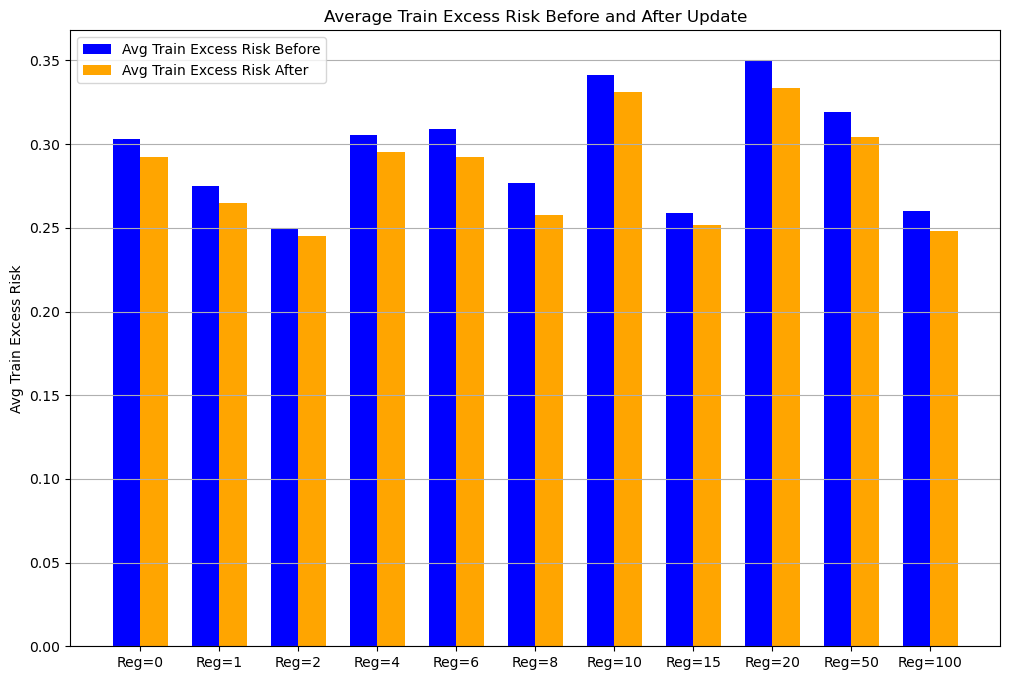

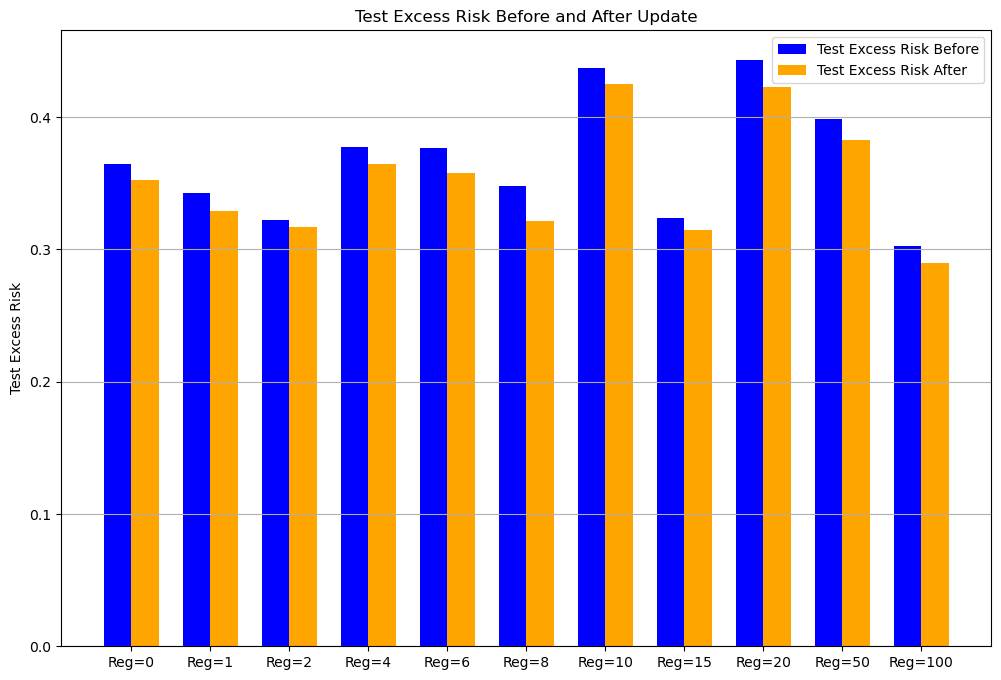

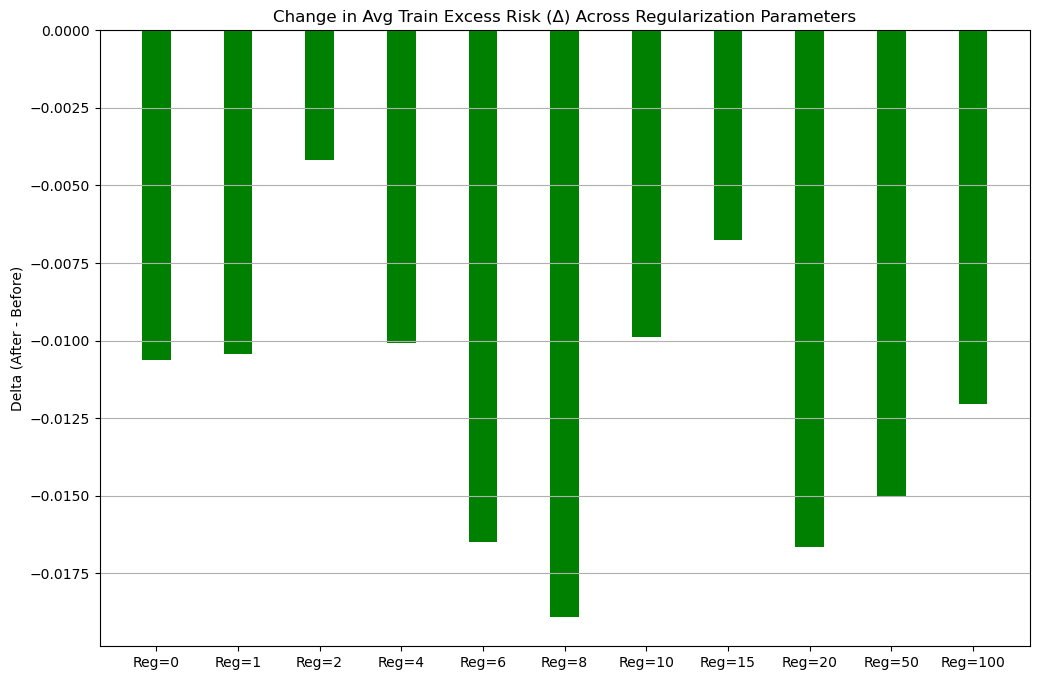

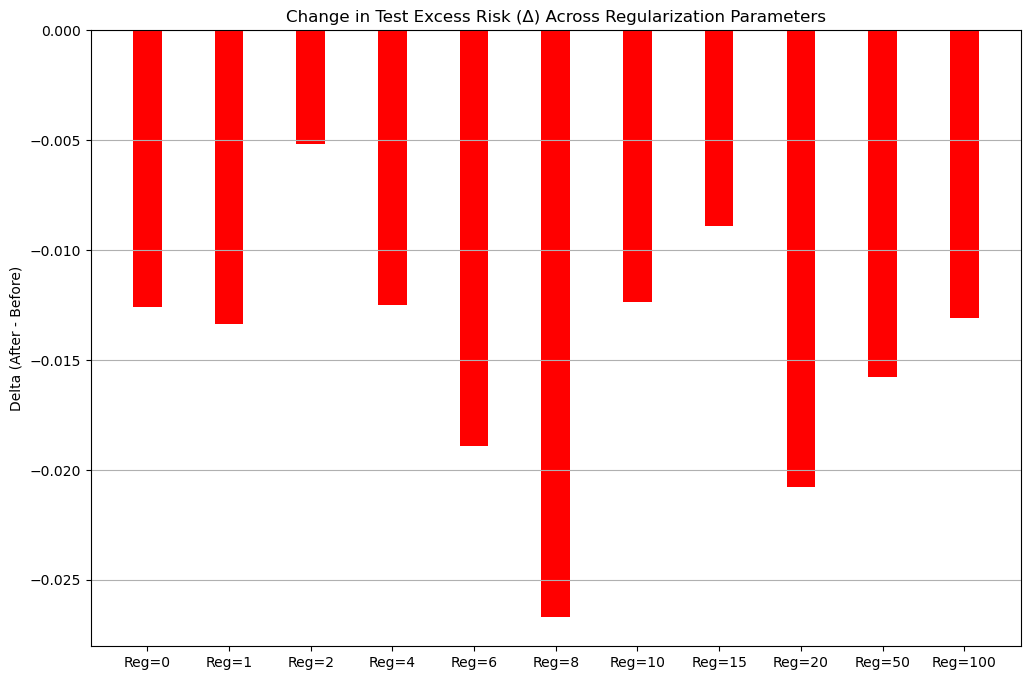

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Function to run trials and plot results for various lambda (regularization) parameters
def run_trials_and_plot_risks(dx, dy, r, T, n, lr_phi, lr_g, num_steps, num_trials=20, reg_params=[0, 1, 2, 4, 6, 8, 10, 15, 20, 50, 100]):
    # Store results for each regularization parameter
    trial_results = {
        reg_param: {"avg_train_before": [], "avg_train_after": [], "test_before": [], "test_after": []}
        for reg_param in reg_params
    }

    # Run trials for each regularization parameter
    for reg_param in reg_params:
        print(f"Running trials for reg_param={reg_param}...")
        for trial in range(num_trials):
            print(f"  Trial {trial + 1}/{num_trials}")
            _, _, _, _, avg_train_before, avg_train_after, test_before, test_after = experiment(
                dx, dy, r, T, n, lr_phi, lr_g, num_steps, reg_param=reg_param
            )
            trial_results[reg_param]["avg_train_before"].append(avg_train_before)
            trial_results[reg_param]["avg_train_after"].append(avg_train_after)
            trial_results[reg_param]["test_before"].append(test_before)
            trial_results[reg_param]["test_after"].append(test_after)

    # Compute means and deltas
    avg_train_deltas = []
    test_deltas = []
    for reg_param in reg_params:
        avg_train_before_mean = np.mean(trial_results[reg_param]["avg_train_before"])
        avg_train_after_mean = np.mean(trial_results[reg_param]["avg_train_after"])
        test_before_mean = np.mean(trial_results[reg_param]["test_before"])
        test_after_mean = np.mean(trial_results[reg_param]["test_after"])

        avg_train_deltas.append(avg_train_after_mean - avg_train_before_mean)
        test_deltas.append(test_after_mean - test_before_mean)

    # Plot avg_train_excess_risk_before and avg_train_excess_risk_after
    plt.figure(figsize=(12, 8))
    x = np.arange(len(reg_params))
    bar_width = 0.35
    avg_train_before_means = [np.mean(trial_results[reg_param]["avg_train_before"]) for reg_param in reg_params]
    avg_train_after_means = [np.mean(trial_results[reg_param]["avg_train_after"]) for reg_param in reg_params]

    plt.bar(
        x - bar_width / 2, avg_train_before_means, bar_width, label="Avg Train Excess Risk Before", color="blue"
    )
    plt.bar(
        x + bar_width / 2, avg_train_after_means, bar_width, label="Avg Train Excess Risk After", color="orange"
    )
    plt.xticks(x, [f"Reg={param}" for param in reg_params])
    plt.ylabel("Avg Train Excess Risk")
    plt.title("Average Train Excess Risk Before and After Update")
    plt.legend()
    plt.grid(axis="y")
    plt.show()

    # Plot test_excess_risk_before and test_excess_risk_after
    plt.figure(figsize=(12, 8))
    test_before_means = [np.mean(trial_results[reg_param]["test_before"]) for reg_param in reg_params]
    test_after_means = [np.mean(trial_results[reg_param]["test_after"]) for reg_param in reg_params]

    plt.bar(
        x - bar_width / 2, test_before_means, bar_width, label="Test Excess Risk Before", color="blue"
    )
    plt.bar(
        x + bar_width / 2, test_after_means, bar_width, label="Test Excess Risk After", color="orange"
    )
    plt.xticks(x, [f"Reg={param}" for param in reg_params])
    plt.ylabel("Test Excess Risk")
    plt.title("Test Excess Risk Before and After Update")
    plt.legend()
    plt.grid(axis="y")
    plt.show()

    # Plot deltas for avg_train_excess_risk
    plt.figure(figsize=(12, 8))
    plt.bar(x, avg_train_deltas, color="green", width=bar_width)
    plt.xticks(x, [f"Reg={param}" for param in reg_params])
    plt.ylabel("Delta (After - Before)")
    plt.title("Change in Avg Train Excess Risk (Δ) Across Regularization Parameters")
    plt.grid(axis="y")
    plt.show()

    # Plot deltas for test_excess_risk
    plt.figure(figsize=(12, 8))
    plt.bar(x, test_deltas, color="red", width=bar_width)
    plt.xticks(x, [f"Reg={param}" for param in reg_params])
    plt.ylabel("Delta (After - Before)")
    plt.title("Change in Test Excess Risk (Δ) Across Regularization Parameters")
    plt.grid(axis="y")
    plt.show()

# Run the function
dx, dy, r = 50, 15, 5
T = 10
n = 320
lr_phi = 0.01
lr_g = 0.001
num_steps = 100

run_trials_and_plot_risks(dx, dy, r, T, n, lr_phi, lr_g, num_steps)
